In [1]:
import math
from math import log
import os
import pandas as pd
import numpy as np
from numpy.linalg import norm

import matplotlib
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer
import tensorflow as tf

from clearn.utils.data_loader import load_images, TrainValDataIterator
from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from clearn.config.common_path import get_encoded_csv_file
from clearn.config import ExperimentConfig
from clearn.experiments.experiment import Experiment, initialize_model_train_and_get_features, get_model,  MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
from clearn.analysis.encode_decode import decode
from clearn.analysis.cluster_utils import cluster_and_decode_latent_vectors, display_cluster_center_images,get_cluster
from clearn.analysis.cluster_utils import get_cluster_groups, get_samples_for_cluster
from clearn.analysis import ManualAnnotation, Cluster, ClusterGroup
from clearn.utils.data_loader import TrainValDataIterator
from clearn.dao.dao_factory import get_dao
from clearn.analysis.cluster_utils import cluster_next_level, plot_number_of_samples_vs_label
from clearn.analysis.cluster_utils import assign_manual_label_and_confidence, plot_distance_distribution
from PIL import Image


%matplotlib inline


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint

In [2]:
cluster_column_name ="cluster_level_1"
cluster_column_name_2 ="cluster_level_2"
cluster_column_name_3 ="cluster_level_3"

In [3]:
def distance(row,cluster_center,z_col_names):
    return norm(row[z_col_names].values - cluster_center)
from scipy.spatial.distance import mahalanobis
def distance(row, inv_cov, cluster_center,z_col_names):
    return mahalanobis(row[z_col_names].values, cluster_center, inv_cov)


import scipy as sp

def compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers):

    for i in range(num_clusters):
        df["distance_{}".format(i)] = 100000
    for cluster_num in range(num_clusters):
        indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
        lv= df[z_col_names].values[indices, :]
        print(lv.shape)
        cov = np.cov(lv.T)
        inv_cov = sp.linalg.inv(cov)
        df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                       inv_cov,
                                                                                                       cluster_centers[cluster_num],
                                                                                                       z_col_names),
                                                                                     axis=1)


In [4]:
def compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers):
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            lv= df[z_col_names].values[indices, :]
            cov = np.cov(lv.T)
            inv_cov = sp.linalg.inv(cov)

            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               inv_cov,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


# Set experiment parameters

In [5]:
z_dim = 10
run_id = 47
ROOT_PATH= "/Users/sunilv/concept_learning_exp"
num_units=[64, 128, 32]
#num_units = [16, 32, 8]

create_split = False


In [6]:
experiment_name = "semi_sup_gaussian_mah_k8"
ROOT_PATH= "/Users/sunilv/concept_learning_exp"
num_units=[64, 128, 32]
#num_units = [16, 32, 8]

create_split = False
num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_TWO_TIMES_ELBOW

exp_config = ExperimentConfig(root_path=ROOT_PATH,
                               num_decoder_layer=4,
                               z_dim=z_dim,
                               num_units=num_units,
                               num_cluster_config=num_cluster_config,
                               confidence_decay_factor=8,
                               beta=5,
                               supervise_weight=150,
                               dataset_name="mnist",
                               split_name="Split_1",
                               model_name="VAE",
                               batch_size=64,
                               eval_interval_in_epochs=1,
                               name=experiment_name,
                               num_val_samples=128,
                               total_training_samples=60000,
                               manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                               reconstruction_weight=1,
                               activation_hidden_layer="RELU",
                               activation_output_layer="SIGMOID")
exp_config.check_and_create_directories(run_id)
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name


In [7]:
# K = exp_config.confidence_decay_factor
# def convert_distance_to_confidence(dist):
#     return np.exp(-1 / K * dist)

# def get_percentage_correct(confidence):
#     df1 = df[df["manual_annotation_confidence"] > confidence]
#     if df1.shape[0] != 0:
#         df2 = df1[df1["manual_annotation"] == df1["label"]]        
#         return df2.shape[0] / df1.shape[0]
#     else:
#         return 1
# def get_distance(confidence):
#     return -K * log(confidence)
# def get_confidence(distance):
#     return np.exp(-distance/K)

K = exp_config.confidence_decay_factor
def convert_distance_to_confidence(dist):
    return np.exp(-1 / K * dist * dist)

def get_percentage_correct(confidence):
    df1 = df[df["manual_annotation_confidence"] > confidence]
    if df1.shape[0] != 0:
        df2 = df1[df1["manual_annotation"] == df1["label"]]        
        return df2.shape[0] / df1.shape[0]
    else:
        return 1
def get_distance(confidence):
    return math.sqrt(-K * log(confidence))

def get_confidence(distance):
    return np.exp(-distance * distance/K)


In [8]:
dao = get_dao(exp_config.dataset_name, exp_config.split_name, exp_config.num_val_samples)

# Train model

In [9]:
num_epochs = 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
train_val_data_iterator, exp_config, model = initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
                                       )
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'TWO_TIMES_ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 47, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k8'}
Warning /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/analysis/manual_annotation_epoch_-1.0.csv path does not exist. Cr

Epoch: 0/69, Nll_loss : 214.07785034179688 KLD:1.0195001363754272  Supervised loss:0.0
Epoch: 0/70, Nll_loss : 200.25204467773438 KLD:1.1811566352844238  Supervised loss:0.0
Epoch: 0/71, Nll_loss : 201.6826629638672 KLD:1.3276840448379517  Supervised loss:0.0
Epoch: 0/72, Nll_loss : 200.71530151367188 KLD:1.5471653938293457  Supervised loss:0.0
Epoch: 0/73, Nll_loss : 201.90957641601562 KLD:1.3916330337524414  Supervised loss:0.0
Epoch: 0/74, Nll_loss : 207.39010620117188 KLD:1.3466477394104004  Supervised loss:0.0
Epoch: 0/75, Nll_loss : 193.92654418945312 KLD:1.3573052883148193  Supervised loss:0.0
Epoch: 0/76, Nll_loss : 202.1333465576172 KLD:1.5384111404418945  Supervised loss:0.0
Epoch: 0/77, Nll_loss : 204.13253784179688 KLD:1.1396286487579346  Supervised loss:0.0
Epoch: 0/78, Nll_loss : 201.10842895507812 KLD:1.386313796043396  Supervised loss:0.0
Epoch: 0/79, Nll_loss : 199.02854919433594 KLD:1.164635181427002  Supervised loss:0.0
Epoch: 0/80, Nll_loss : 193.97158813476562 KLD:

Epoch: 0/166, Nll_loss : 181.62301635742188 KLD:2.6889514923095703  Supervised loss:0.0
Epoch: 0/167, Nll_loss : 174.1947021484375 KLD:2.924224615097046  Supervised loss:0.0
Epoch: 0/168, Nll_loss : 175.7334747314453 KLD:2.9126102924346924  Supervised loss:0.0
Epoch: 0/169, Nll_loss : 173.56805419921875 KLD:3.3023619651794434  Supervised loss:0.0
Epoch: 0/170, Nll_loss : 173.74420166015625 KLD:3.77089262008667  Supervised loss:0.0
Epoch: 0/171, Nll_loss : 178.5218505859375 KLD:3.5458199977874756  Supervised loss:0.0
Epoch: 0/172, Nll_loss : 172.05645751953125 KLD:3.4756979942321777  Supervised loss:0.0
Epoch: 0/173, Nll_loss : 175.80526733398438 KLD:3.0862441062927246  Supervised loss:0.0
Epoch: 0/174, Nll_loss : 172.521484375 KLD:3.5058953762054443  Supervised loss:0.0
Epoch: 0/175, Nll_loss : 166.46173095703125 KLD:3.163815975189209  Supervised loss:0.0
Epoch: 0/176, Nll_loss : 179.151611328125 KLD:3.324247121810913  Supervised loss:0.0
Epoch: 0/177, Nll_loss : 181.68539428710938 KLD

Epoch: 0/261, Nll_loss : 160.61724853515625 KLD:4.273148536682129  Supervised loss:0.0
Epoch: 0/262, Nll_loss : 158.7793426513672 KLD:4.08160400390625  Supervised loss:0.0
Epoch: 0/263, Nll_loss : 168.224853515625 KLD:3.8356728553771973  Supervised loss:0.0
Epoch: 0/264, Nll_loss : 150.5115966796875 KLD:4.131932258605957  Supervised loss:0.0
Epoch: 0/265, Nll_loss : 159.10118103027344 KLD:4.070923328399658  Supervised loss:0.0
Epoch: 0/266, Nll_loss : 154.93331909179688 KLD:4.158062934875488  Supervised loss:0.0
Epoch: 0/267, Nll_loss : 158.8434295654297 KLD:4.084173202514648  Supervised loss:0.0
Epoch: 0/268, Nll_loss : 166.7954559326172 KLD:4.493136405944824  Supervised loss:0.0
Epoch: 0/269, Nll_loss : 168.1009521484375 KLD:4.29157829284668  Supervised loss:0.0
Epoch: 0/270, Nll_loss : 159.18887329101562 KLD:4.503109931945801  Supervised loss:0.0
Epoch: 0/271, Nll_loss : 162.78167724609375 KLD:4.300536155700684  Supervised loss:0.0
Epoch: 0/272, Nll_loss : 163.21241760253906 KLD:4.1

Epoch: 0/357, Nll_loss : 155.3759002685547 KLD:4.894933700561523  Supervised loss:0.0
Epoch: 0/358, Nll_loss : 146.7238006591797 KLD:5.216483116149902  Supervised loss:0.0
Epoch: 0/359, Nll_loss : 157.43695068359375 KLD:5.277568817138672  Supervised loss:0.0
Epoch: 0/360, Nll_loss : 147.93267822265625 KLD:5.298399925231934  Supervised loss:0.0
Epoch: 0/361, Nll_loss : 152.7678680419922 KLD:5.1401848793029785  Supervised loss:0.0
Epoch: 0/362, Nll_loss : 151.32577514648438 KLD:5.007641315460205  Supervised loss:0.0
Epoch: 0/363, Nll_loss : 147.4842529296875 KLD:4.932072639465332  Supervised loss:0.0
Epoch: 0/364, Nll_loss : 156.11474609375 KLD:4.636536598205566  Supervised loss:0.0
Epoch: 0/365, Nll_loss : 151.83749389648438 KLD:4.930563926696777  Supervised loss:0.0
Epoch: 0/366, Nll_loss : 156.01002502441406 KLD:4.665309906005859  Supervised loss:0.0
Epoch: 0/367, Nll_loss : 155.73068237304688 KLD:4.655143737792969  Supervised loss:0.0
Epoch: 0/368, Nll_loss : 156.36671447753906 KLD:4

Epoch: 0/452, Nll_loss : 148.01956176757812 KLD:5.664368152618408  Supervised loss:0.0
Epoch: 0/453, Nll_loss : 152.99136352539062 KLD:5.755145072937012  Supervised loss:0.0
Epoch: 0/454, Nll_loss : 144.41958618164062 KLD:5.337970733642578  Supervised loss:0.0
Epoch: 0/455, Nll_loss : 143.81179809570312 KLD:5.32623815536499  Supervised loss:0.0
Epoch: 0/456, Nll_loss : 149.66493225097656 KLD:5.152915954589844  Supervised loss:0.0
Epoch: 0/457, Nll_loss : 140.96978759765625 KLD:4.932278633117676  Supervised loss:0.0
Epoch: 0/458, Nll_loss : 147.1808319091797 KLD:4.884005546569824  Supervised loss:0.0
Epoch: 0/459, Nll_loss : 147.52096557617188 KLD:5.310876846313477  Supervised loss:0.0
Epoch: 0/460, Nll_loss : 144.0079345703125 KLD:5.290010452270508  Supervised loss:0.0
Epoch: 0/461, Nll_loss : 147.799560546875 KLD:5.686126708984375  Supervised loss:0.0
Epoch: 0/462, Nll_loss : 147.37042236328125 KLD:5.4693284034729  Supervised loss:0.0
Epoch: 0/463, Nll_loss : 149.82533264160156 KLD:5.

Epoch: 0/548, Nll_loss : 137.45460510253906 KLD:5.765255928039551  Supervised loss:0.0
Epoch: 0/549, Nll_loss : 139.02386474609375 KLD:5.5828857421875  Supervised loss:0.0
Epoch: 0/550, Nll_loss : 143.8131866455078 KLD:5.684528350830078  Supervised loss:0.0
Epoch: 0/551, Nll_loss : 142.155517578125 KLD:5.669590950012207  Supervised loss:0.0
Epoch: 0/552, Nll_loss : 137.45883178710938 KLD:5.165352821350098  Supervised loss:0.0
Epoch: 0/553, Nll_loss : 143.89071655273438 KLD:5.568048000335693  Supervised loss:0.0
Epoch: 0/554, Nll_loss : 143.27056884765625 KLD:5.487525939941406  Supervised loss:0.0
Epoch: 0/555, Nll_loss : 146.90206909179688 KLD:5.605681419372559  Supervised loss:0.0
Epoch: 0/556, Nll_loss : 150.96728515625 KLD:5.580942153930664  Supervised loss:0.0
Epoch: 0/557, Nll_loss : 144.47801208496094 KLD:5.6901044845581055  Supervised loss:0.0
Epoch: 0/558, Nll_loss : 139.7552032470703 KLD:5.807887077331543  Supervised loss:0.0
Epoch: 0/559, Nll_loss : 137.7748260498047 KLD:6.23

Epoch: 0/645, Nll_loss : 135.63858032226562 KLD:5.920310020446777  Supervised loss:0.0
Epoch: 0/646, Nll_loss : 141.5126953125 KLD:5.976661682128906  Supervised loss:0.0
Epoch: 0/647, Nll_loss : 142.55880737304688 KLD:5.811854362487793  Supervised loss:0.0
Epoch: 0/648, Nll_loss : 145.2880859375 KLD:6.162223815917969  Supervised loss:0.0
Epoch: 0/649, Nll_loss : 141.9579315185547 KLD:6.018689155578613  Supervised loss:0.0
Epoch: 0/650, Nll_loss : 133.00045776367188 KLD:5.893206596374512  Supervised loss:0.0
Epoch: 0/651, Nll_loss : 143.48667907714844 KLD:5.888799667358398  Supervised loss:0.0
Epoch: 0/652, Nll_loss : 138.655029296875 KLD:5.682547569274902  Supervised loss:0.0
Epoch: 0/653, Nll_loss : 143.4474334716797 KLD:5.330388069152832  Supervised loss:0.0
Epoch: 0/654, Nll_loss : 145.5851287841797 KLD:5.498499870300293  Supervised loss:0.0
Epoch: 0/655, Nll_loss : 142.16680908203125 KLD:5.756870746612549  Supervised loss:0.0
Epoch: 0/656, Nll_loss : 139.890380859375 KLD:5.89563417

Epoch: 0/742, Nll_loss : 130.45944213867188 KLD:6.010897636413574  Supervised loss:0.0
Epoch: 0/743, Nll_loss : 149.2031707763672 KLD:6.374907493591309  Supervised loss:0.0
Epoch: 0/744, Nll_loss : 133.88157653808594 KLD:5.967902660369873  Supervised loss:0.0
Epoch: 0/745, Nll_loss : 137.9102783203125 KLD:5.892989635467529  Supervised loss:0.0
Epoch: 0/746, Nll_loss : 139.23236083984375 KLD:6.103786945343018  Supervised loss:0.0
Epoch: 0/747, Nll_loss : 137.26739501953125 KLD:5.704776287078857  Supervised loss:0.0
Epoch: 0/748, Nll_loss : 138.1522216796875 KLD:6.1005706787109375  Supervised loss:0.0
Epoch: 0/749, Nll_loss : 136.81802368164062 KLD:6.23362922668457  Supervised loss:0.0
Epoch: 0/750, Nll_loss : 130.25718688964844 KLD:6.20028018951416  Supervised loss:0.0
Epoch: 0/751, Nll_loss : 143.5181884765625 KLD:6.132282257080078  Supervised loss:0.0
Epoch: 0/752, Nll_loss : 127.80781555175781 KLD:5.897773742675781  Supervised loss:0.0
Epoch: 0/753, Nll_loss : 136.40582275390625 KLD:

Epoch: 0/838, Nll_loss : 131.72193908691406 KLD:6.275197982788086  Supervised loss:0.0
Epoch: 0/839, Nll_loss : 140.3483428955078 KLD:6.182101726531982  Supervised loss:0.0
Epoch: 0/840, Nll_loss : 138.43096923828125 KLD:6.577935218811035  Supervised loss:0.0
Epoch: 0/841, Nll_loss : 139.18826293945312 KLD:6.465382099151611  Supervised loss:0.0
Epoch: 0/842, Nll_loss : 132.1975860595703 KLD:6.301746845245361  Supervised loss:0.0
Epoch: 0/843, Nll_loss : 122.80693817138672 KLD:6.295915126800537  Supervised loss:0.0
Epoch: 0/844, Nll_loss : 141.2064208984375 KLD:6.330545902252197  Supervised loss:0.0
Epoch: 0/845, Nll_loss : 127.68914794921875 KLD:6.3133063316345215  Supervised loss:0.0
Epoch: 0/846, Nll_loss : 132.09786987304688 KLD:6.201956748962402  Supervised loss:0.0
Epoch: 0/847, Nll_loss : 129.08682250976562 KLD:6.319863319396973  Supervised loss:0.0
Epoch: 0/848, Nll_loss : 136.8246307373047 KLD:6.441021919250488  Supervised loss:0.0
Epoch: 0/849, Nll_loss : 124.66304779052734 KL

Epoch: 0/933, Nll_loss : 129.92921447753906 KLD:6.0226850509643555  Supervised loss:0.0
Epoch: 0/934, Nll_loss : 133.11029052734375 KLD:6.155873775482178  Supervised loss:0.0
Epoch: 0/934, Nll_loss : 133.11029052734375
Completed 0 epochs
Running evaluation after epoch:1 and step:935 
epoch:1 step:935
Saving evaluation results to  /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/analysis/
Running evaluation after epoch:1 and step:935 
epoch:1 step:935
Saving evaluation results to  /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/analysis/
Running evaluation after epoch:1 and step:935 
epoch:1 step:935
Saving evaluation results to  /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/analysis/
Accuracy: train: [1, 0.08766711229946524]
Accuracy: val: [1, 0.0625]
Accuracy: test: [1, 0.08633814102564102]
Accuracy: train: [1, 135.02466]
Accuracy: val: [1, 1

# Load the trained model

In [10]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/trained_models/SemiSupervisedClassifierMnist.model-936"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/trained_models/SemiSupervisedClassifierMnist.model-936"
 
ckpt_name SemiSupervisedClassifierMnist.model-936
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:

# Read the latent vectors for train data

In [11]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=47 z_min=-4.368748 z_max=4.345868599999999
Latent vectors shape (59840, 10)


# Load training images,  labels and manual annotations

In [12]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed - 1)
                                     )
images, labels, _ = load_images(exp_config,
                                train_val_data_iterator,
                                "train"
                               )
unique_labels = train_val_data_iterator.get_unique_labels()
num_batches = images.shape[0] / exp_config.BATCH_SIZE
epochs_completed = num_steps_completed // num_batches
print("Number of epochs completed {}".format(epochs_completed))


Number of epochs completed 1.0


# Use Elbow method to to find out number of optimum clusters k

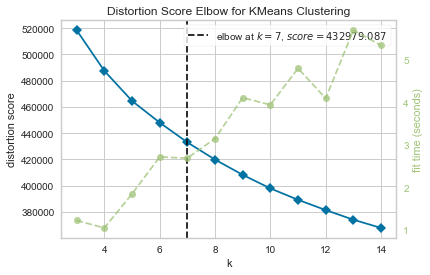

In [13]:
kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

In [14]:
if exp_config.num_cluster_config == ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW:
    num_clusters = visualizer.elbow_value_
else:
    num_clusters = 2 * visualizer.elbow_value_
if num_clusters < 10:
    num_clusters = 10
#num_clusters = 16

In [15]:
num_clusters

14


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/trained_models/SemiSupervisedClassifierMnist.model-936"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/trained_models/SemiSupervisedClassifierMnist.model-936"
 
ckpt_name SemiSupervisedClassifierMnist.model-936
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gauss

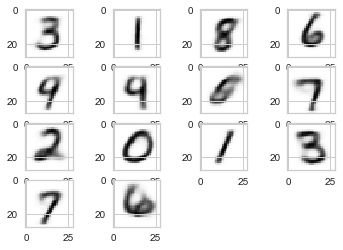

In [16]:
import json
import cv2
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
if not os.path.isfile(manual_annotation_file_json):
    #Cluster and decode the cluster center
    decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                        num_clusters,
                                                                                        latent_vectors,
                                                                                        exp_config,
                                                                                        dao
                                                                                       )
    display_cluster_center_images(decoded_images, image_filename, cluster_centers)
else:
    #TODO fix the issues in image display
#     plt.figure()
#     plt.imshow(cv2.imread(image_filename))
    with open(manual_annotation_file_json, "r") as json_file:
        manual_annotation_json = json.load(json_file)
    cluster_labels = np.asarray(manual_annotation_json["cluster_labels"])
    cluster_centers = np.asarray(manual_annotation_json["cluster_centers"])   
    img = Image.open(image_filename)
    img.show()
    

# Get the labels and confidence manualy,  -1 for unknown/invalid label

## Important:- Edit the values of `manual_annotation_json["manual_labels"]` and `manual_annotation_json["manual_confidence"]` manually looking at the cluster centers above. Also show  the images and  get  annotaions from few other samples closer to the cluster cetner

In [17]:
manual_annotation_json = None
if manual_annotation_json is None:
    #TODO get the input from console or a gui app. For now edit the values directly here
    print("Getting manual_annotation")
    manual_annotation_json = dict()
    manual_annotation_json["manual_labels"] = [3, 1, 8, 6,
                                               9, 9, -1, 7,
                                               2, 0, 1, 3,
                                               7, -1
                                              ]
    manual_annotation_json["manual_confidence"] = [0.8, 1, 1, 1,
                                                  0.8, 0.9, 0, 0.8,
                                                   0.9,1,1,0.9,
                                                  0.8, 0
                                                  ]
    
    manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
    manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
    with open(manual_annotation_file_json, "w") as json_file:
        json.dump(manual_annotation_json, json_file)

Getting manual_annotation


In [18]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

# TODO Split each of the cluster  into two/three  clusters, based on the manual label and confidence

In [19]:
cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 

In [20]:
cluster_group_dict

{'good_clusters': <clearn.analysis.ClusterGroup at 0x7ff640e3c9d0>,
 None: <clearn.analysis.ClusterGroup at 0x7ff67f22ccd0>,
 'unknown_cluster': <clearn.analysis.ClusterGroup at 0x7ff643fb3590>}

In [21]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
legend_string = "Cluster Number={} Label={}"
matplotlib.rc('font', **font)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


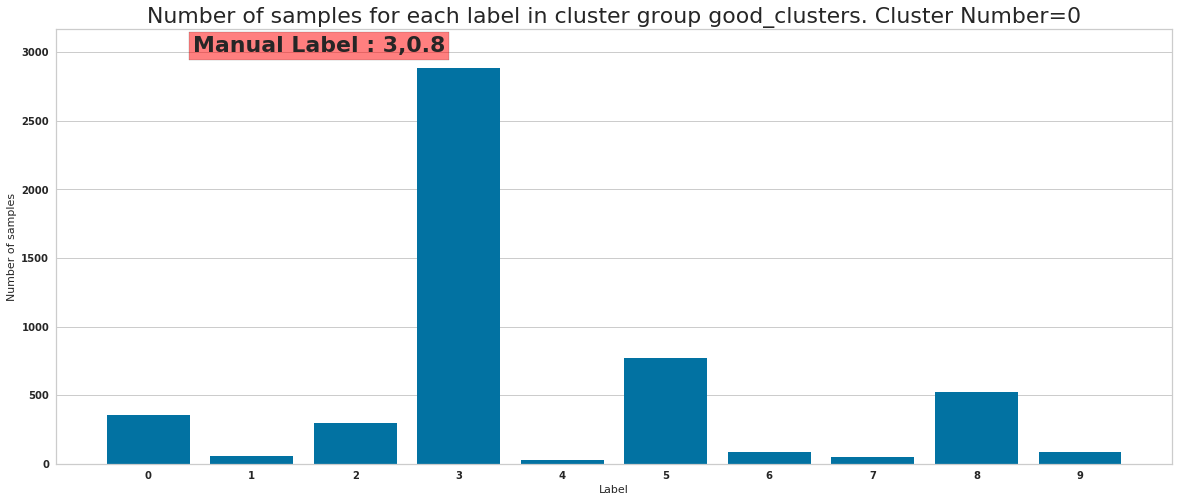

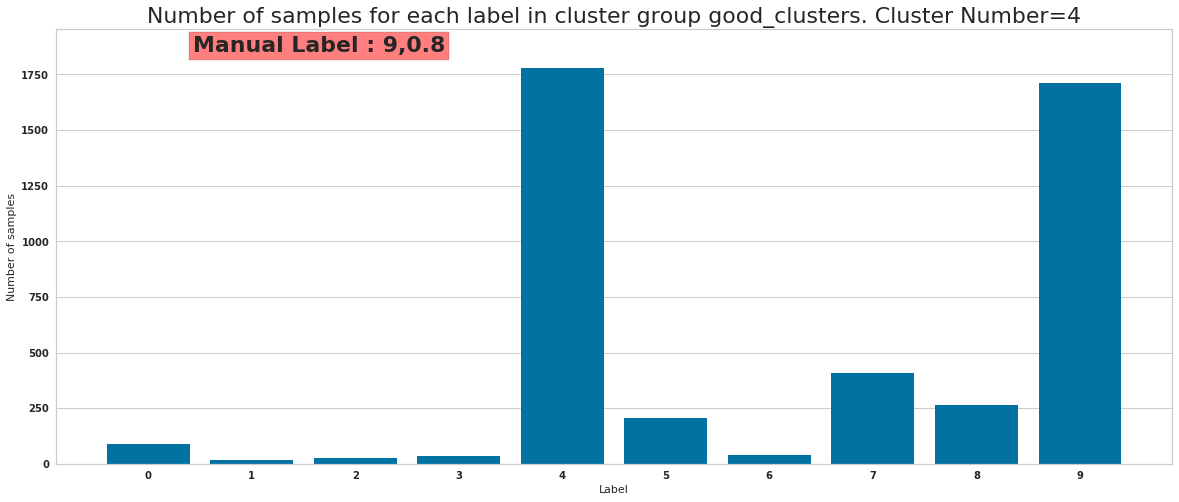

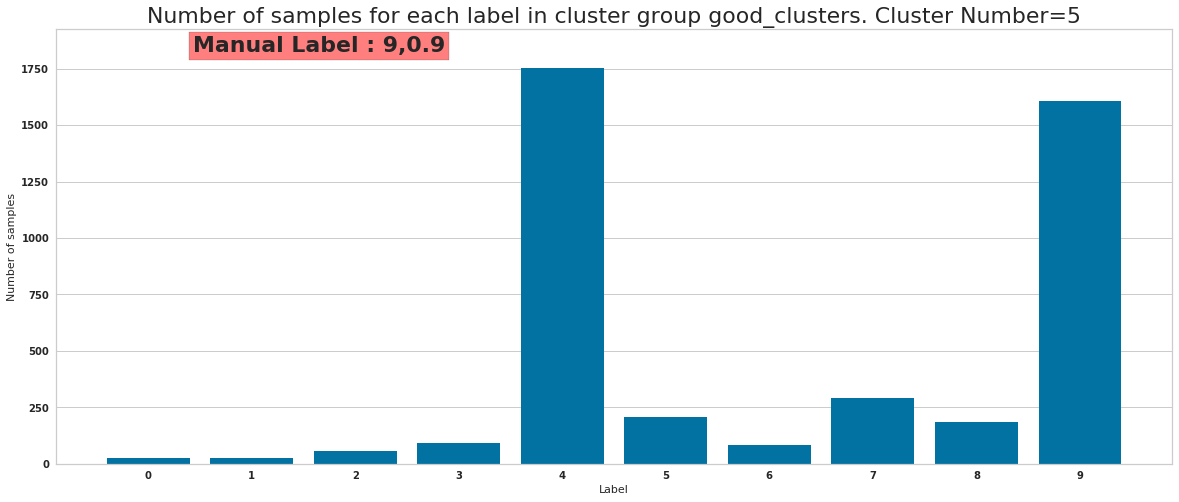

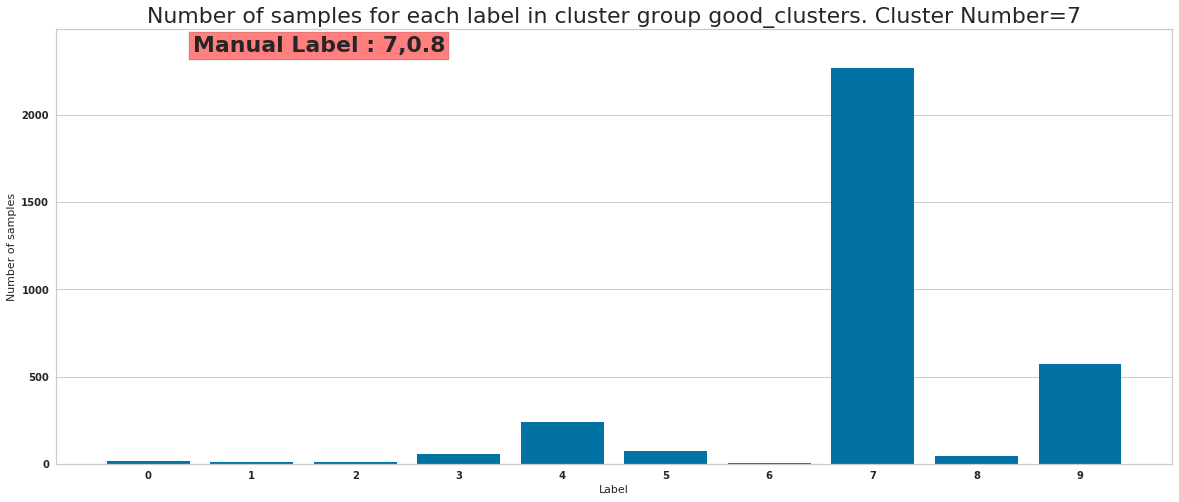

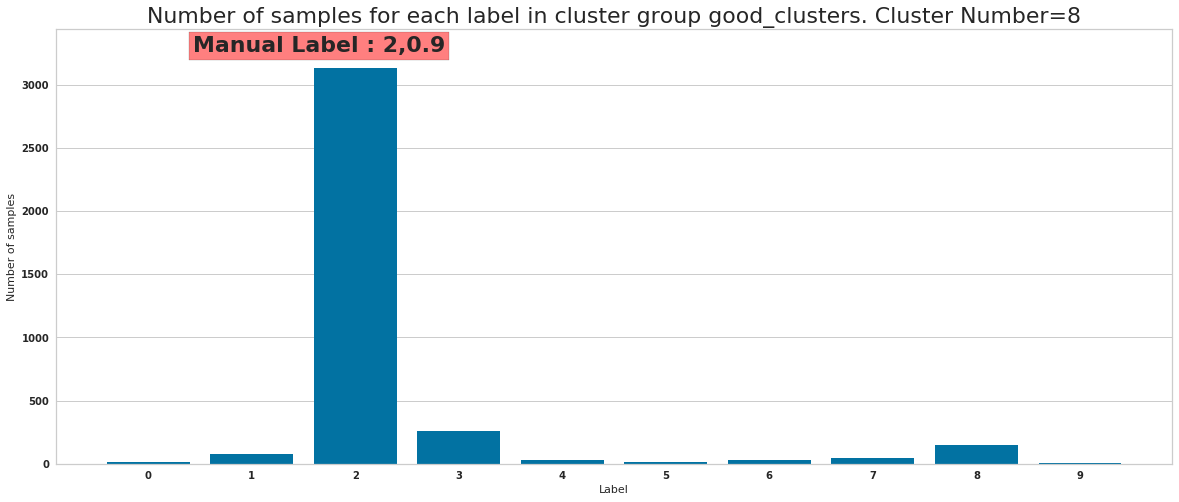

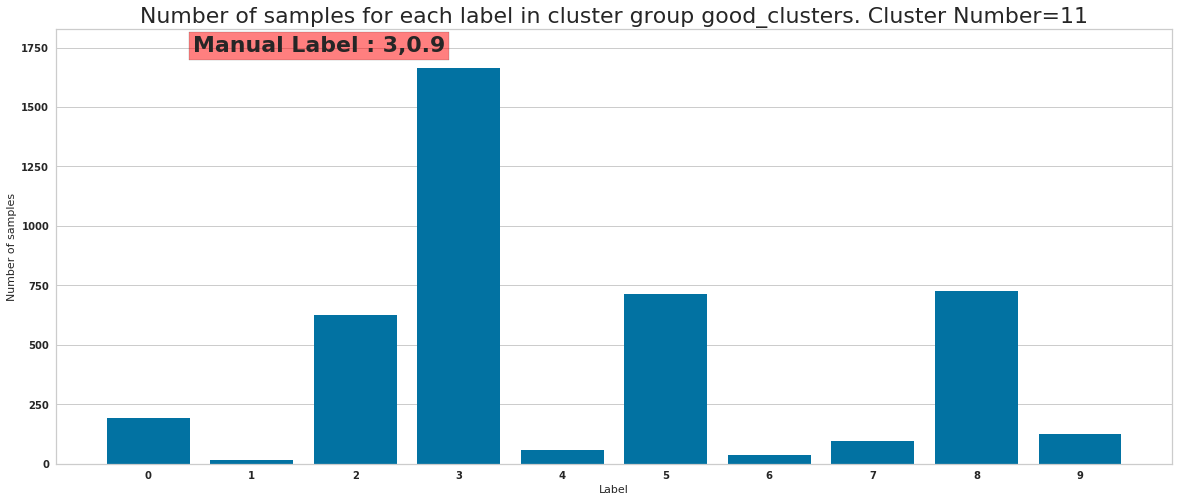

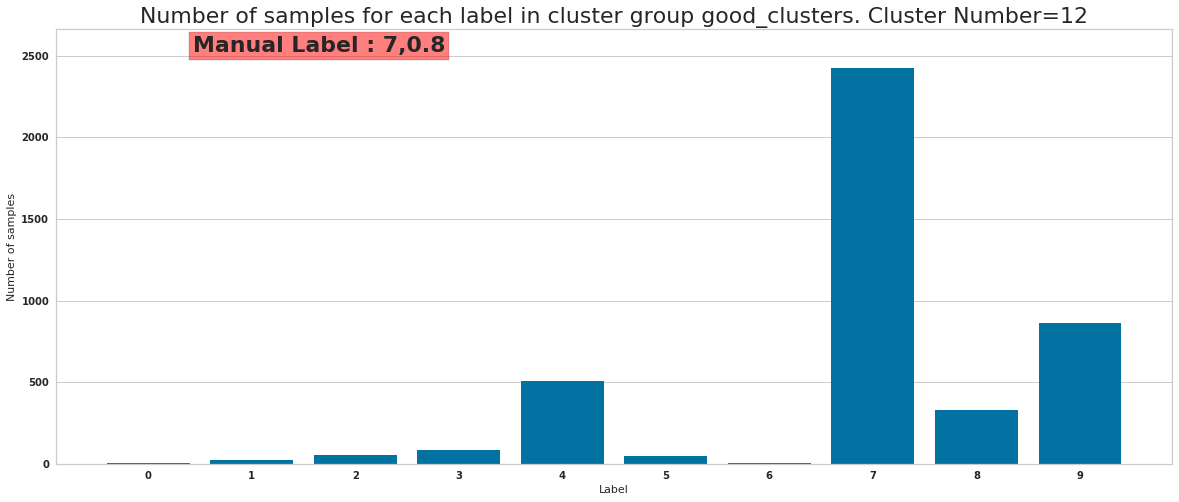

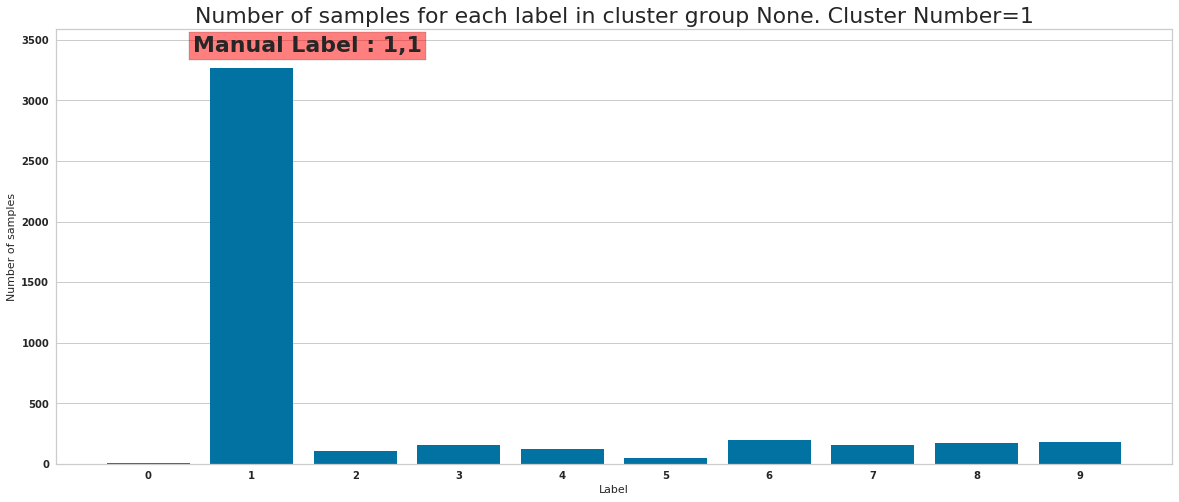

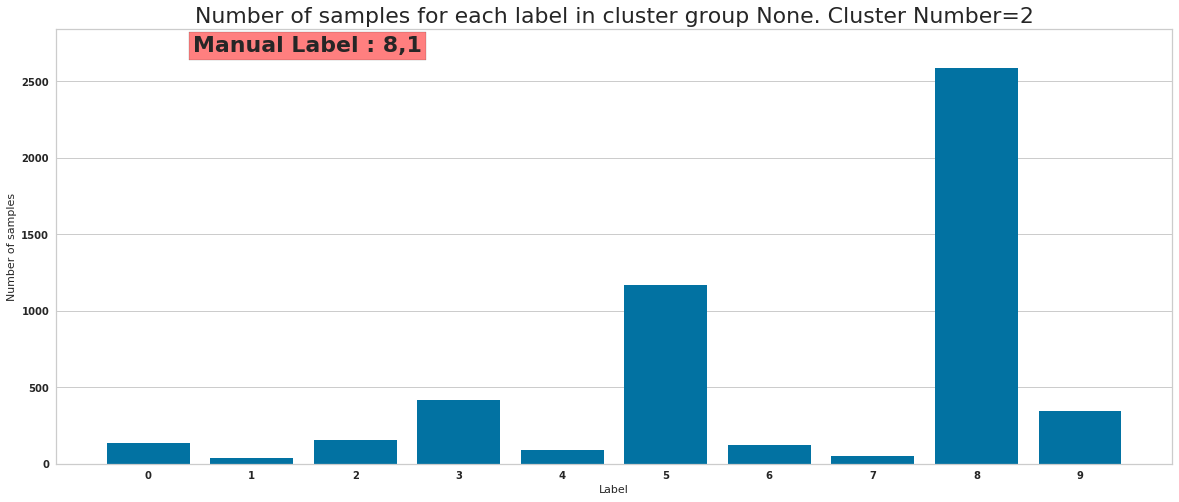

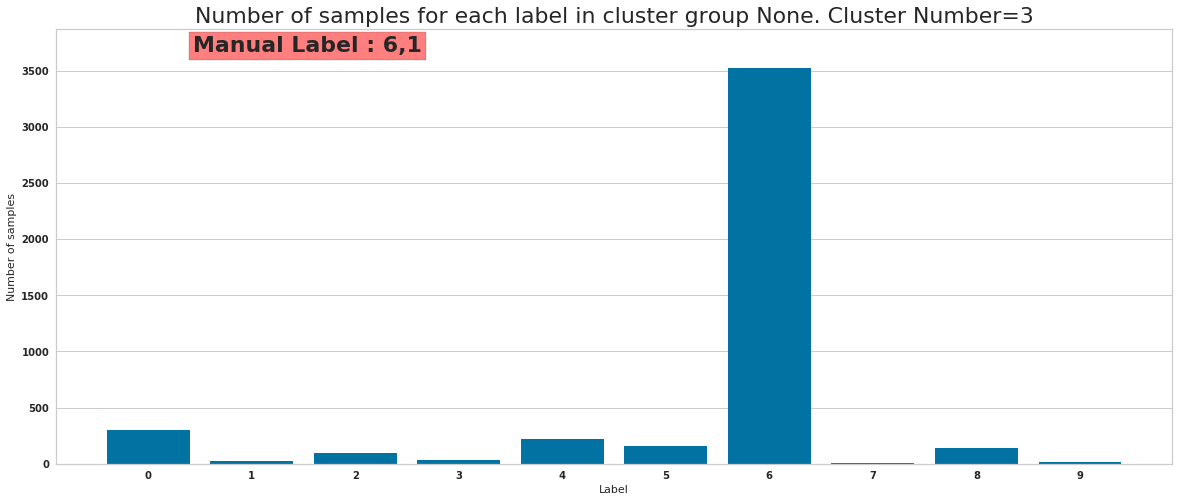

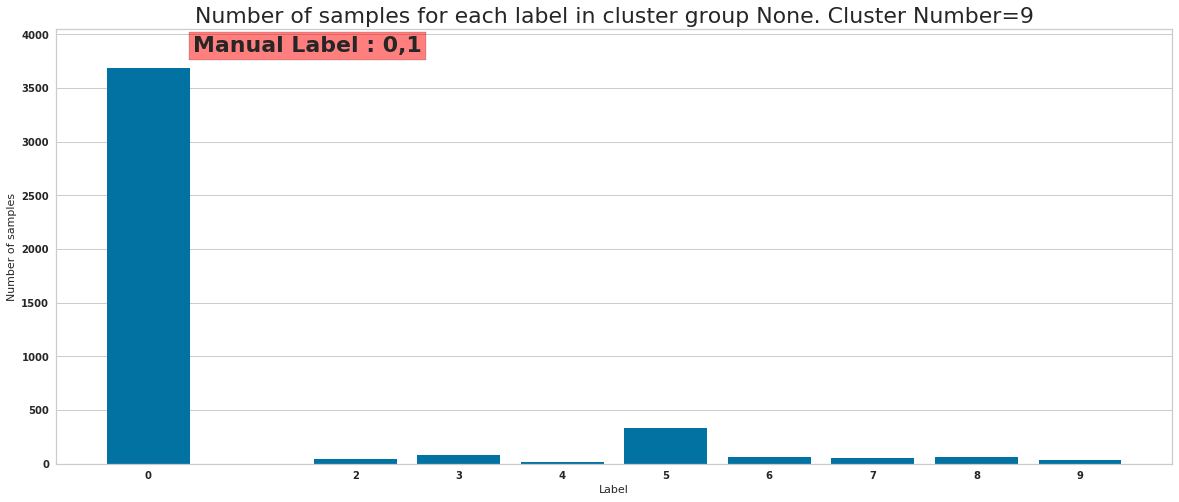

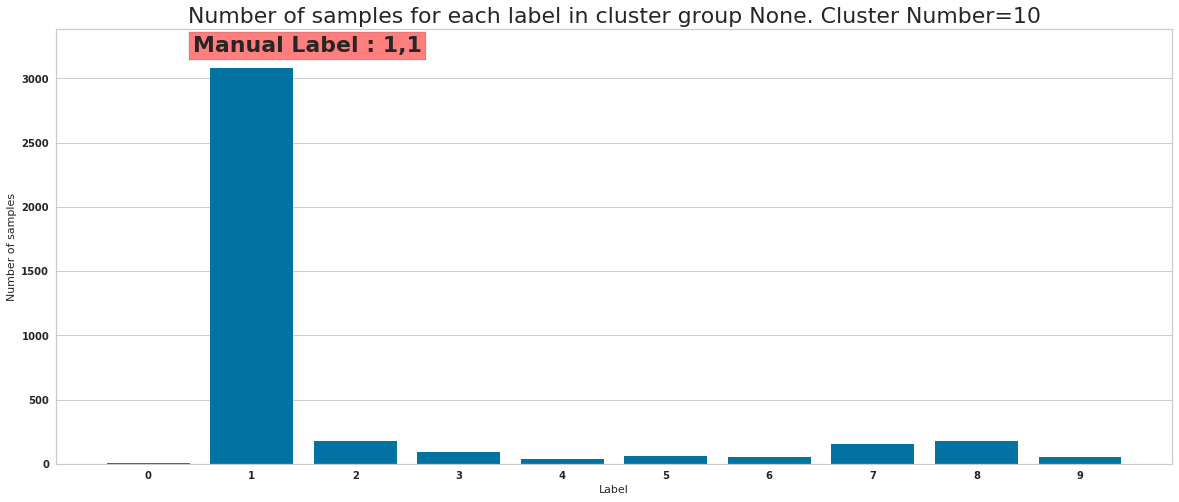

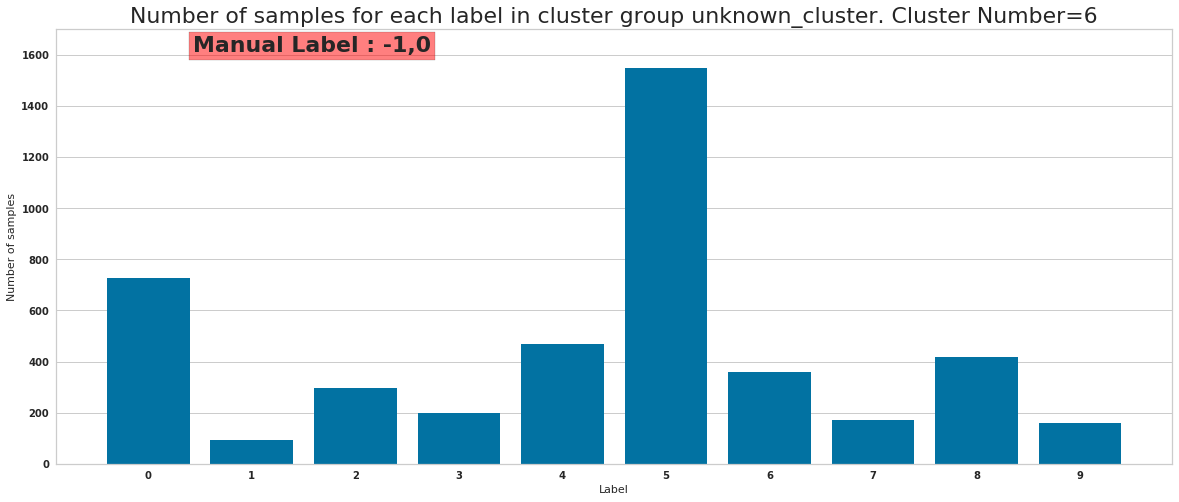

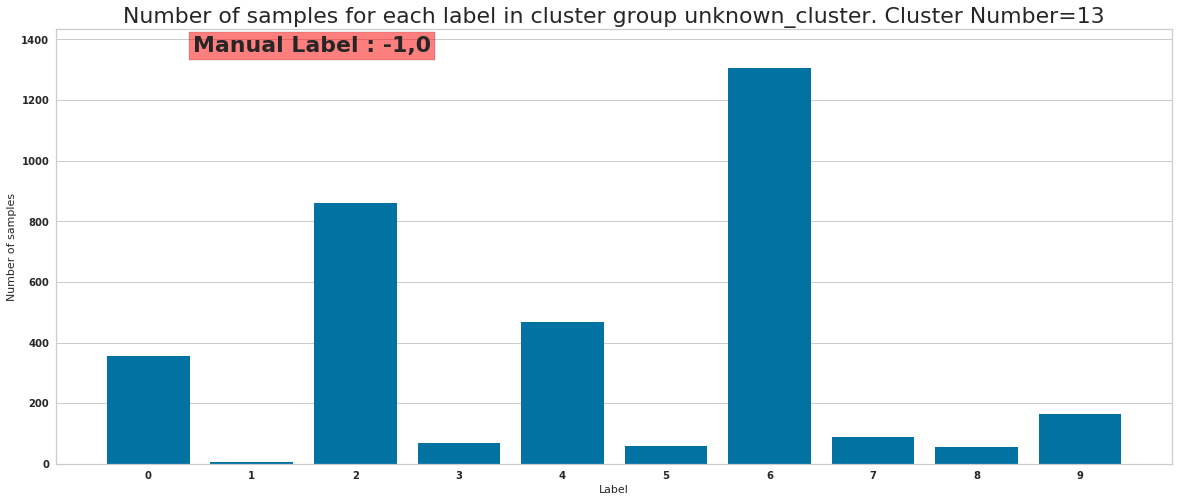

In [22]:
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

# For each sample, compute distance from respective cluster center

In [23]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

(5125, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(4411, 10)
(5103, 10)
(4514, 10)
(4568, 10)
(4330, 10)
(4441, 10)
(3286, 10)
(3772, 10)
(4377, 10)
(3888, 10)
(4256, 10)
(4343, 10)
(3426, 10)


6

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/trained_models/SemiSupervisedClassifierMnist.model-936"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/trained_models/SemiSupervisedClassifierMnist.model-936"
 
ckpt_name SemiSupervisedClassifierMnist.model-936
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gau

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


13
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/trained_models/SemiSupervisedClassifierMnist.model-936"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/trained_models/SemiSupervisedClassifierMnist.model-936"
 
ckpt_name SemiSupervisedClassifierMnist.model-936
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gau

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


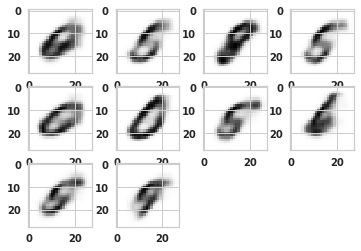

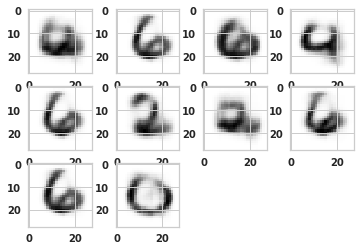

In [24]:
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



In [25]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [-1, -1, -1, -1,
                                        -1, 0, -1, -1,
                                         -1, -1
                                        ]
level_2_cluster_dict["manual_confidences"] = [0,0,0,0,
                                              0, 0.7, 0, 0,
                                              0, 0]
level2_manual_annotations[6] = level_2_cluster_dict


level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [-1, 6, -1, -1,
                                        6, -1, -1, 6,
                                        6, 0
                                        ]
level_2_cluster_dict["manual_confidences"] = [0, 0.8, 0, 0,
                                              0.7, 0, 0, 0.7,
                                              0.7, 0.7
                                             ]

level2_manual_annotations[13] = level_2_cluster_dict


# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [2, 8, 9, -1,
#                                         -1, -1, -1, 8,
#                                         -1, -1]
# level_2_cluster_dict["manual_confidences"] = [0.7, 0.7, 0.7, 0,
#                                               0, 0, 0, 0.7,
#                                               0, 0
#                                              ]
# level2_manual_annotations[5] = level_2_cluster_dict


# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1, 1, -1,
#                                         -1, -1, -1, 1,
#                                         -1, 1]
# level_2_cluster_dict["manual_confidences"] = [0,0,0,0,
#                                               0,0,0,0,
#                                               0,0
#                                              ]

# level2_manual_annotations[4] = level_2_cluster_dict



In [26]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)

6
13


In [27]:
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)

10
Skipping distance computation for unknown cluster
5 (425,)
10
Skipping distance computation for unknown cluster
1 (346,)
4 (398,)
7 (342,)
8 (357,)
9 (270,)


In [28]:
#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster

In [29]:
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)

In [30]:
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


In [31]:
def assign_manual_label_and_confidence(df,
                                       manual_annotation_dict,
                                       dist_to_conf,
                                       cluster_group_dict,
                                       cluster_column_name_2,
                                       assign_only_correct=False
                                       ):
    def assign_label(_df, _manual_label):
        _indices = np.where((np.asarray(cluster_labels) == cluster.id)
                            & (_df[cluster_column_name_2].values == _cluster.id))[0]
        _df["manual_annotation"].iloc[_indices] = _manual_label
        dst = _distance_df.iloc[_indices]
        _df["manual_annotation_confidence"].iloc[_indices] = _cluster.manual_annotation.confidence * dist_to_conf(dst)
        _df["distance_to_confidence"].iloc[_indices] = dist_to_conf(dst)
        if assign_only_correct:
            wrong_indices = (_df["manual_annotation"] == _manual_label) & (_df["label"] != _manual_label)
            _df["manual_annotation_confidence"].loc[wrong_indices] = 0

    df["manual_annotation"] = np.ones(df.shape[0]) * -1
    df["manual_annotation_confidence"] = np.zeros(df.shape[0])
    df["distance_to_confidence"] = np.zeros(df.shape[0])
    # manually given label for each cluster center -1 for unknown (cluster which has no semantic meaning)
    manual_labels = manual_annotation_dict["manual_labels"]
    cluster_labels = np.asarray(manual_annotation_dict["cluster_labels"])

    num_clusters = len(manual_labels)
    for annotate_cluster in range(num_clusters):
        distance_df = df["distance_{}".format(annotate_cluster)]
        manual_label = manual_labels[annotate_cluster]
        _manual_confidence = manual_annotation_dict["manual_confidence"][annotate_cluster]
        if isinstance(manual_label, tuple) or isinstance(manual_label, list):
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            for _cluster in cluster.next_level_clusters["good_clusters"]:
                _distance_df = df[f"distance_level_2_{cluster.id}_{_cluster.id}"]
                _manual_label = _cluster.manual_annotation.label
                if isinstance(_manual_label, tuple) or isinstance(_manual_label, list):
                    # TODO add this code
                    pass
                elif _manual_label != -1:
                    assign_label(df, _manual_label)
        elif manual_label != -1:
            print("Manual Label", manual_label)
            indices = np.where(cluster_labels == annotate_cluster)

            df["manual_annotation"].iloc[indices] = manual_label
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            print(df[df["manual_annotation"] == manual_label].shape, cluster.details["cluster_data_frame"].shape)
            num_correct = df[(manual_label == df["manual_annotation"]) & (df["label"] == manual_label)].shape[0]
            print("Num correct={}".format(num_correct))

            percentage_correct = 100 * num_correct / df[df["manual_annotation"] == manual_label].shape[0]
            print(f"Cluster {annotate_cluster} Manual Label {manual_label} Percentage correct {percentage_correct}")
            dist = distance_df.iloc[indices]
            df["manual_annotation_confidence"].iloc[indices] = _manual_confidence * dist_to_conf(dist)
            if assign_only_correct:
                wrong_indices = (df["manual_annotation"] == manual_label) & (df["label"] != manual_label)
                print(len(wrong_indices), wrong_indices.shape)
                df["manual_annotation_confidence"].loc[wrong_indices] = 0
            df["distance_to_confidence"].iloc[indices] = dist_to_conf(dist)
        else:
            print("unknown")
            # TODO second level clustering is not used now so commenting the code
            # unknown, check if second level clustering is done or not
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            print(type(cluster.next_level_clusters))
            print(list(cluster.next_level_clusters.keys()))

            for cluster_group_name, cluster_group in cluster.next_level_clusters.items():
                for _cluster in cluster_group:
                    _distance_df = df[f"distance_level_2_{cluster.id}_{_cluster.id}"]
                    _manual_label = _cluster.manual_annotation.label
                    print(f"********{_manual_label}*******")
                    if isinstance(_manual_label, tuple) or isinstance(_manual_label, list):
                        # TODO add this code
                        pass
                    elif _manual_label != -1:
                        print("Manual_label", _manual_label)
                        assign_label(df, _manual_label)
                    else:
                        # Manual label is -1
                        # Label all the 600 samples in the second level cluster
                        indices = np.where((np.asarray(cluster_labels) == cluster.id)
                                           & (df[cluster_column_name_2].values == _cluster.id))[0]
                        print(f"Annotating individual samples {indices.shape}")
                        df["manual_annotation"].iloc[indices] = df["label"][indices].values
                        df["manual_annotation_confidence"].iloc[indices] = 1

                        _dist = _distance_df.iloc[indices]
                        df["distance_to_confidence"].iloc[indices] = dist_to_conf(_dist)

        print("********************************")


In [32]:
assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2,
                                   assign_only_correct=False
                                  )

Manual Label 3
(5125, 71) (5125, 33)
Num correct=2880
Cluster 0 Manual Label 3 Percentage correct 56.19512195121951
********************************
Manual Label 1
(4411, 71) (4411, 33)
Num correct=3264
Cluster 1 Manual Label 1 Percentage correct 73.99682611652686
********************************
Manual Label 8
(5103, 71) (5103, 33)
Num correct=2585
Cluster 2 Manual Label 8 Percentage correct 50.65647658240251
********************************
Manual Label 6
(4514, 71) (4514, 33)
Num correct=3520
Cluster 3 Manual Label 6 Percentage correct 77.97961896322552
********************************
Manual Label 9
(4568, 71) (4568, 33)
Num correct=1712
Cluster 4 Manual Label 9 Percentage correct 37.478108581436075
********************************
Manual Label 9
(8898, 71) (4330, 33)
Num correct=3321
Cluster 5 Manual Label 9 Percentage correct 37.3229939312205
********************************
unknown
<class 'dict'>
['unknown_cluster', 'good_clusters']
********-1*******
Annotating individual sample

# Save the dataframe with manual annotations

In [33]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

(array([9536., 5103., 4514., 8898., 4441., 3286., 8149., 3888., 4256.,
        7769.]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]),
 <a list of 10 Patch objects>)

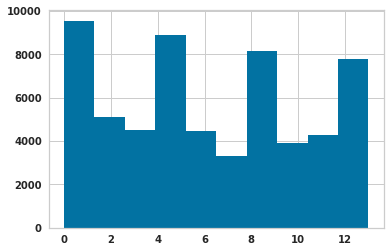

In [34]:
plt.hist(cluster_labels)

# Distribution of distance from cluster center

In [35]:
from clearn.analysis.cluster_utils import plot_distance_distribution

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


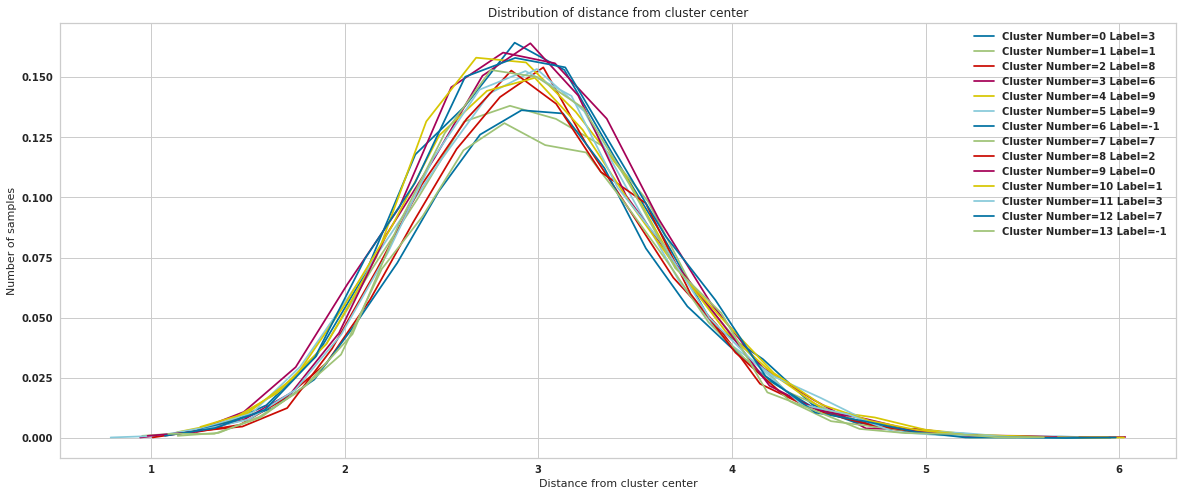

In [36]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

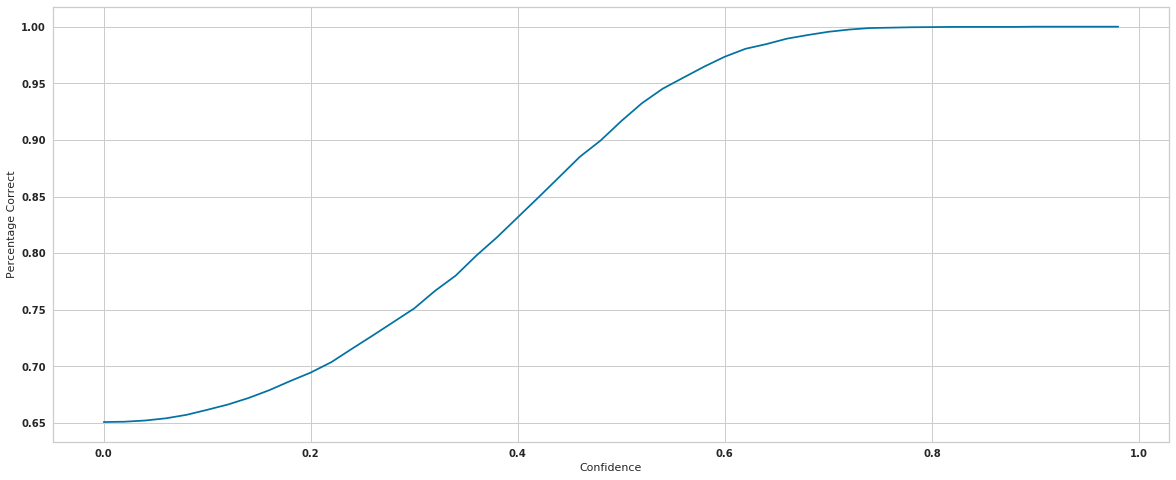

In [37]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

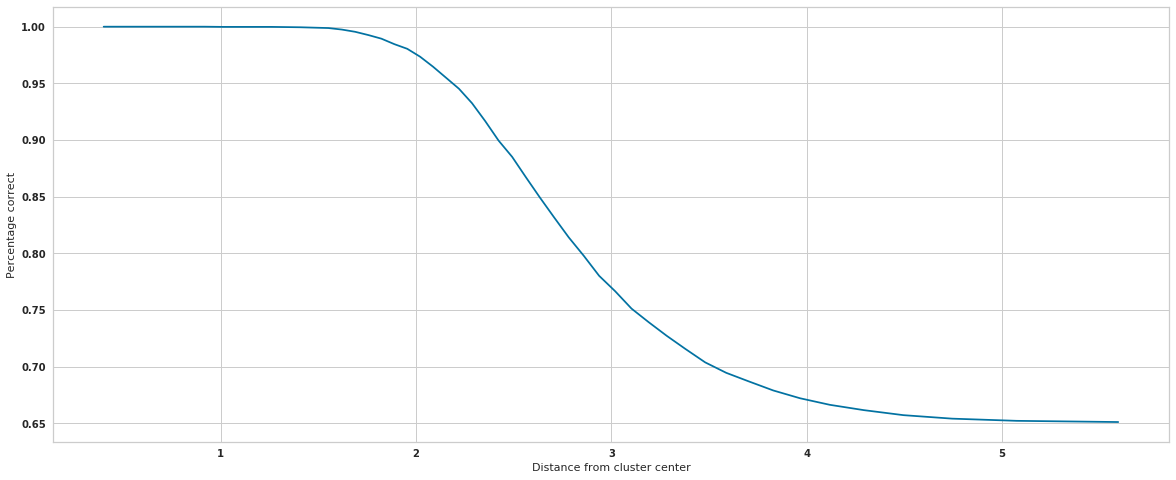

In [38]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

In [39]:
from shutil import copy2

In [40]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging 
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

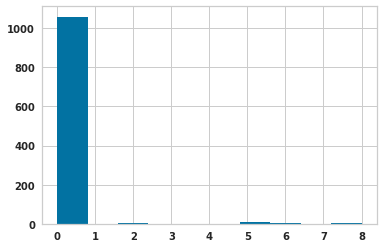

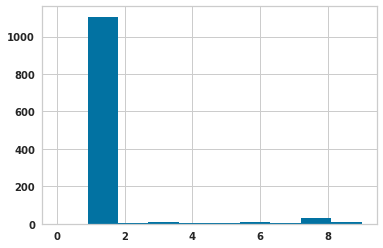

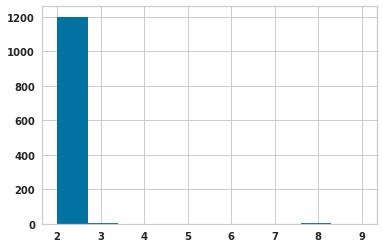

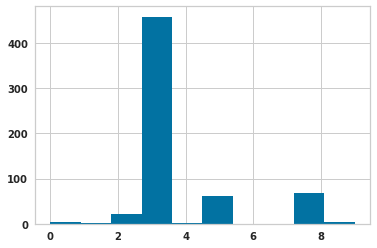

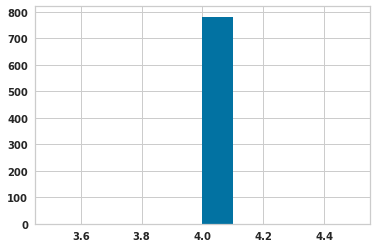

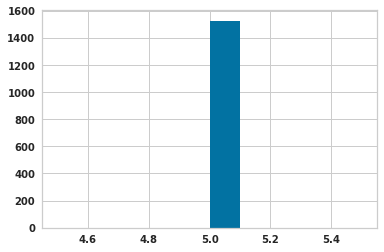

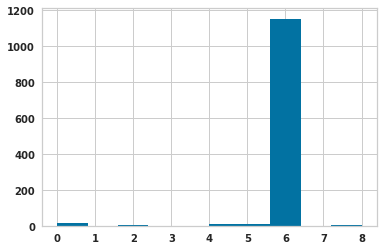

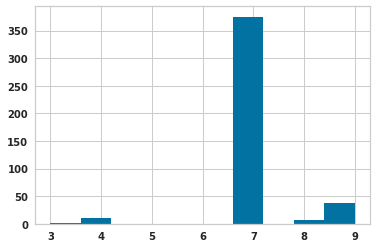

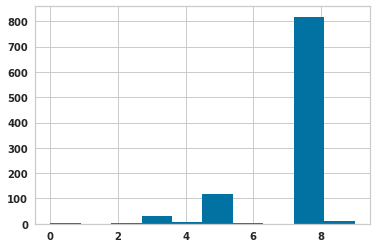

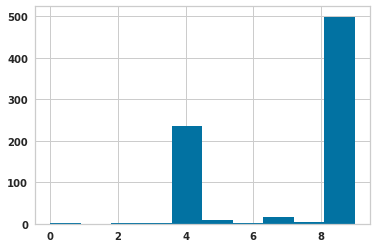

In [41]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [42]:
df.columns

Index(['label', 'label_predicted', 'mu_0', 'mu_1', 'mu_2', 'mu_3', 'mu_4',
       'mu_5', 'mu_6', 'mu_7', 'mu_8', 'mu_9', 'sigma_0', 'sigma_1', 'sigma_2',
       'sigma_3', 'sigma_4', 'sigma_5', 'sigma_6', 'sigma_7', 'sigma_8',
       'sigma_9', 'z_0', 'z_1', 'z_2', 'z_3', 'z_4', 'z_5', 'z_6', 'z_7',
       'z_8', 'z_9', 'cluster_level_1', 'distance_0', 'distance_1',
       'distance_2', 'distance_3', 'distance_4', 'distance_5', 'distance_6',
       'distance_7', 'distance_8', 'distance_9', 'distance_10', 'distance_11',
       'distance_12', 'distance_13', 'cluster_level_2', 'distance_level_2_6_0',
       'distance_level_2_6_1', 'distance_level_2_6_2', 'distance_level_2_6_3',
       'distance_level_2_6_4', 'distance_level_2_6_5', 'distance_level_2_6_6',
       'distance_level_2_6_7', 'distance_level_2_6_8', 'distance_level_2_6_9',
       'distance_level_2_13_0', 'distance_level_2_13_1',
       'distance_level_2_13_2', 'distance_level_2_13_3',
       'distance_level_2_13_4', 'distance_l

# Iteration 2

In [43]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'TWO_TIMES_ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 47, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k8'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 21447.106153093056
INFO:tensorflow:Summary name Negative

Epoch: 1/62, Nll_loss : 132.65945434570312 KLD:8.542254447937012  Supervised loss:0.35527825355529785
Epoch: 1/63, Nll_loss : 148.5511474609375 KLD:8.838086128234863  Supervised loss:0.3182945251464844
Epoch: 1/64, Nll_loss : 139.13258361816406 KLD:9.10139274597168  Supervised loss:0.4639871120452881
Epoch: 1/65, Nll_loss : 132.79367065429688 KLD:8.906892776489258  Supervised loss:0.38379335403442383
Epoch: 1/66, Nll_loss : 140.18675231933594 KLD:9.267364501953125  Supervised loss:0.45175865292549133
Epoch: 1/67, Nll_loss : 123.10871887207031 KLD:9.171895980834961  Supervised loss:0.32923680543899536
Epoch: 1/68, Nll_loss : 130.40472412109375 KLD:8.171798706054688  Supervised loss:0.47221630811691284
Epoch: 1/69, Nll_loss : 138.86135864257812 KLD:8.840372085571289  Supervised loss:0.3718840181827545
Epoch: 1/70, Nll_loss : 143.1192626953125 KLD:8.891777992248535  Supervised loss:0.44330137968063354
Epoch: 1/71, Nll_loss : 129.11660766601562 KLD:9.182594299316406  Supervised loss:0.3990

Epoch: 1/145, Nll_loss : 131.8551483154297 KLD:9.316911697387695  Supervised loss:0.25868651270866394
Epoch: 1/146, Nll_loss : 133.07672119140625 KLD:8.819332122802734  Supervised loss:0.4192729592323303
Epoch: 1/147, Nll_loss : 125.7075424194336 KLD:9.375306129455566  Supervised loss:0.35267019271850586
Epoch: 1/148, Nll_loss : 132.06744384765625 KLD:9.375297546386719  Supervised loss:0.299398809671402
Epoch: 1/149, Nll_loss : 137.9327392578125 KLD:8.855585098266602  Supervised loss:0.3331603407859802
Epoch: 1/150, Nll_loss : 127.55878448486328 KLD:8.518342971801758  Supervised loss:0.3510013222694397
Epoch: 1/151, Nll_loss : 141.43484497070312 KLD:8.702091217041016  Supervised loss:0.40733951330184937
Epoch: 1/152, Nll_loss : 131.6193084716797 KLD:8.135351181030273  Supervised loss:0.32753247022628784
Epoch: 1/153, Nll_loss : 134.6512451171875 KLD:8.199607849121094  Supervised loss:0.4381142854690552
Epoch: 1/154, Nll_loss : 128.6206817626953 KLD:8.657546043395996  Supervised loss:0.

Epoch: 1/226, Nll_loss : 130.75474548339844 KLD:9.495988845825195  Supervised loss:0.40844419598579407
Epoch: 1/227, Nll_loss : 128.12783813476562 KLD:9.057413101196289  Supervised loss:0.24870070815086365
Epoch: 1/228, Nll_loss : 134.7262420654297 KLD:8.084823608398438  Supervised loss:0.39514514803886414
Epoch: 1/229, Nll_loss : 133.25283813476562 KLD:8.270166397094727  Supervised loss:0.36131036281585693
Epoch: 1/230, Nll_loss : 130.18032836914062 KLD:8.557829856872559  Supervised loss:0.23577162623405457
Epoch: 1/231, Nll_loss : 136.6250457763672 KLD:8.04852294921875  Supervised loss:0.34054091572761536
Epoch: 1/232, Nll_loss : 135.19107055664062 KLD:8.366631507873535  Supervised loss:0.29963356256484985
Epoch: 1/233, Nll_loss : 126.36183166503906 KLD:9.065171241760254  Supervised loss:0.29046201705932617
Epoch: 1/234, Nll_loss : 124.89460754394531 KLD:10.033971786499023  Supervised loss:0.2656623125076294
Epoch: 1/235, Nll_loss : 126.79373168945312 KLD:9.613576889038086  Supervise

Epoch: 1/309, Nll_loss : 135.95068359375 KLD:9.29275894165039  Supervised loss:0.2790050208568573
Epoch: 1/310, Nll_loss : 119.58807373046875 KLD:9.726194381713867  Supervised loss:0.2390405535697937
Epoch: 1/311, Nll_loss : 133.2431640625 KLD:9.652777671813965  Supervised loss:0.34509336948394775
Epoch: 1/312, Nll_loss : 135.62802124023438 KLD:9.326045989990234  Supervised loss:0.3182826638221741
Epoch: 1/313, Nll_loss : 132.0372314453125 KLD:9.749709129333496  Supervised loss:0.22981752455234528
Epoch: 1/314, Nll_loss : 130.2081756591797 KLD:9.226526260375977  Supervised loss:0.25197604298591614
Epoch: 1/315, Nll_loss : 122.5324478149414 KLD:8.869462966918945  Supervised loss:0.23687207698822021
Epoch: 1/316, Nll_loss : 125.48119354248047 KLD:8.578723907470703  Supervised loss:0.26214146614074707
Epoch: 1/317, Nll_loss : 125.51139831542969 KLD:8.32723617553711  Supervised loss:0.30598825216293335
Epoch: 1/318, Nll_loss : 126.28450775146484 KLD:8.101119041442871  Supervised loss:0.324

Epoch: 1/390, Nll_loss : 123.25633239746094 KLD:9.480992317199707  Supervised loss:0.2790842652320862
Epoch: 1/391, Nll_loss : 124.82664489746094 KLD:9.466571807861328  Supervised loss:0.2565484046936035
Epoch: 1/392, Nll_loss : 121.83770751953125 KLD:8.794258117675781  Supervised loss:0.3606540262699127
Epoch: 1/393, Nll_loss : 125.46955108642578 KLD:8.664432525634766  Supervised loss:0.30195289850234985
Epoch: 1/394, Nll_loss : 135.218994140625 KLD:8.676724433898926  Supervised loss:0.2489616870880127
Epoch: 1/395, Nll_loss : 130.38323974609375 KLD:8.418764114379883  Supervised loss:0.302456796169281
Epoch: 1/396, Nll_loss : 129.05555725097656 KLD:7.936680793762207  Supervised loss:0.40335845947265625
Epoch: 1/397, Nll_loss : 129.2641143798828 KLD:8.774347305297852  Supervised loss:0.2792832851409912
Epoch: 1/398, Nll_loss : 123.96851348876953 KLD:8.038688659667969  Supervised loss:0.27055636048316956
Epoch: 1/399, Nll_loss : 136.69070434570312 KLD:8.822765350341797  Supervised loss:

Epoch: 1/471, Nll_loss : 122.60380554199219 KLD:9.591278076171875  Supervised loss:0.32013562321662903
Epoch: 1/472, Nll_loss : 121.83299255371094 KLD:9.476936340332031  Supervised loss:0.2703341245651245
Epoch: 1/473, Nll_loss : 128.80747985839844 KLD:9.080570220947266  Supervised loss:0.27617043256759644
Epoch: 1/474, Nll_loss : 122.97718811035156 KLD:9.362372398376465  Supervised loss:0.2546388506889343
Epoch: 1/475, Nll_loss : 123.60477447509766 KLD:8.82486343383789  Supervised loss:0.28189998865127563
Epoch: 1/476, Nll_loss : 126.925048828125 KLD:8.902162551879883  Supervised loss:0.2826876640319824
Epoch: 1/477, Nll_loss : 125.61444091796875 KLD:9.16942024230957  Supervised loss:0.2228153645992279
Epoch: 1/478, Nll_loss : 127.42112731933594 KLD:8.982524871826172  Supervised loss:0.3111412525177002
Epoch: 1/479, Nll_loss : 124.25071716308594 KLD:8.946828842163086  Supervised loss:0.31497636437416077
Epoch: 1/480, Nll_loss : 131.8140869140625 KLD:8.907571792602539  Supervised loss:

Epoch: 1/554, Nll_loss : 127.25901794433594 KLD:8.590287208557129  Supervised loss:0.27458369731903076
Epoch: 1/555, Nll_loss : 124.58878326416016 KLD:8.647890090942383  Supervised loss:0.3281732201576233
Epoch: 1/556, Nll_loss : 129.41539001464844 KLD:8.972851753234863  Supervised loss:0.26073157787323
Epoch: 1/557, Nll_loss : 132.60931396484375 KLD:9.438855171203613  Supervised loss:0.2005508542060852
Epoch: 1/558, Nll_loss : 121.99800109863281 KLD:9.498123168945312  Supervised loss:0.2943814992904663
Epoch: 1/559, Nll_loss : 124.34864807128906 KLD:9.215123176574707  Supervised loss:0.22643330693244934
Epoch: 1/560, Nll_loss : 122.44920349121094 KLD:9.38818073272705  Supervised loss:0.1803545504808426
Epoch: 1/561, Nll_loss : 117.39909362792969 KLD:9.138519287109375  Supervised loss:0.27322402596473694
Epoch: 1/562, Nll_loss : 119.16197204589844 KLD:9.023185729980469  Supervised loss:0.3046954274177551
Epoch: 1/563, Nll_loss : 124.66543579101562 KLD:8.91360855102539  Supervised loss:

Epoch: 1/636, Nll_loss : 130.1036834716797 KLD:8.67064094543457  Supervised loss:0.29847806692123413
Epoch: 1/637, Nll_loss : 121.69441223144531 KLD:9.179708480834961  Supervised loss:0.22086475789546967
Epoch: 1/638, Nll_loss : 114.90875244140625 KLD:9.263731002807617  Supervised loss:0.24481424689292908
Epoch: 1/639, Nll_loss : 122.10636901855469 KLD:9.341070175170898  Supervised loss:0.30896738171577454
Epoch: 1/640, Nll_loss : 132.6451873779297 KLD:9.591203689575195  Supervised loss:0.23811152577400208
Epoch: 1/641, Nll_loss : 120.15422821044922 KLD:9.472606658935547  Supervised loss:0.20778462290763855
Epoch: 1/642, Nll_loss : 120.68148803710938 KLD:9.045169830322266  Supervised loss:0.3041543960571289
Epoch: 1/643, Nll_loss : 135.16726684570312 KLD:8.992094039916992  Supervised loss:0.3093758821487427
Epoch: 1/644, Nll_loss : 128.8387908935547 KLD:8.5457763671875  Supervised loss:0.303554505109787
Epoch: 1/645, Nll_loss : 128.9625244140625 KLD:8.42580795288086  Supervised loss:0.

Epoch: 1/718, Nll_loss : 128.3426513671875 KLD:9.774308204650879  Supervised loss:0.23615530133247375
Epoch: 1/719, Nll_loss : 113.30227661132812 KLD:9.331939697265625  Supervised loss:0.3236425817012787
Epoch: 1/720, Nll_loss : 126.65347290039062 KLD:9.26118278503418  Supervised loss:0.2353997677564621
Epoch: 1/721, Nll_loss : 118.141357421875 KLD:9.64368724822998  Supervised loss:0.24282017350196838
Epoch: 1/722, Nll_loss : 121.46843719482422 KLD:9.776150703430176  Supervised loss:0.2048860341310501
Epoch: 1/723, Nll_loss : 117.7183609008789 KLD:9.247726440429688  Supervised loss:0.28319165110588074
Epoch: 1/724, Nll_loss : 122.47452545166016 KLD:9.363898277282715  Supervised loss:0.231693834066391
Epoch: 1/725, Nll_loss : 131.3818359375 KLD:8.88963508605957  Supervised loss:0.20192892849445343
Epoch: 1/726, Nll_loss : 126.01197814941406 KLD:8.511176109313965  Supervised loss:0.2277577817440033
Epoch: 1/727, Nll_loss : 124.80086517333984 KLD:8.261773109436035  Supervised loss:0.35588

Epoch: 1/801, Nll_loss : 124.59271240234375 KLD:9.573890686035156  Supervised loss:0.25081712007522583
Epoch: 1/802, Nll_loss : 115.25119018554688 KLD:9.049339294433594  Supervised loss:0.3408907651901245
Epoch: 1/803, Nll_loss : 118.95336151123047 KLD:9.810583114624023  Supervised loss:0.19527187943458557
Epoch: 1/804, Nll_loss : 120.53370666503906 KLD:8.932229995727539  Supervised loss:0.22120842337608337
Epoch: 1/805, Nll_loss : 122.54847717285156 KLD:9.704212188720703  Supervised loss:0.1939496397972107
Epoch: 1/806, Nll_loss : 126.23724365234375 KLD:9.425296783447266  Supervised loss:0.1775439977645874
Epoch: 1/807, Nll_loss : 116.66458892822266 KLD:9.990222930908203  Supervised loss:0.16963645815849304
Epoch: 1/808, Nll_loss : 116.69218444824219 KLD:8.974174499511719  Supervised loss:0.23899874091148376
Epoch: 1/809, Nll_loss : 120.94619750976562 KLD:9.053348541259766  Supervised loss:0.21451041102409363
Epoch: 1/810, Nll_loss : 124.81036376953125 KLD:9.159154891967773  Supervise

Epoch: 1/884, Nll_loss : 113.70552062988281 KLD:8.588465690612793  Supervised loss:0.17930440604686737
Epoch: 1/885, Nll_loss : 125.65180969238281 KLD:8.695655822753906  Supervised loss:0.34968432784080505
Epoch: 1/886, Nll_loss : 122.11082458496094 KLD:8.474956512451172  Supervised loss:0.29159051179885864
Epoch: 1/887, Nll_loss : 128.58731079101562 KLD:8.765119552612305  Supervised loss:0.4103206992149353
Epoch: 1/888, Nll_loss : 126.59054565429688 KLD:8.833964347839355  Supervised loss:0.27247339487075806
Epoch: 1/889, Nll_loss : 114.01264953613281 KLD:9.312684059143066  Supervised loss:0.23863694071769714
Epoch: 1/890, Nll_loss : 121.48710632324219 KLD:9.673126220703125  Supervised loss:0.3030315339565277
Epoch: 1/891, Nll_loss : 123.18501281738281 KLD:9.74114990234375  Supervised loss:0.26248764991760254
Epoch: 1/892, Nll_loss : 129.73861694335938 KLD:10.08104419708252  Supervised loss:0.2167980670928955
Epoch: 1/893, Nll_loss : 118.41450500488281 KLD:10.130048751831055  Supervise

In [44]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/trained_models/SemiSupervisedClassifierMnist.model-1870"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/trained_models/SemiSupervisedClassifierMnist.model-1870"
 
ckpt_name SemiSupervisedClassifierMnist.model-1870
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gau

In [45]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=47 z_min=-4.4907427 z_max=4.2533536
Latent vectors shape (59840, 10)


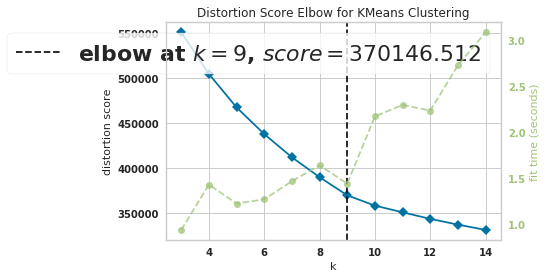

In [46]:
kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/trained_models/SemiSupervisedClassifierMnist.model-1870"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/trained_models/SemiSupervisedClassifierMnist.model-1870"
 
ckpt_name SemiSupervisedClassifierMnist.model-1870
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gau

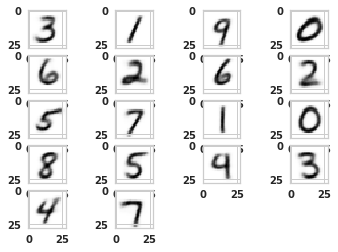

In [48]:
num_clusters = 18
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
tf.reset_default_graph()
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [49]:
import json
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [3, 1, 9, 0,
                                           6, 2, 6, 2,
                                           5,7,1,0,
                                           8,8,-1,3,
                                           4,7
                                          ]
manual_annotation_json["manual_confidence"] = [1,1,1,1,
                                               1,1,1,1,
                                               1,1,1,1,
                                               1,1,0,1,
                                               0.9,1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)

Getting manual_annotation


In [50]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

In [51]:
cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 

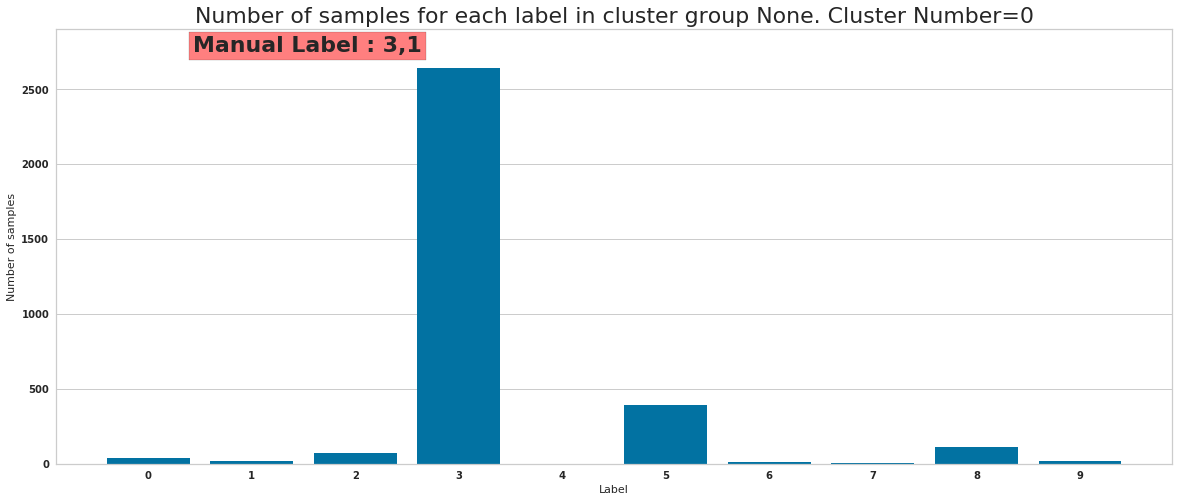

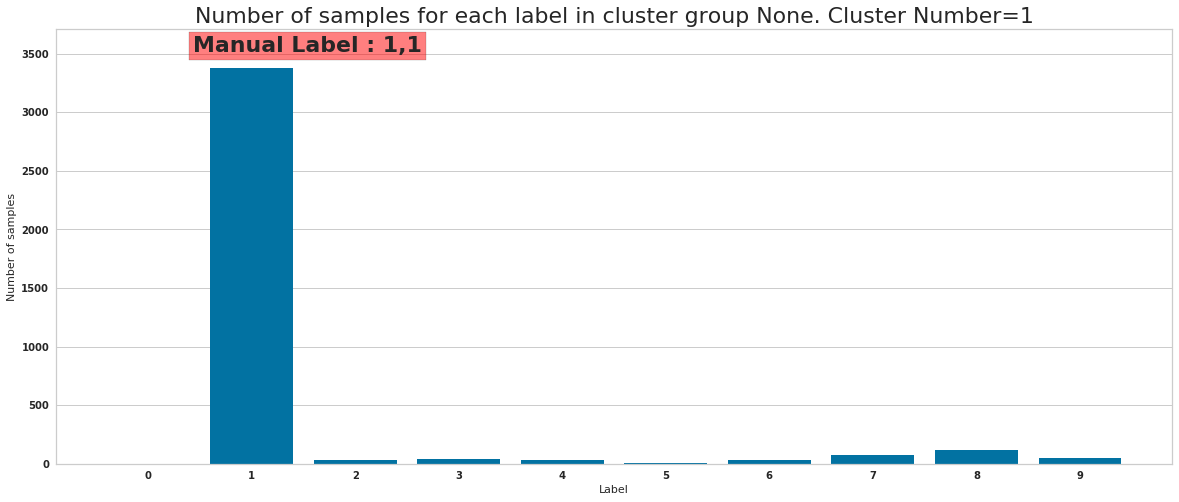

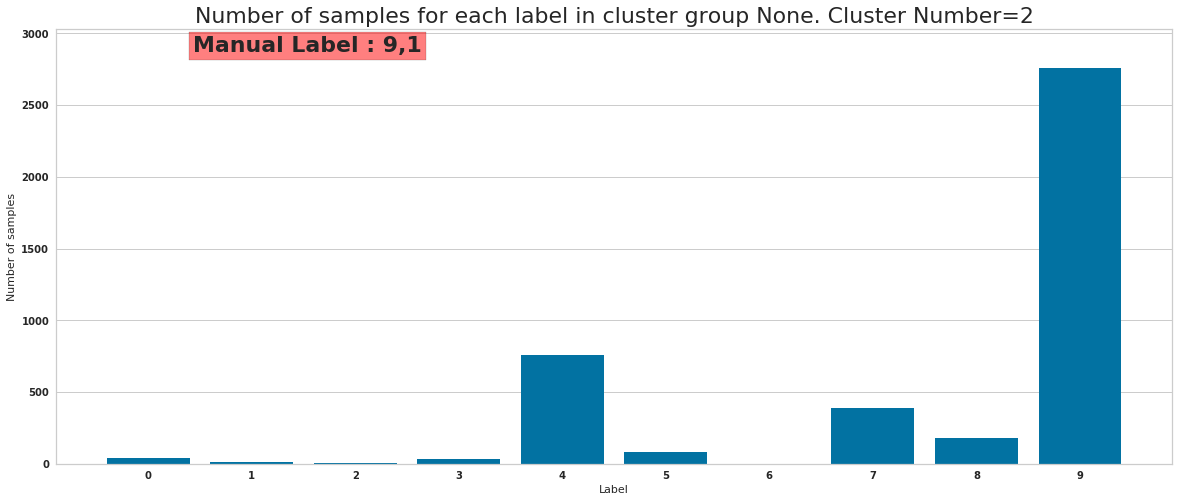

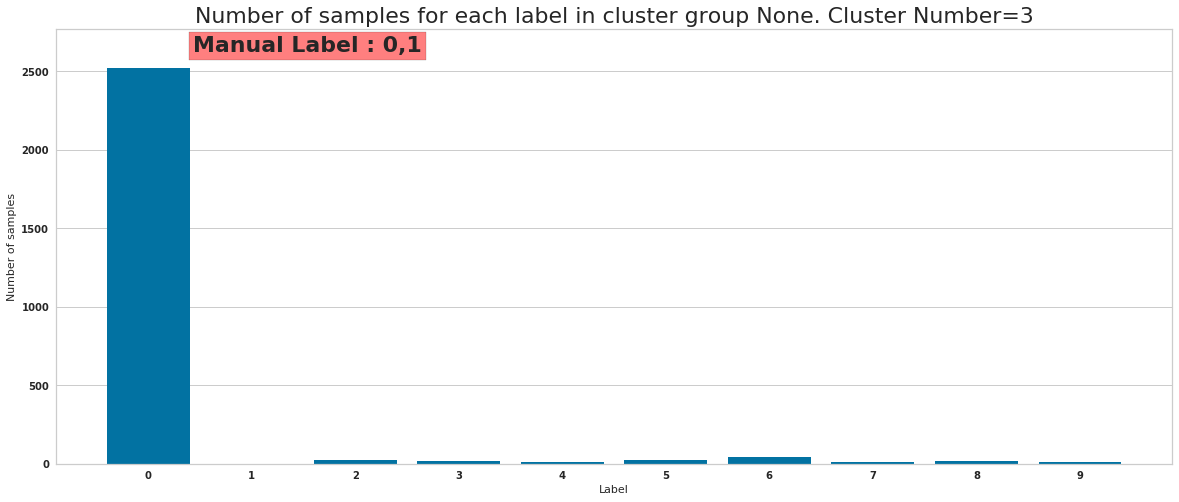

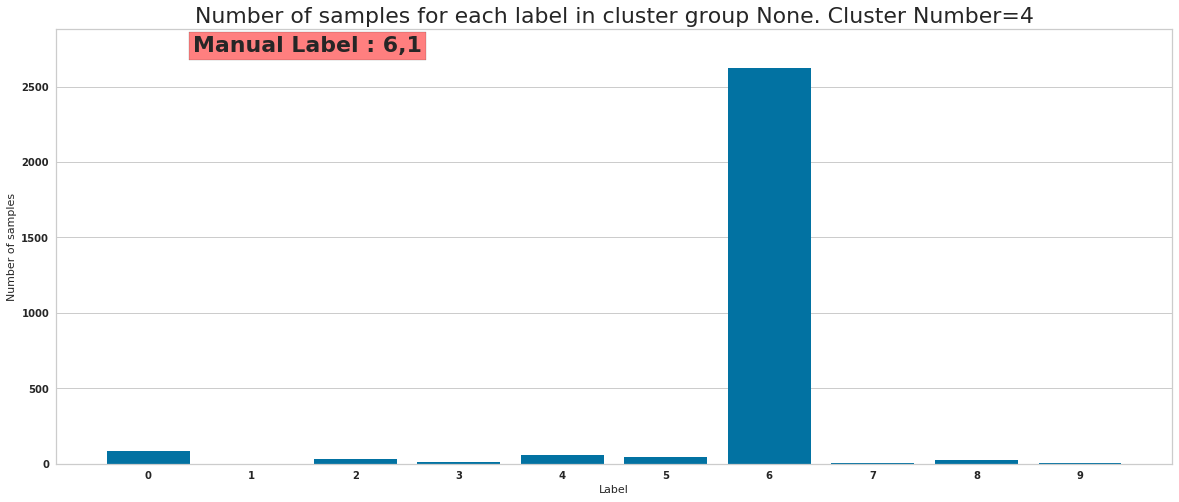

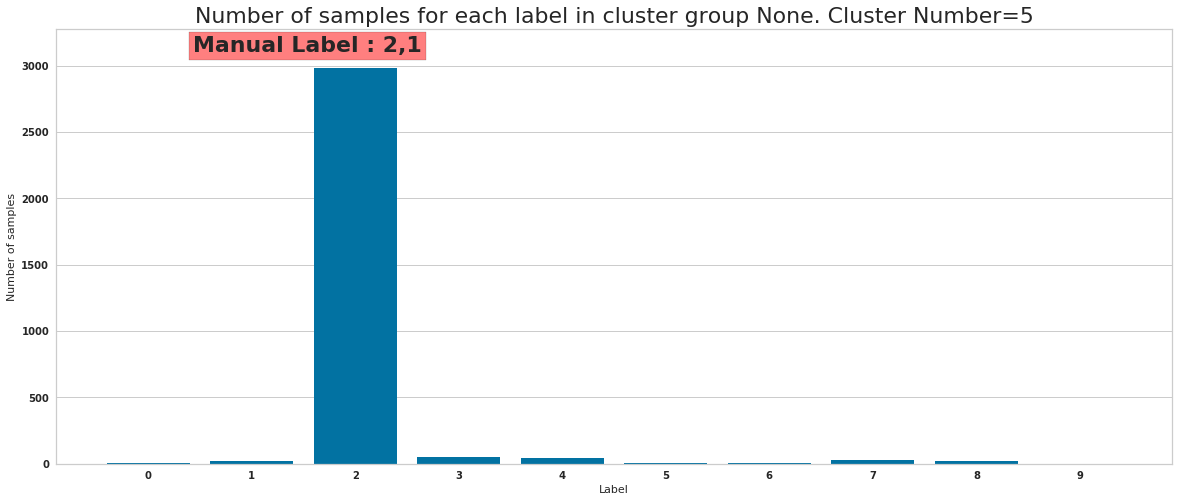

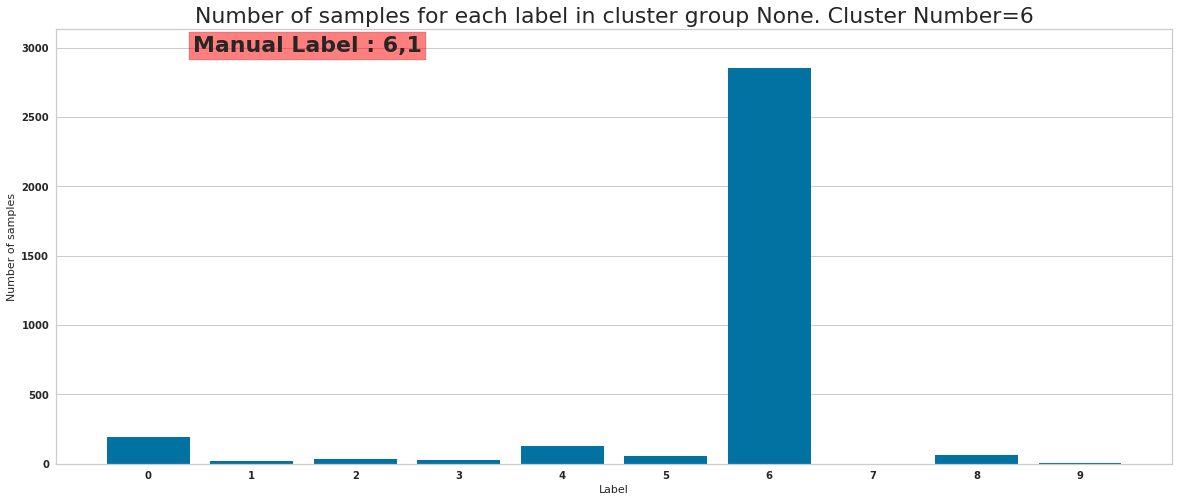

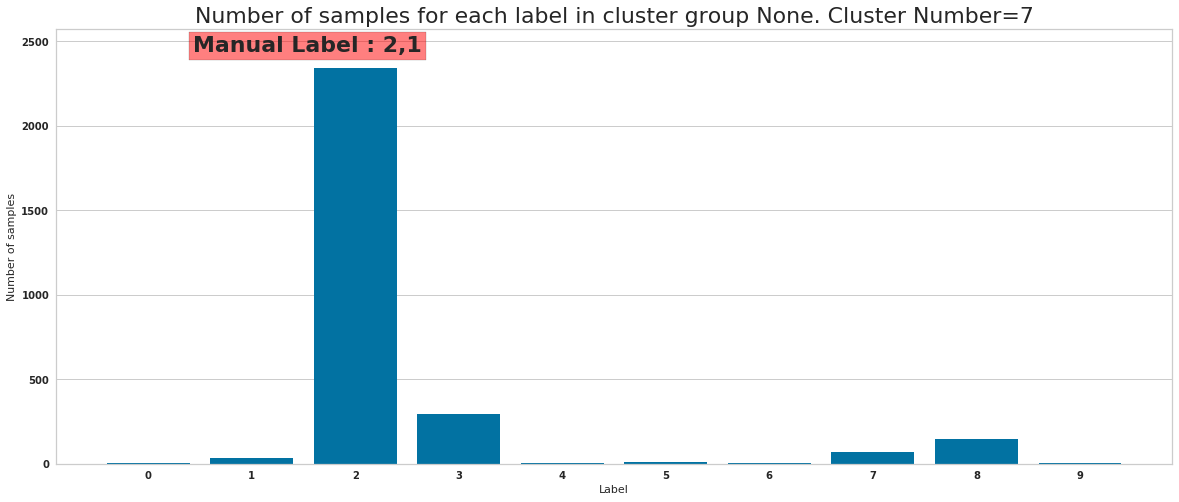

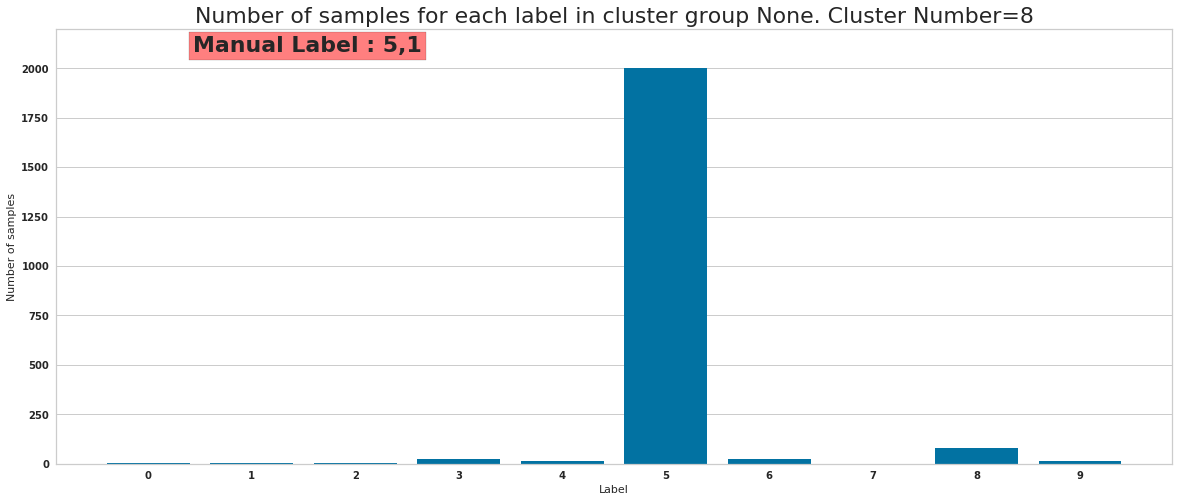

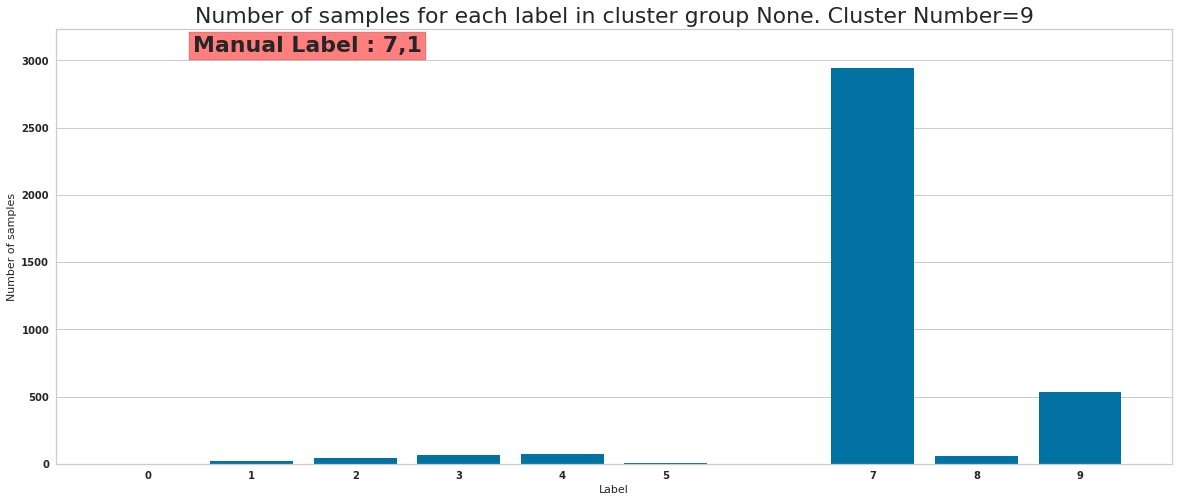

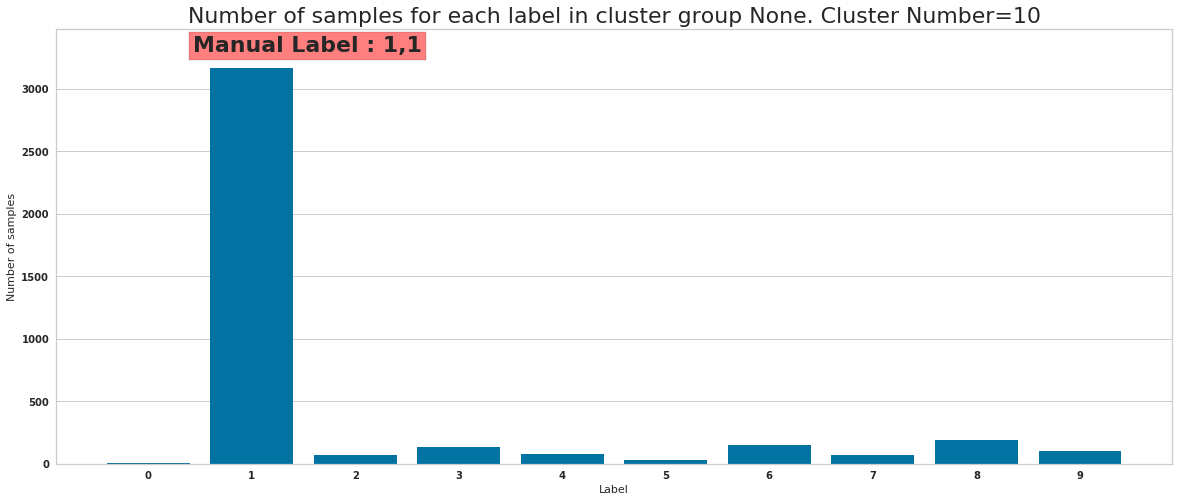

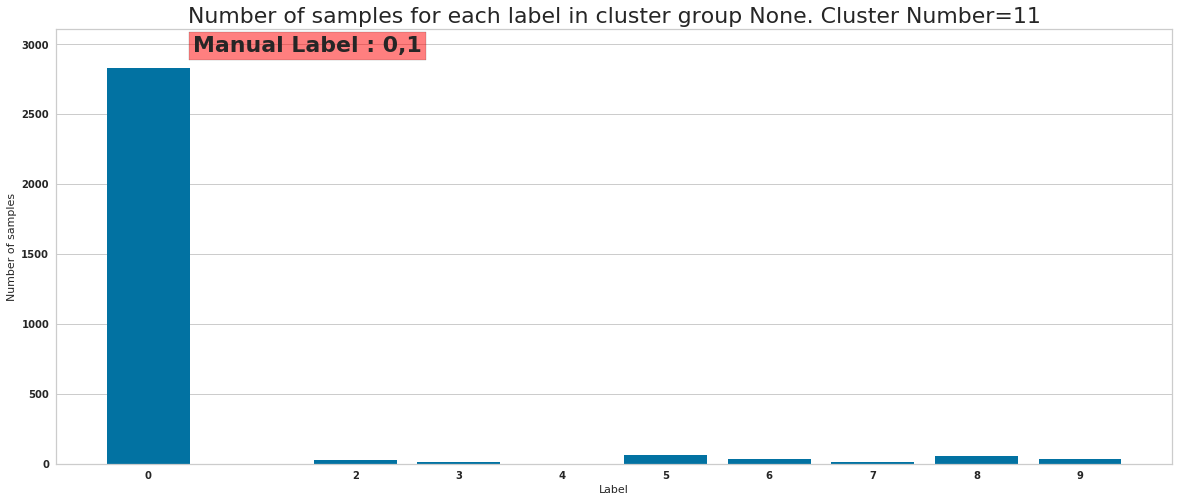

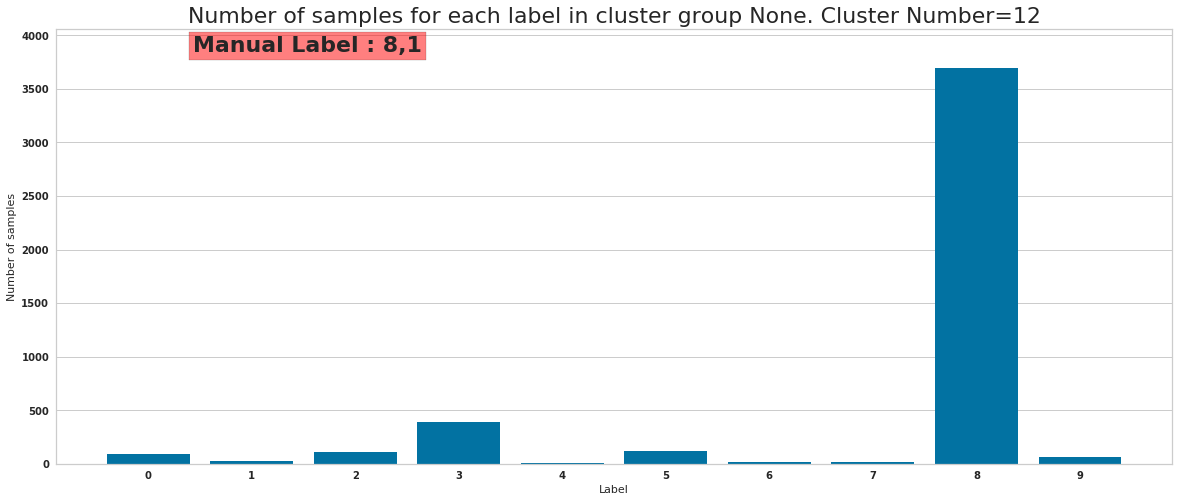

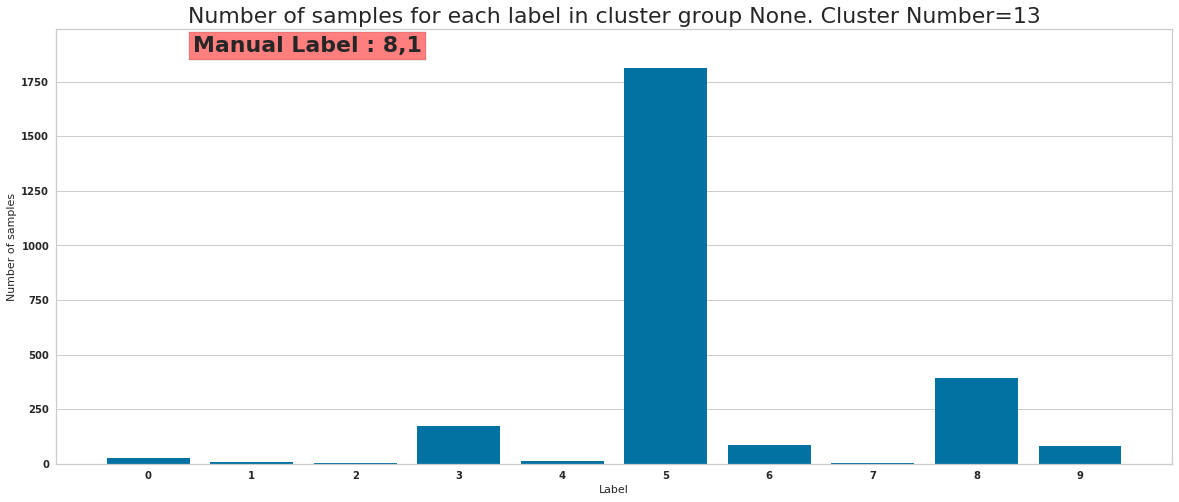

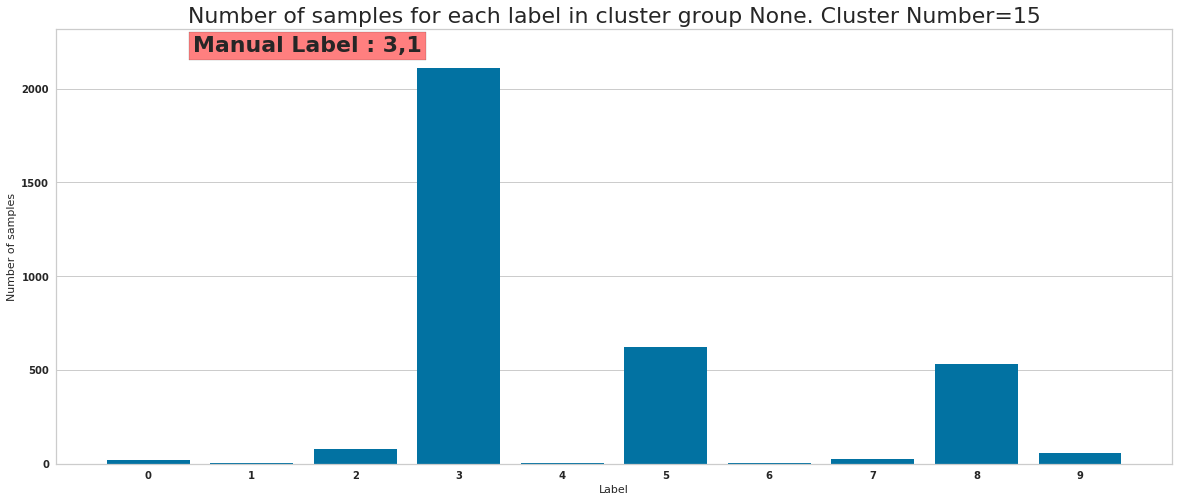

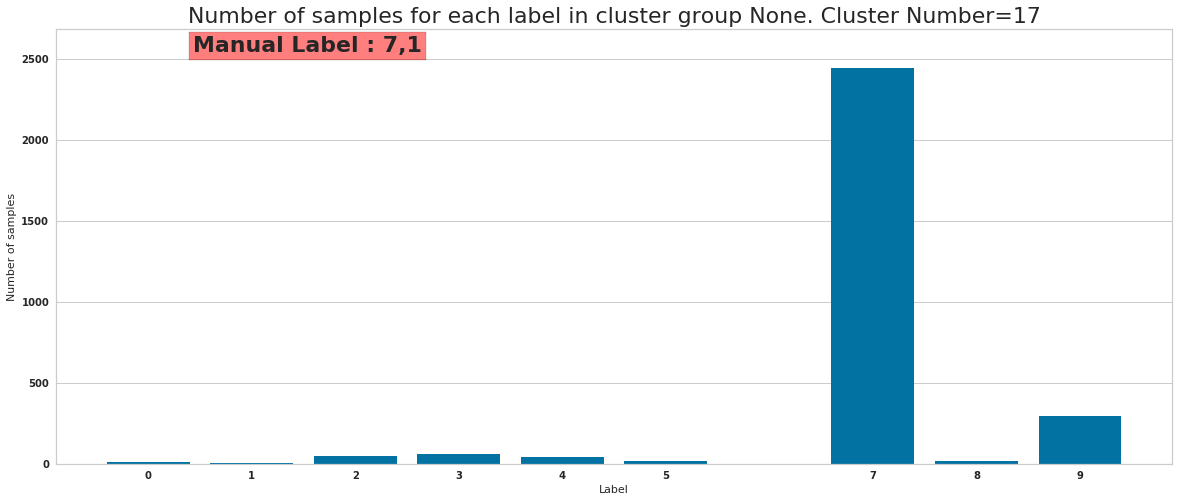

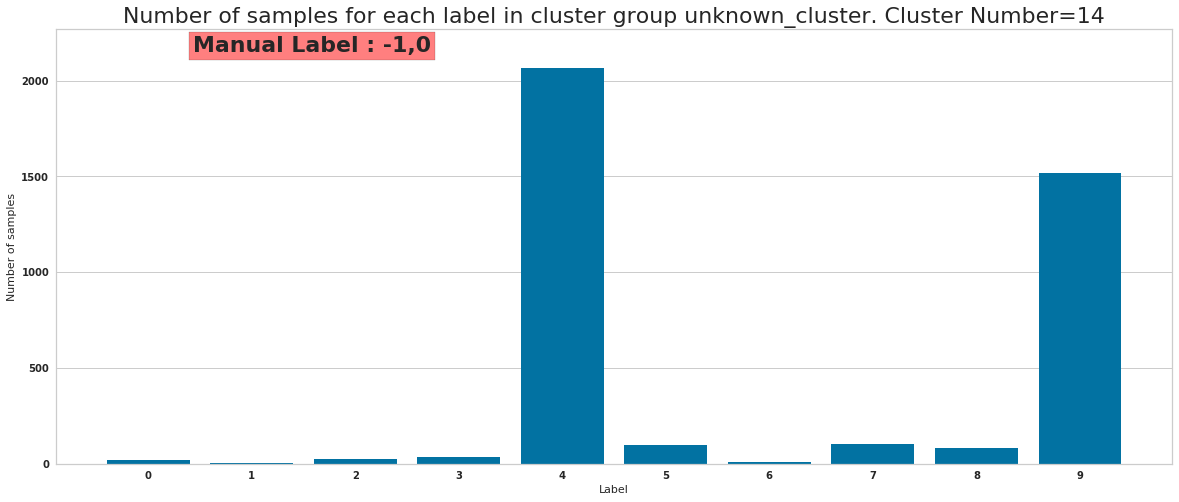

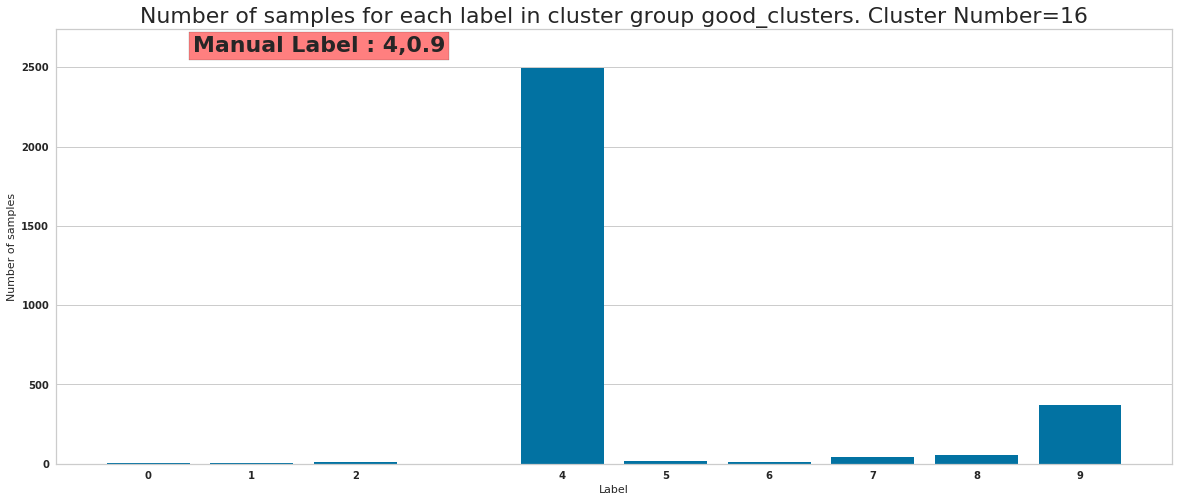

In [52]:
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [53]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

(3309, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(3754, 10)
(4263, 10)
(2682, 10)
(2892, 10)
(3163, 10)
(3381, 10)
(2910, 10)
(2167, 10)
(3741, 10)
(3996, 10)
(3080, 10)
(4540, 10)
(2595, 10)
(3958, 10)
(3458, 10)
(3020, 10)
(2931, 10)


14
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/trained_models/SemiSupervisedClassifierMnist.model-1870"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/trained_models/SemiSupervisedClassifierMnist.model-1870"
 
ckpt_name SemiSupervisedClassifierMnist.model-1870
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


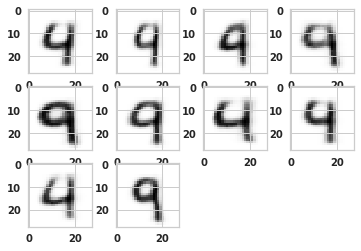

In [54]:
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



In [57]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [4, -1, -1, -1,
                                        9, 9, 4, 4,
                                        4, 9
                                        ]
level_2_cluster_dict["manual_confidences"] = [0.7, 0, 0, 0,
                                             0.8, 0.8, 0.7, 0.7,
                                             0.7, 0.8
                                             ]
level2_manual_annotations[14] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [1,5,-1,-1,
#                                         -1,5,8,-1,
#                                         -1,-1]
# level_2_cluster_dict["manual_confidences"] = [1,0.6,0,0,
#                                              0,0.6,0.6,0,
#                                              0,0]
# level2_manual_annotations[7] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [4,9,9,9,
#                                         4,9,9,9,
#                                         4,9]
# level_2_cluster_dict["manual_confidences"] = [0.8,0.9,0.9,0.9,
#                                               0.8,0.9,0.9,0.9,
#                                               0.8,0.9
#                                              ]
# level2_manual_annotations[6] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [0, -1]
# level_2_cluster_dict["manual_confidences"] = [0.7, 0]
# level2_manual_annotations[14] = level_2_cluster_dict



In [58]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)
    
#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

14
10
0 (469,)
4 (300,)
5 (472,)
6 (342,)
7 (413,)
8 (375,)
9 (428,)
Skipping distance computation for unknown cluster
Manual Label 3
(3309, 65) (3309, 33)
Num correct=2639
Cluster 0 Manual Label 3 Percentage correct 79.75219099425809
********************************
Manual Label 1
(3754, 65) (3754, 33)
Num correct=3373
Cluster 1 Manual Label 1 Percentage correct 89.85082578582845
********************************
Manual Label 9
(4263, 65) (4263, 33)
Num correct=2756
Cluster 2 Manual Label 9 Percentage correct 64.64930799906169
********************************
Manual Label 0
(2682, 65) (2682, 33)
Num correct=2519
Cluster 3 Manual Label 0 Percentage correct 93.92244593586875
********************************
Manual Label 6
(2892, 65) (2892, 33)
Num correct=2620
Cluster 4 Manual Label 6 Percentage correct 90.59474412171508
********************************
Manual Label 2
(3163, 65) (3163, 33)
Num correct=2980
Cluster 5 Manual Label 2 Percentage correct 94.21435346190326
********************

In [59]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

(array([7063., 6945., 6055., 3381., 5077., 7737., 3080., 7135., 7416.,
        5951.]),
 array([ 0. ,  1.7,  3.4,  5.1,  6.8,  8.5, 10.2, 11.9, 13.6, 15.3, 17. ]),
 <a list of 10 Patch objects>)

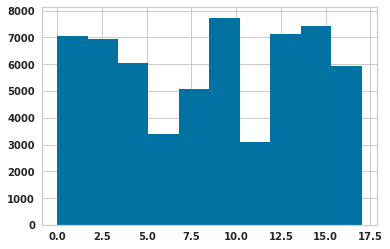

In [60]:
plt.hist(cluster_labels)

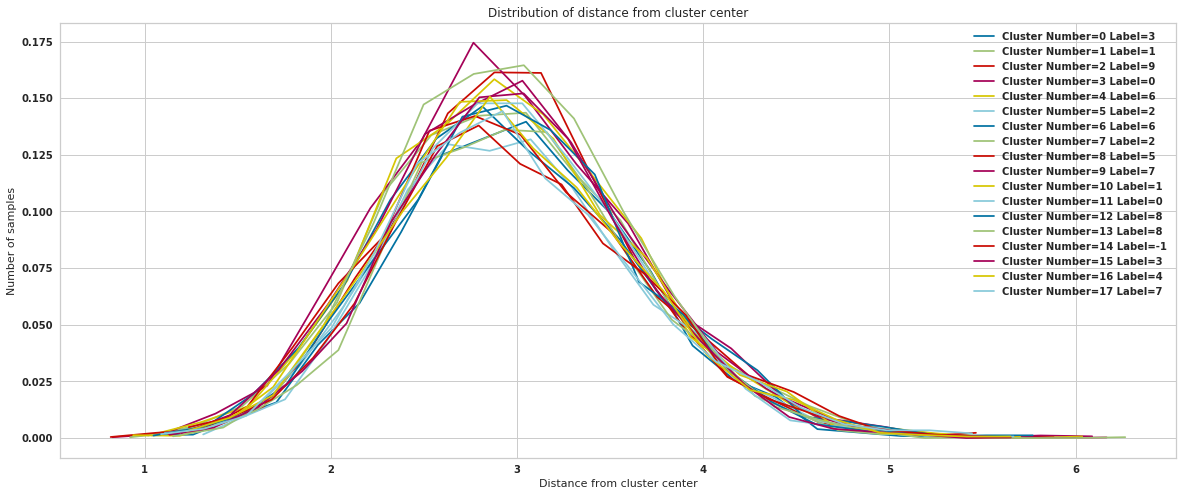

In [61]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

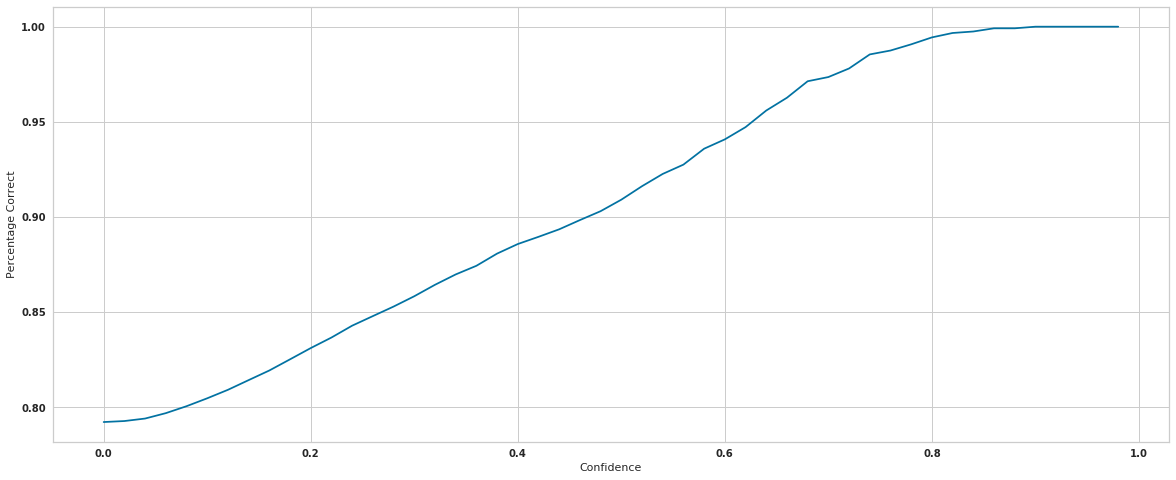

In [62]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

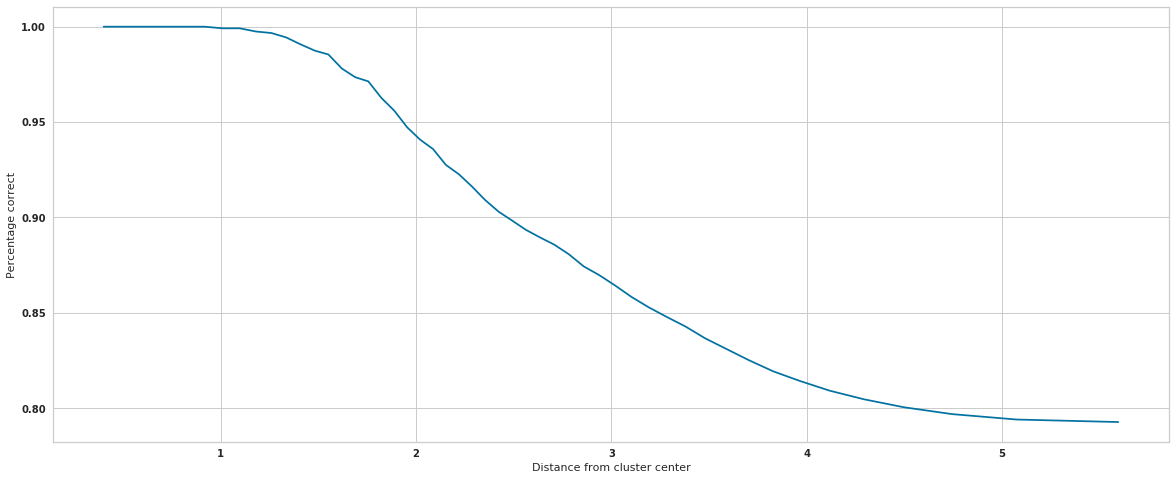

In [63]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

In [64]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

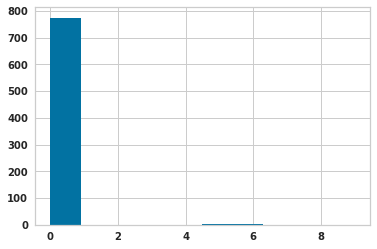

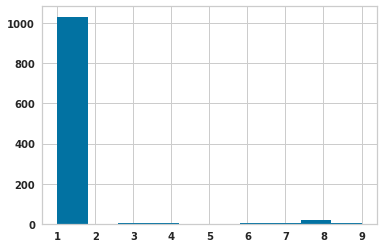

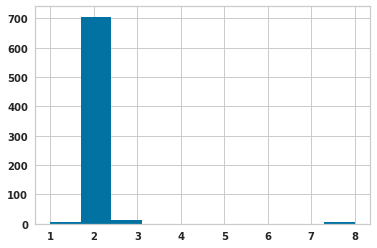

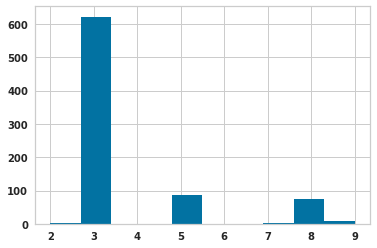

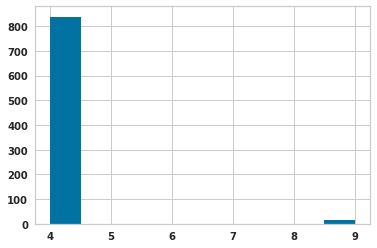

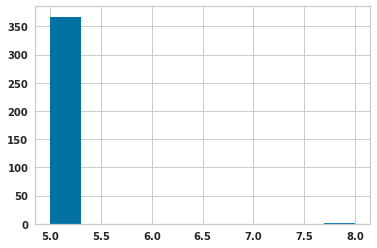

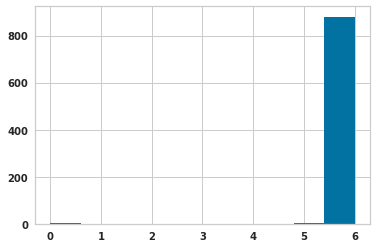

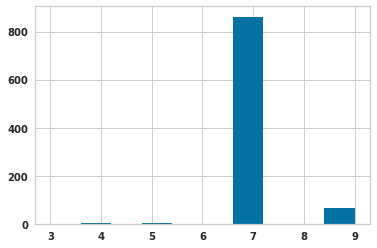

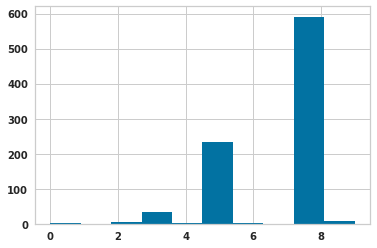

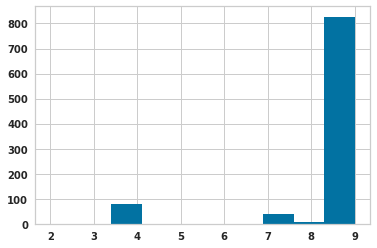

In [65]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# Iteration 3

In [66]:
num_epochs
num_epochs += 1
print(num_epochs)

3


In [67]:
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
print(manual_annotation_file)

manual_annotation_epoch_2.0.csv


In [68]:
#num_epochs += 1
#manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'TWO_TIMES_ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 47, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k8'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 19855.55498174459
INFO:tensorflow:Summary name Negative 

Epoch: 2/60, Nll_loss : 117.21233367919922 KLD:9.759358406066895  Supervised loss:0.15072382986545563
Epoch: 2/61, Nll_loss : 117.27482604980469 KLD:9.984437942504883  Supervised loss:0.1333082616329193
Epoch: 2/62, Nll_loss : 132.25503540039062 KLD:9.958263397216797  Supervised loss:0.17577776312828064
Epoch: 2/63, Nll_loss : 124.86373901367188 KLD:9.747016906738281  Supervised loss:0.1591099500656128
Epoch: 2/64, Nll_loss : 123.17597961425781 KLD:9.173040390014648  Supervised loss:0.13821792602539062
Epoch: 2/65, Nll_loss : 123.1014404296875 KLD:9.886383056640625  Supervised loss:0.1467885971069336
Epoch: 2/66, Nll_loss : 109.46649169921875 KLD:9.280601501464844  Supervised loss:0.12377581745386124
Epoch: 2/67, Nll_loss : 117.51666259765625 KLD:8.607559204101562  Supervised loss:0.16580240428447723
Epoch: 2/68, Nll_loss : 122.91400146484375 KLD:9.136280059814453  Supervised loss:0.22398540377616882
Epoch: 2/69, Nll_loss : 128.51107788085938 KLD:9.313186645507812  Supervised loss:0.18

Epoch: 2/142, Nll_loss : 125.33049774169922 KLD:9.822669982910156  Supervised loss:0.1045449897646904
Epoch: 2/143, Nll_loss : 119.93316650390625 KLD:9.572288513183594  Supervised loss:0.13360179960727692
Epoch: 2/144, Nll_loss : 118.22236633300781 KLD:9.668047904968262  Supervised loss:0.12435471266508102
Epoch: 2/145, Nll_loss : 121.03138732910156 KLD:9.357219696044922  Supervised loss:0.14305609464645386
Epoch: 2/146, Nll_loss : 114.28912353515625 KLD:9.898529052734375  Supervised loss:0.11657701432704926
Epoch: 2/147, Nll_loss : 124.2763442993164 KLD:9.679518699645996  Supervised loss:0.12139075994491577
Epoch: 2/148, Nll_loss : 128.29986572265625 KLD:9.51075267791748  Supervised loss:0.14292164146900177
Epoch: 2/149, Nll_loss : 117.49598693847656 KLD:9.394803047180176  Supervised loss:0.15470075607299805
Epoch: 2/150, Nll_loss : 124.92488861083984 KLD:9.479451179504395  Supervised loss:0.1983698010444641
Epoch: 2/151, Nll_loss : 117.50721740722656 KLD:9.176593780517578  Supervised

Epoch: 2/224, Nll_loss : 126.16421508789062 KLD:9.959874153137207  Supervised loss:0.19294507801532745
Epoch: 2/225, Nll_loss : 124.89183044433594 KLD:9.43247127532959  Supervised loss:0.1199258342385292
Epoch: 2/226, Nll_loss : 121.17474365234375 KLD:9.517459869384766  Supervised loss:0.12531104683876038
Epoch: 2/227, Nll_loss : 125.82554626464844 KLD:9.181593894958496  Supervised loss:0.17402678728103638
Epoch: 2/228, Nll_loss : 128.96304321289062 KLD:9.350265502929688  Supervised loss:0.1668682098388672
Epoch: 2/229, Nll_loss : 118.52035522460938 KLD:9.735371589660645  Supervised loss:0.14470650255680084
Epoch: 2/230, Nll_loss : 124.99986267089844 KLD:9.30496597290039  Supervised loss:0.16468417644500732
Epoch: 2/231, Nll_loss : 123.07820892333984 KLD:9.488937377929688  Supervised loss:0.1898132562637329
Epoch: 2/232, Nll_loss : 116.55728149414062 KLD:9.562847137451172  Supervised loss:0.12804070115089417
Epoch: 2/233, Nll_loss : 118.6136474609375 KLD:9.940580368041992  Supervised l

Epoch: 2/304, Nll_loss : 119.53228759765625 KLD:9.949423789978027  Supervised loss:0.13416975736618042
Epoch: 2/305, Nll_loss : 113.17140197753906 KLD:9.540233612060547  Supervised loss:0.14447401463985443
Epoch: 2/306, Nll_loss : 122.90603637695312 KLD:9.580642700195312  Supervised loss:0.14756464958190918
Epoch: 2/307, Nll_loss : 116.80384826660156 KLD:9.22448444366455  Supervised loss:0.13149860501289368
Epoch: 2/308, Nll_loss : 128.868896484375 KLD:9.385638236999512  Supervised loss:0.14757415652275085
Epoch: 2/309, Nll_loss : 117.5716323852539 KLD:8.921623229980469  Supervised loss:0.1624765843153
Epoch: 2/310, Nll_loss : 129.68472290039062 KLD:8.997356414794922  Supervised loss:0.14988189935684204
Epoch: 2/311, Nll_loss : 130.6951446533203 KLD:8.953679084777832  Supervised loss:0.13372334837913513
Epoch: 2/312, Nll_loss : 124.24797821044922 KLD:9.353033065795898  Supervised loss:0.13206890225410461
Epoch: 2/313, Nll_loss : 125.82902526855469 KLD:8.956250190734863  Supervised loss

Epoch: 2/386, Nll_loss : 123.88137817382812 KLD:9.506216049194336  Supervised loss:0.12477411329746246
Epoch: 2/387, Nll_loss : 122.94171142578125 KLD:9.102703094482422  Supervised loss:0.1676073968410492
Epoch: 2/388, Nll_loss : 119.78241729736328 KLD:9.347152709960938  Supervised loss:0.1174037829041481
Epoch: 2/389, Nll_loss : 117.81759643554688 KLD:9.257957458496094  Supervised loss:0.13522012531757355
Epoch: 2/390, Nll_loss : 123.3072509765625 KLD:9.462101936340332  Supervised loss:0.13297361135482788
Epoch: 2/391, Nll_loss : 112.73251342773438 KLD:9.064094543457031  Supervised loss:0.1672215461730957
Epoch: 2/392, Nll_loss : 117.61295318603516 KLD:9.344049453735352  Supervised loss:0.1879732310771942
Epoch: 2/393, Nll_loss : 124.58880615234375 KLD:9.472994804382324  Supervised loss:0.14438453316688538
Epoch: 2/394, Nll_loss : 121.51668548583984 KLD:9.467329025268555  Supervised loss:0.13512369990348816
Epoch: 2/395, Nll_loss : 120.23957061767578 KLD:9.09853744506836  Supervised l

Epoch: 2/468, Nll_loss : 123.46206665039062 KLD:9.374652862548828  Supervised loss:0.1890796422958374
Epoch: 2/469, Nll_loss : 117.78411865234375 KLD:9.384071350097656  Supervised loss:0.2301957756280899
Epoch: 2/470, Nll_loss : 115.36254119873047 KLD:9.596946716308594  Supervised loss:0.11192907392978668
Epoch: 2/471, Nll_loss : 117.33915710449219 KLD:9.594549179077148  Supervised loss:0.1270437240600586
Epoch: 2/472, Nll_loss : 120.55992126464844 KLD:9.422633171081543  Supervised loss:0.16039589047431946
Epoch: 2/473, Nll_loss : 116.5009536743164 KLD:9.859835624694824  Supervised loss:0.17143796384334564
Epoch: 2/474, Nll_loss : 118.14889526367188 KLD:9.658365249633789  Supervised loss:0.10326623171567917
Epoch: 2/475, Nll_loss : 119.8393325805664 KLD:9.794540405273438  Supervised loss:0.13541960716247559
Epoch: 2/476, Nll_loss : 115.49247741699219 KLD:10.009072303771973  Supervised loss:0.11299629509449005
Epoch: 2/477, Nll_loss : 118.52334594726562 KLD:9.556228637695312  Supervised

Epoch: 2/549, Nll_loss : 116.59823608398438 KLD:9.433477401733398  Supervised loss:0.10580223798751831
Epoch: 2/550, Nll_loss : 114.99895477294922 KLD:9.457221984863281  Supervised loss:0.15198004245758057
Epoch: 2/551, Nll_loss : 122.21505737304688 KLD:9.102914810180664  Supervised loss:0.14754775166511536
Epoch: 2/552, Nll_loss : 111.44654846191406 KLD:8.669443130493164  Supervised loss:0.11268603801727295
Epoch: 2/553, Nll_loss : 125.49247741699219 KLD:8.96546459197998  Supervised loss:0.14764490723609924
Epoch: 2/554, Nll_loss : 123.34259033203125 KLD:8.668455123901367  Supervised loss:0.15122653543949127
Epoch: 2/555, Nll_loss : 123.23457336425781 KLD:9.305807113647461  Supervised loss:0.1931779533624649
Epoch: 2/556, Nll_loss : 126.391845703125 KLD:9.394946098327637  Supervised loss:0.16518718004226685
Epoch: 2/557, Nll_loss : 119.78633117675781 KLD:9.513988494873047  Supervised loss:0.11739456653594971
Epoch: 2/558, Nll_loss : 118.64840698242188 KLD:9.506053924560547  Supervised

Epoch: 2/630, Nll_loss : 121.552978515625 KLD:9.0179443359375  Supervised loss:0.11848211288452148
Epoch: 2/631, Nll_loss : 115.77050018310547 KLD:8.934755325317383  Supervised loss:0.13656112551689148
Epoch: 2/632, Nll_loss : 115.08865356445312 KLD:8.899202346801758  Supervised loss:0.14006361365318298
Epoch: 2/633, Nll_loss : 116.89403533935547 KLD:9.023266792297363  Supervised loss:0.12196636199951172
Epoch: 2/634, Nll_loss : 119.04263305664062 KLD:9.132146835327148  Supervised loss:0.1716669201850891
Epoch: 2/635, Nll_loss : 120.53076171875 KLD:9.569968223571777  Supervised loss:0.148473858833313
Epoch: 2/636, Nll_loss : 117.50341796875 KLD:9.662330627441406  Supervised loss:0.1281944364309311
Epoch: 2/637, Nll_loss : 109.91133117675781 KLD:9.381891250610352  Supervised loss:0.1354670226573944
Epoch: 2/638, Nll_loss : 119.40776062011719 KLD:9.22920036315918  Supervised loss:0.16565538942813873
Epoch: 2/639, Nll_loss : 129.9996795654297 KLD:9.373603820800781  Supervised loss:0.19043

Epoch: 2/712, Nll_loss : 124.96822357177734 KLD:9.276355743408203  Supervised loss:0.1690632700920105
Epoch: 2/713, Nll_loss : 120.3602066040039 KLD:9.275004386901855  Supervised loss:0.17634791135787964
Epoch: 2/714, Nll_loss : 112.29499053955078 KLD:9.883070945739746  Supervised loss:0.10901040583848953
Epoch: 2/715, Nll_loss : 120.13449096679688 KLD:9.31210708618164  Supervised loss:0.17158415913581848
Epoch: 2/716, Nll_loss : 114.2029800415039 KLD:9.697763442993164  Supervised loss:0.1145167276263237
Epoch: 2/717, Nll_loss : 120.95133972167969 KLD:10.1939058303833  Supervised loss:0.12894877791404724
Epoch: 2/718, Nll_loss : 112.34672546386719 KLD:9.483570098876953  Supervised loss:0.13233257830142975
Epoch: 2/719, Nll_loss : 119.6478271484375 KLD:9.344441413879395  Supervised loss:0.16758137941360474
Epoch: 2/720, Nll_loss : 114.69015502929688 KLD:9.503761291503906  Supervised loss:0.16214272379875183
Epoch: 2/721, Nll_loss : 118.74304962158203 KLD:9.553610801696777  Supervised lo

Epoch: 2/794, Nll_loss : 119.82547760009766 KLD:9.666694641113281  Supervised loss:0.12021684646606445
Epoch: 2/795, Nll_loss : 115.84506225585938 KLD:9.580486297607422  Supervised loss:0.14711323380470276
Epoch: 2/796, Nll_loss : 123.74281311035156 KLD:9.801308631896973  Supervised loss:0.10302047431468964
Epoch: 2/797, Nll_loss : 122.18763732910156 KLD:9.457134246826172  Supervised loss:0.10546424984931946
Epoch: 2/798, Nll_loss : 117.94892883300781 KLD:9.043996810913086  Supervised loss:0.1631961166858673
Epoch: 2/799, Nll_loss : 124.65078735351562 KLD:9.633218765258789  Supervised loss:0.1675906479358673
Epoch: 2/800, Nll_loss : 120.09848022460938 KLD:9.468839645385742  Supervised loss:0.14034077525138855
Epoch: 2/801, Nll_loss : 115.0225830078125 KLD:9.082983016967773  Supervised loss:0.16208431124687195
Epoch: 2/802, Nll_loss : 116.24119567871094 KLD:9.526307106018066  Supervised loss:0.14030295610427856
Epoch: 2/803, Nll_loss : 117.79646301269531 KLD:8.847203254699707  Supervise

Epoch: 2/875, Nll_loss : 117.01780700683594 KLD:9.594822883605957  Supervised loss:0.1732533872127533
Epoch: 2/876, Nll_loss : 117.55213928222656 KLD:9.209358215332031  Supervised loss:0.13723953068256378
Epoch: 2/877, Nll_loss : 118.73238372802734 KLD:9.400988578796387  Supervised loss:0.11065806448459625
Epoch: 2/878, Nll_loss : 130.9598388671875 KLD:9.392394065856934  Supervised loss:0.14560164511203766
Epoch: 2/879, Nll_loss : 111.7542724609375 KLD:9.386455535888672  Supervised loss:0.10433539748191833
Epoch: 2/880, Nll_loss : 115.32038879394531 KLD:9.123435020446777  Supervised loss:0.1254713535308838
Epoch: 2/881, Nll_loss : 120.71235656738281 KLD:9.316051483154297  Supervised loss:0.12047939747571945
Epoch: 2/882, Nll_loss : 118.35436248779297 KLD:9.171340942382812  Supervised loss:0.17786414921283722
Epoch: 2/883, Nll_loss : 110.36833190917969 KLD:9.152828216552734  Supervised loss:0.10032269358634949
Epoch: 2/884, Nll_loss : 121.04247283935547 KLD:9.557310104370117  Supervised

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/trained_models/SemiSupervisedClassifierMnist.model-2805"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_TWO_TIMES_ELBOW_47/trained_models/SemiSupervisedClassifierMnist.model-2805"
 
ckpt_name SemiSupervisedClassifierMnist.model-2805
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gau

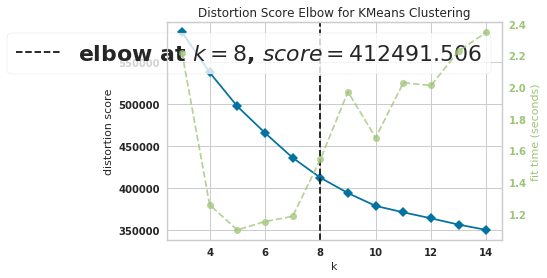

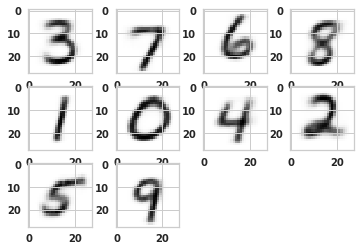

In [69]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [70]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [3,7,6,8,
                                           1,0,4,2,
                                           5,9
                                          ]
manual_annotation_json["manual_confidence"] = [1,1,1,1,
                                               1, 1, 0.8, 1,
                                               1, 0.8
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    


Getting manual_annotation


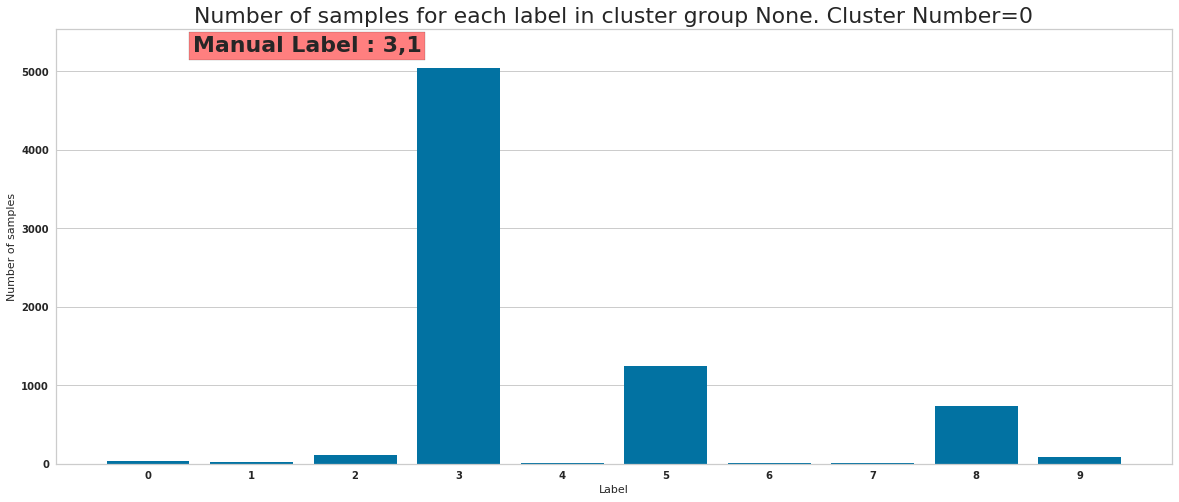

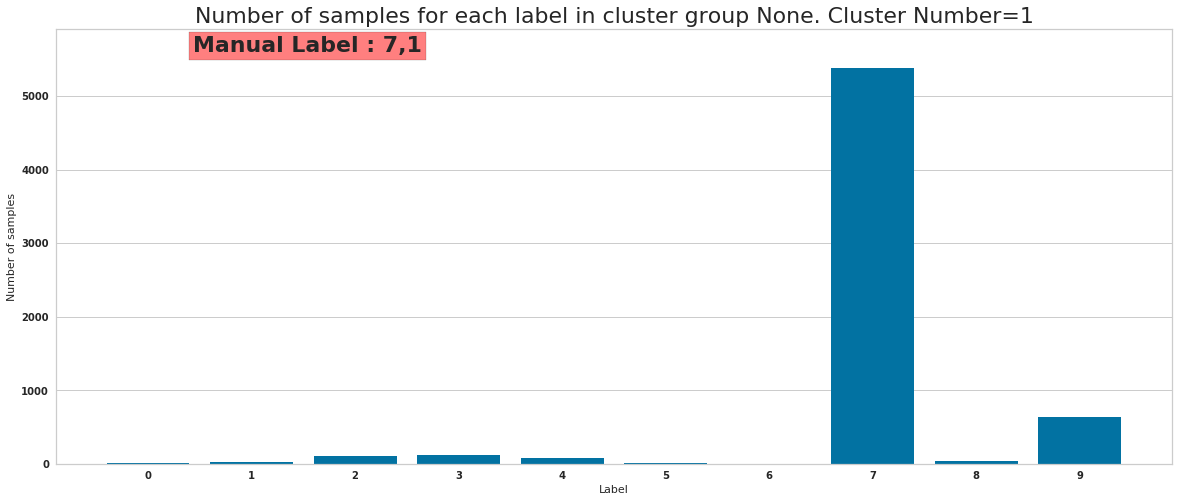

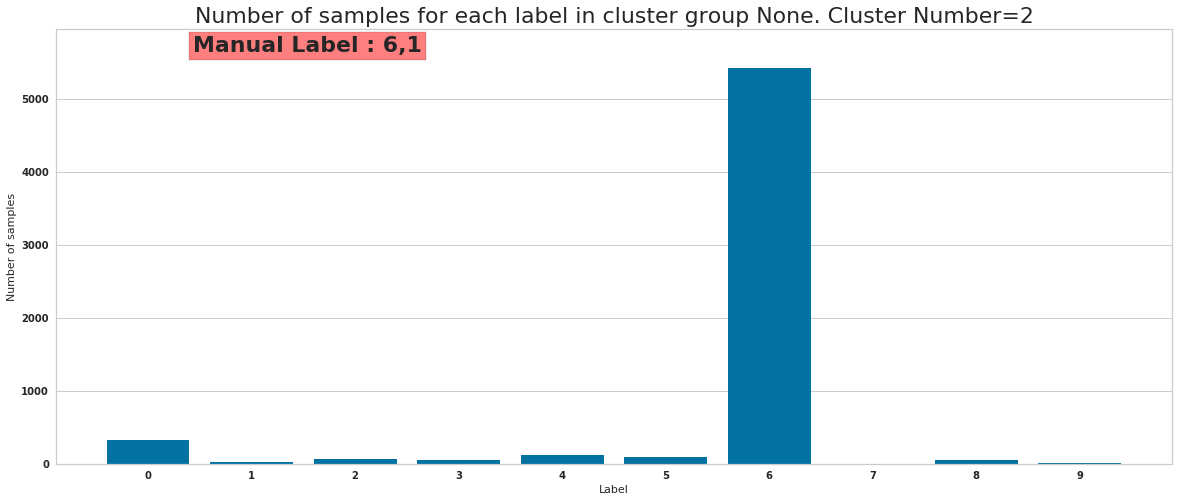

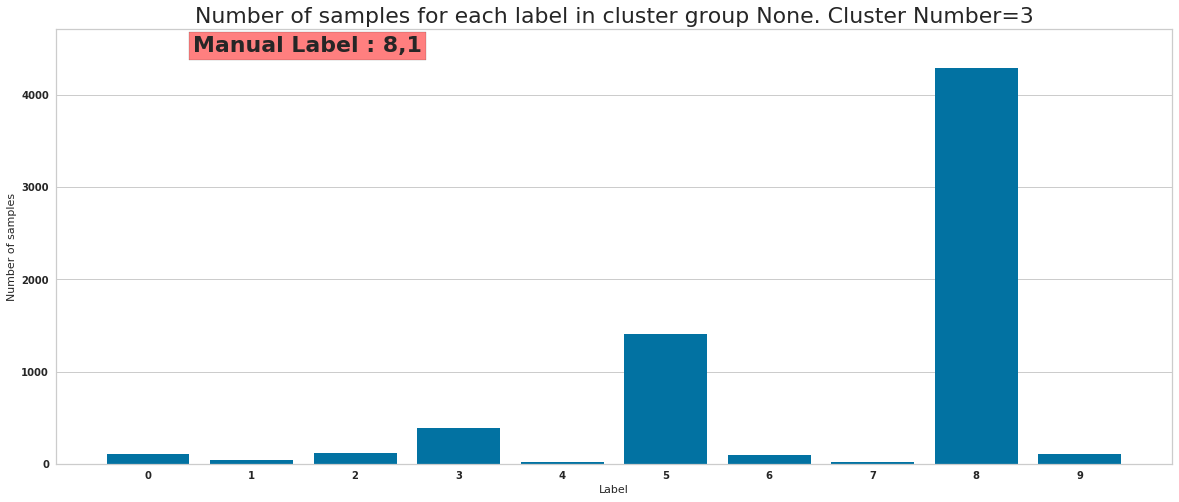

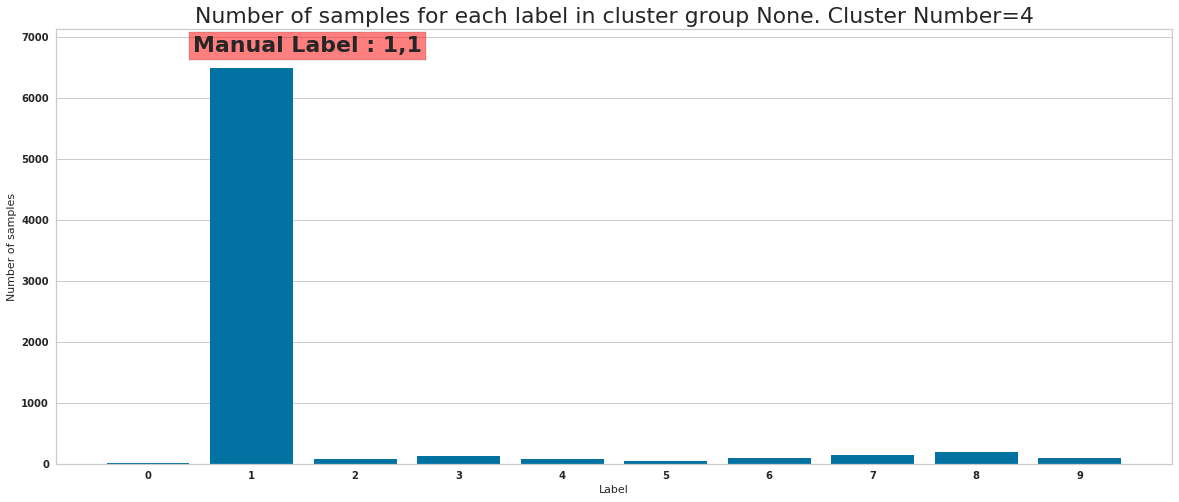

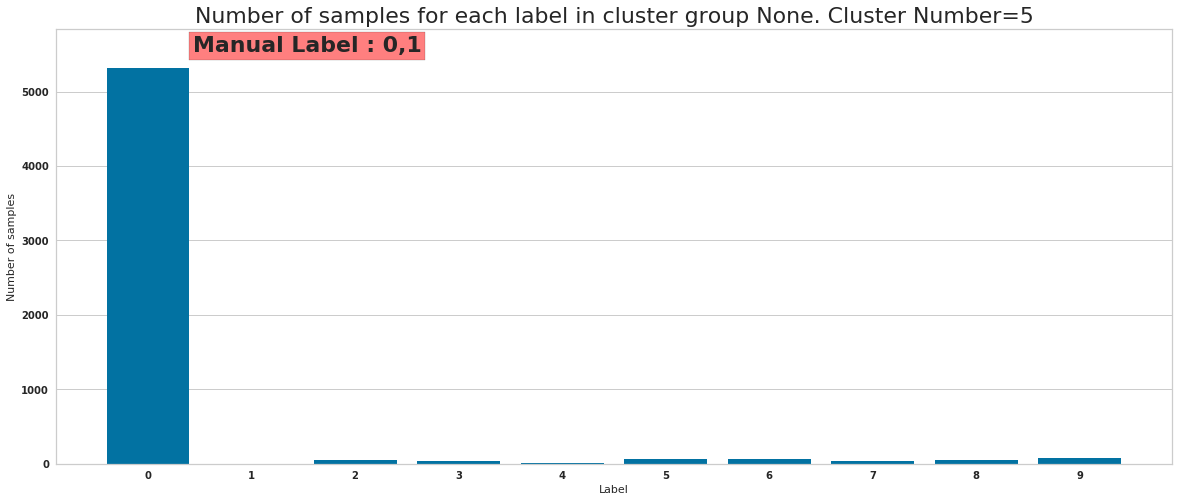

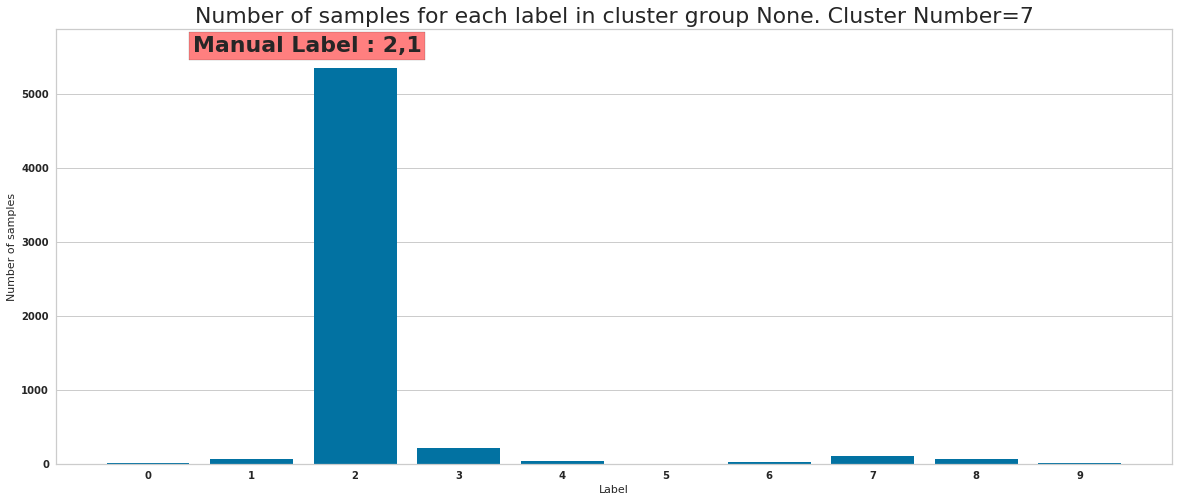

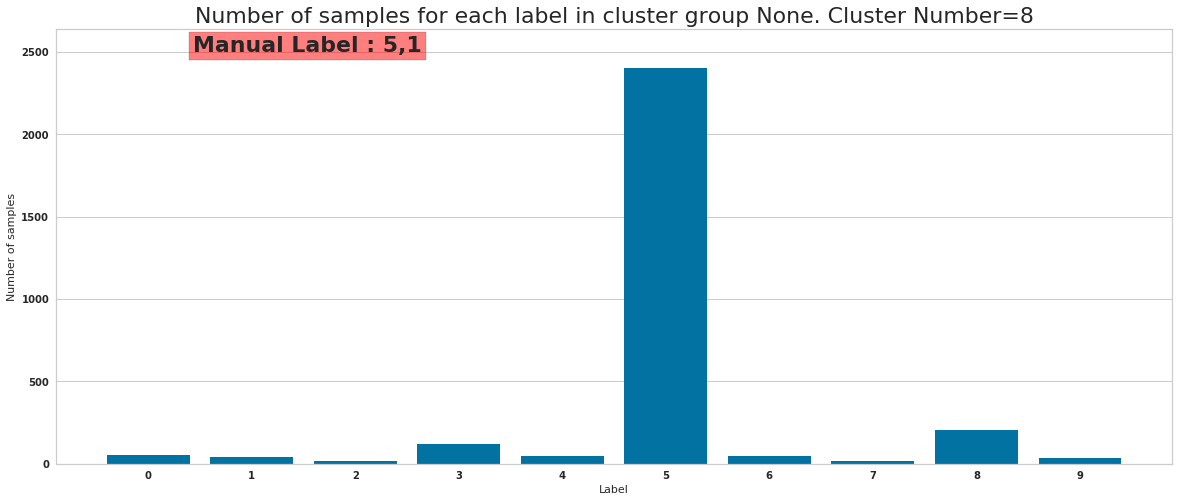

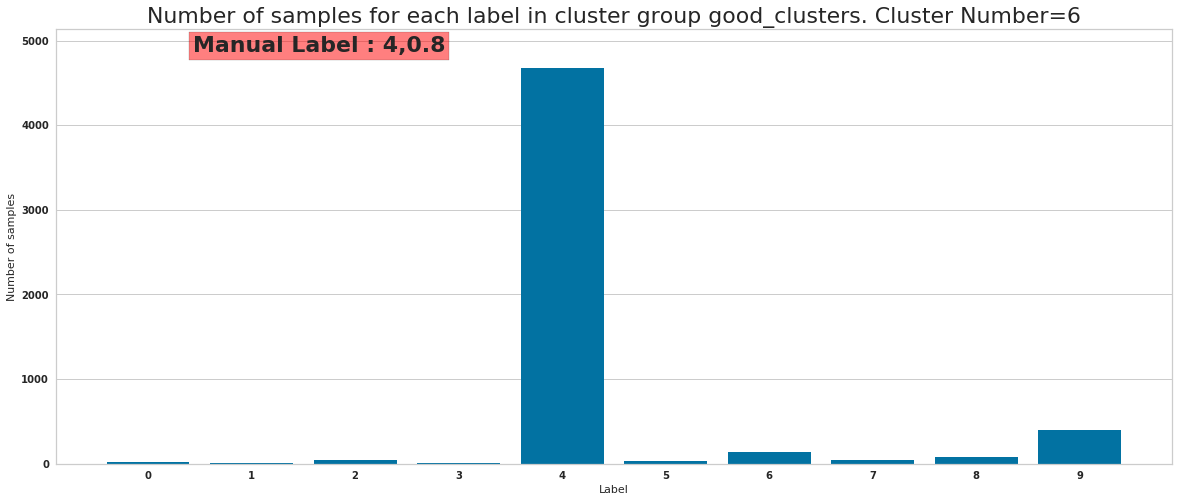

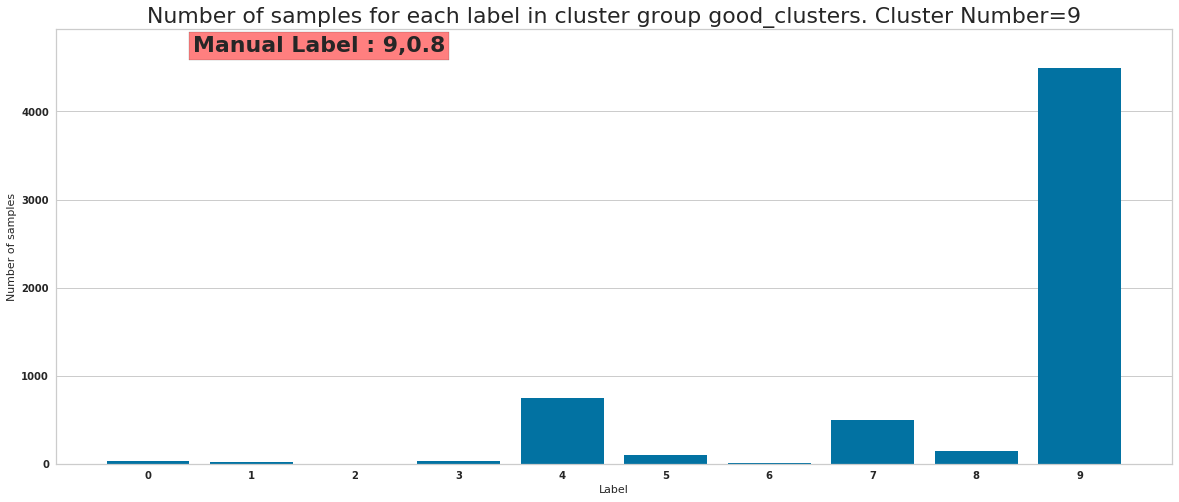

In [71]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [72]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



(7296, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(6394, 10)
(6172, 10)
(6566, 10)
(7336, 10)
(5696, 10)
(5449, 10)
(5870, 10)
(2996, 10)
(6065, 10)


In [73]:
# level2_manual_annotations =dict()

# #TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [4,-1,-1,7,
#                                          4,4,9,-1,
#                                          -1,9
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [0.7,0,0,0.6,
#                                              0.8,0.8,0.9,0,
#                                              0,0.9]
# level2_manual_annotations[1] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [1,-1,-1,5,
#                                         1,1,8,-1,
#                                         -1,-1
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [1,0,0,0.7,
#                                              1,1,0.8,0,
#                                              0,0]
# level2_manual_annotations[2] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0,0]
# # level2_manual_annotations[9] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0, 0]
# # level2_manual_annotations[13] = level_2_cluster_dict



In [74]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 3
(7296, 47) (7296, 33)
Num correct=5036
Cluster 0 Manual Label 3 Percentage correct 69.02412280701755
********************************
Manual Label 7
(6394, 47) (6394, 33)
Num correct=5376
Cluster 1 Manual Label 7 Percentage correct 84.07882389740382
********************************
Manual Label 6
(6172, 47) (6172, 33)
Num correct=5414
Cluster 2 Manual Label 6 Percentage correct 87.71872974724563
********************************
Manual Label 8
(6566, 47) (6566, 33)
Num correct=4285
Cluster 3 Manual Label 8 Percentage correct 65.26043253122144
********************************
Manual Label 1
(7336, 47) (7336, 33)
Num correct=6477
Cluster 4 Manual Label 1 Percentage correct 88.29062159214831
********************************
Manual Label 0
(5696, 47) (5696, 33)
Num correct=5310
Cluster 5 Manual Label 0 Percentage correct 93.22331460674157
********************************
Manual Label 4
(5449, 47) (5449, 33)
Num correct=4670
Cluster 6 Manual Label 4 Percentage correct 85.70379

In [75]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

In [76]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

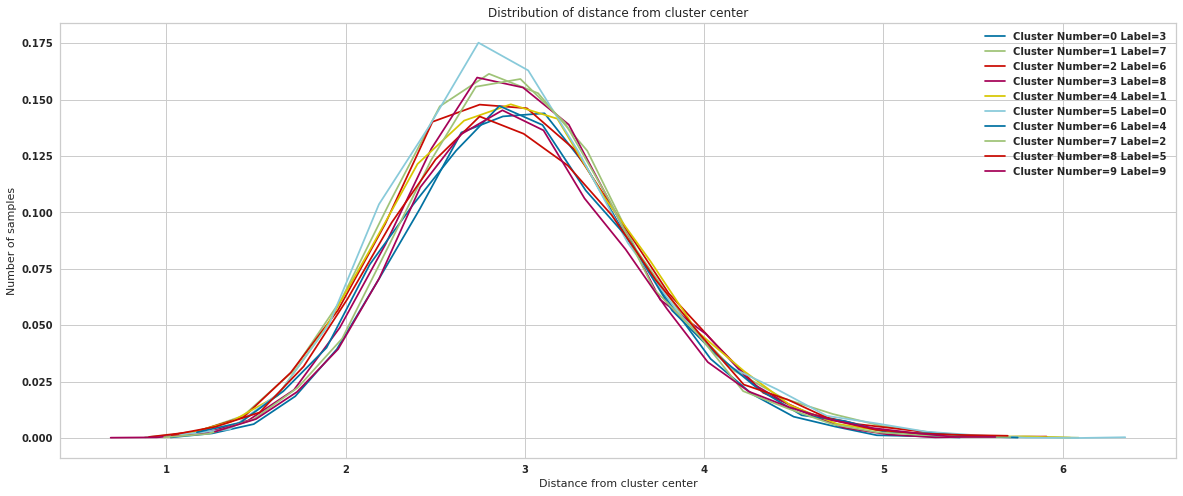

In [77]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

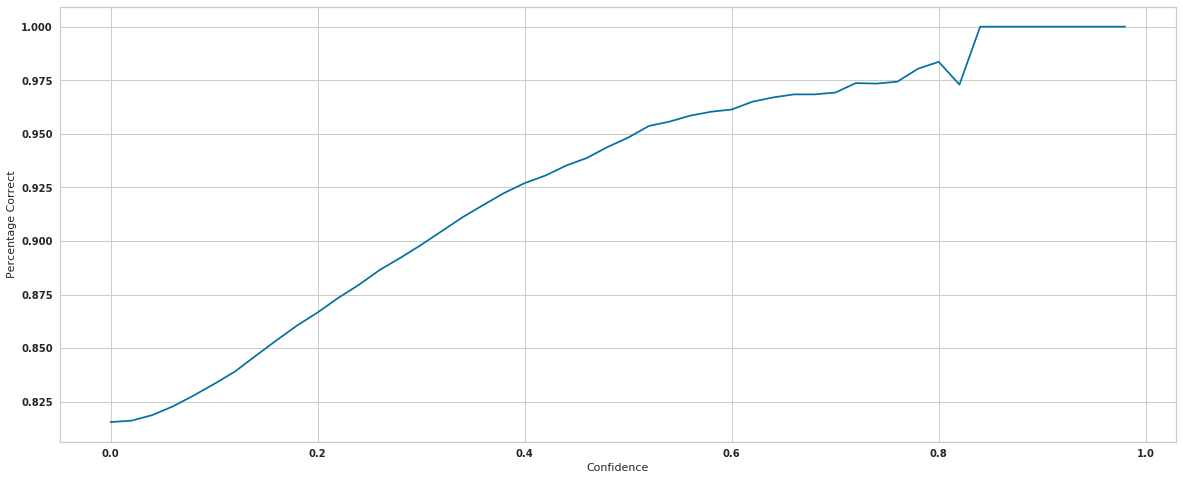

In [78]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

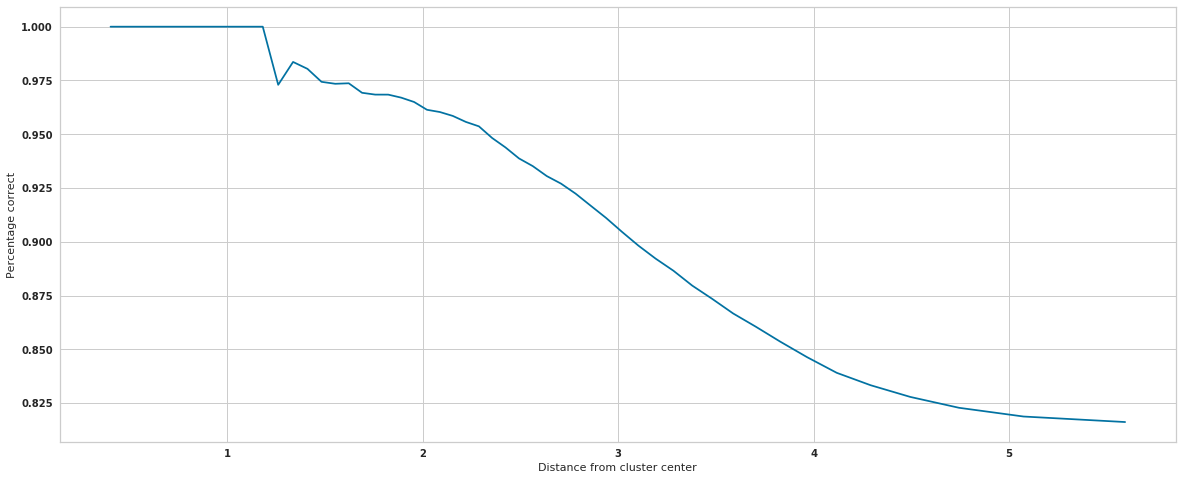

In [79]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

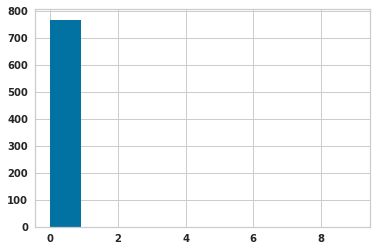

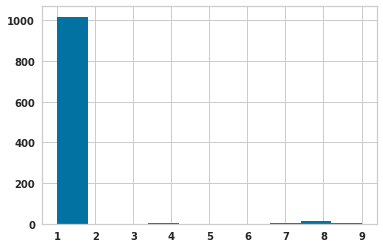

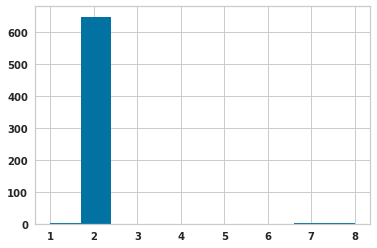

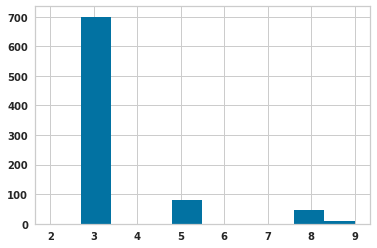

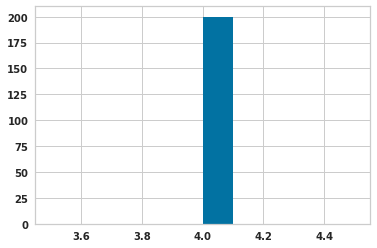

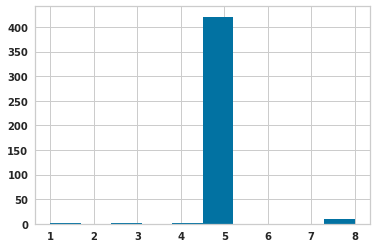

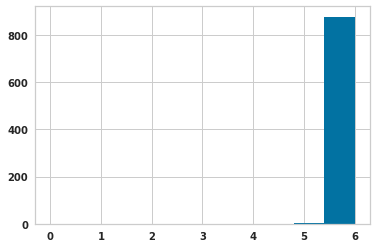

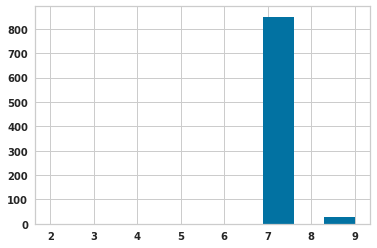

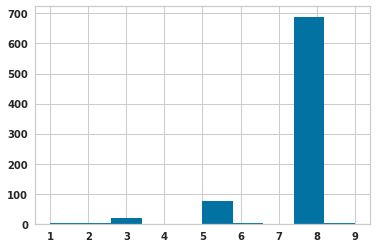

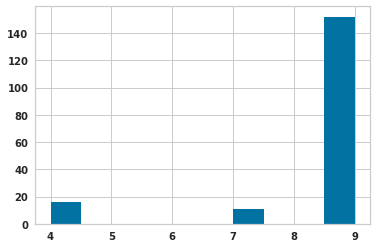

In [80]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# Iteration 4

In [81]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'TWO_TIMES_ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 47, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k8'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 18675.368204853865
INFO:tensorflow:Summary name Negative

Epoch: 3/61, Nll_loss : 115.82124328613281 KLD:9.070036888122559  Supervised loss:0.10941442102193832
Epoch: 3/62, Nll_loss : 127.05013275146484 KLD:9.449865341186523  Supervised loss:0.07127677649259567
Epoch: 3/63, Nll_loss : 121.07665252685547 KLD:9.312044143676758  Supervised loss:0.11546754837036133
Epoch: 3/64, Nll_loss : 116.11294555664062 KLD:9.026857376098633  Supervised loss:0.08965965360403061
Epoch: 3/65, Nll_loss : 122.99421691894531 KLD:9.4822998046875  Supervised loss:0.1144673228263855
Epoch: 3/66, Nll_loss : 106.16404724121094 KLD:9.136500358581543  Supervised loss:0.09340189397335052
Epoch: 3/67, Nll_loss : 116.39520263671875 KLD:8.769403457641602  Supervised loss:0.12221696972846985
Epoch: 3/68, Nll_loss : 119.02741241455078 KLD:9.116923332214355  Supervised loss:0.10193467140197754
Epoch: 3/69, Nll_loss : 123.59257507324219 KLD:9.312301635742188  Supervised loss:0.09515455365180969
Epoch: 3/70, Nll_loss : 116.85031127929688 KLD:9.087750434875488  Supervised loss:0.0

Epoch: 3/143, Nll_loss : 116.94447326660156 KLD:9.304027557373047  Supervised loss:0.10017003118991852
Epoch: 3/144, Nll_loss : 115.4597396850586 KLD:9.486562728881836  Supervised loss:0.08031454682350159
Epoch: 3/145, Nll_loss : 119.85591125488281 KLD:9.32876205444336  Supervised loss:0.1346524953842163
Epoch: 3/146, Nll_loss : 115.43479919433594 KLD:9.617774963378906  Supervised loss:0.08783192187547684
Epoch: 3/147, Nll_loss : 116.8212890625 KLD:9.647409439086914  Supervised loss:0.08224814385175705
Epoch: 3/148, Nll_loss : 125.32188415527344 KLD:9.343786239624023  Supervised loss:0.11752349138259888
Epoch: 3/149, Nll_loss : 111.83338928222656 KLD:9.19750690460205  Supervised loss:0.10630594938993454
Epoch: 3/150, Nll_loss : 123.38978576660156 KLD:9.406551361083984  Supervised loss:0.1117124855518341
Epoch: 3/151, Nll_loss : 116.78193664550781 KLD:9.090093612670898  Supervised loss:0.08828064799308777
Epoch: 3/152, Nll_loss : 120.01422882080078 KLD:9.046808242797852  Supervised loss

Epoch: 3/225, Nll_loss : 124.55311584472656 KLD:9.427041053771973  Supervised loss:0.09966576099395752
Epoch: 3/226, Nll_loss : 117.96534729003906 KLD:9.452564239501953  Supervised loss:0.09910175204277039
Epoch: 3/227, Nll_loss : 118.72958374023438 KLD:9.51950740814209  Supervised loss:0.13660243153572083
Epoch: 3/228, Nll_loss : 119.22457885742188 KLD:9.715015411376953  Supervised loss:0.12157566845417023
Epoch: 3/229, Nll_loss : 116.04243469238281 KLD:9.994935989379883  Supervised loss:0.05611957609653473
Epoch: 3/230, Nll_loss : 122.33916473388672 KLD:9.464513778686523  Supervised loss:0.11021009832620621
Epoch: 3/231, Nll_loss : 118.84017181396484 KLD:9.460753440856934  Supervised loss:0.12725812196731567
Epoch: 3/232, Nll_loss : 115.64424133300781 KLD:9.267877578735352  Supervised loss:0.1208658516407013
Epoch: 3/233, Nll_loss : 117.13675689697266 KLD:9.456177711486816  Supervised loss:0.07477599382400513
Epoch: 3/234, Nll_loss : 118.54691314697266 KLD:9.041287422180176  Supervis

Epoch: 3/305, Nll_loss : 115.89410400390625 KLD:9.37959098815918  Supervised loss:0.09224598109722137
Epoch: 3/306, Nll_loss : 118.23291015625 KLD:9.752084732055664  Supervised loss:0.09183157980442047
Epoch: 3/307, Nll_loss : 112.58344268798828 KLD:9.601370811462402  Supervised loss:0.08069933950901031
Epoch: 3/308, Nll_loss : 122.73316955566406 KLD:9.895354270935059  Supervised loss:0.09269694983959198
Epoch: 3/309, Nll_loss : 110.9622802734375 KLD:9.435859680175781  Supervised loss:0.10212790966033936
Epoch: 3/310, Nll_loss : 125.48186492919922 KLD:9.484375  Supervised loss:0.10967627167701721
Epoch: 3/311, Nll_loss : 123.5062484741211 KLD:9.168848037719727  Supervised loss:0.10660016536712646
Epoch: 3/312, Nll_loss : 122.69002532958984 KLD:9.487936019897461  Supervised loss:0.07159104943275452
Epoch: 3/313, Nll_loss : 124.87515258789062 KLD:9.076654434204102  Supervised loss:0.07861048728227615
Epoch: 3/314, Nll_loss : 116.20520782470703 KLD:8.883443832397461  Supervised loss:0.131

Epoch: 3/386, Nll_loss : 122.37713623046875 KLD:9.386695861816406  Supervised loss:0.0837564766407013
Epoch: 3/387, Nll_loss : 113.44277954101562 KLD:9.173160552978516  Supervised loss:0.11479336023330688
Epoch: 3/388, Nll_loss : 117.10758972167969 KLD:9.44447135925293  Supervised loss:0.1195635199546814
Epoch: 3/389, Nll_loss : 116.49754333496094 KLD:9.398303985595703  Supervised loss:0.09354079514741898
Epoch: 3/390, Nll_loss : 117.25703430175781 KLD:9.677350044250488  Supervised loss:0.0799378976225853
Epoch: 3/391, Nll_loss : 111.3925552368164 KLD:9.182483673095703  Supervised loss:0.14038732647895813
Epoch: 3/392, Nll_loss : 114.44287109375 KLD:9.504369735717773  Supervised loss:0.06548404693603516
Epoch: 3/393, Nll_loss : 120.25372314453125 KLD:9.891891479492188  Supervised loss:0.06527635455131531
Epoch: 3/394, Nll_loss : 117.65806579589844 KLD:9.59122085571289  Supervised loss:0.12160251289606094
Epoch: 3/395, Nll_loss : 117.54931640625 KLD:9.150471687316895  Supervised loss:0.

Epoch: 3/467, Nll_loss : 112.98304748535156 KLD:9.095203399658203  Supervised loss:0.079023078083992
Epoch: 3/468, Nll_loss : 119.1177978515625 KLD:9.175580978393555  Supervised loss:0.12251275777816772
Epoch: 3/469, Nll_loss : 112.79496002197266 KLD:9.219573020935059  Supervised loss:0.1095428615808487
Epoch: 3/470, Nll_loss : 115.17378234863281 KLD:9.386682510375977  Supervised loss:0.056323036551475525
Epoch: 3/471, Nll_loss : 111.42588806152344 KLD:9.389652252197266  Supervised loss:0.10488193482160568
Epoch: 3/472, Nll_loss : 118.60372924804688 KLD:9.260513305664062  Supervised loss:0.0727568119764328
Epoch: 3/473, Nll_loss : 115.31561279296875 KLD:9.398748397827148  Supervised loss:0.09942101687192917
Epoch: 3/474, Nll_loss : 116.26741027832031 KLD:9.145493507385254  Supervised loss:0.08639921247959137
Epoch: 3/475, Nll_loss : 118.31410217285156 KLD:9.347418785095215  Supervised loss:0.10357349365949631
Epoch: 3/476, Nll_loss : 114.45523071289062 KLD:9.766495704650879  Supervised

Epoch: 3/548, Nll_loss : 112.62177276611328 KLD:8.965511322021484  Supervised loss:0.11091288924217224
Epoch: 3/549, Nll_loss : 117.12203216552734 KLD:8.978431701660156  Supervised loss:0.09170268476009369
Epoch: 3/550, Nll_loss : 114.3482666015625 KLD:9.065370559692383  Supervised loss:0.08727480471134186
Epoch: 3/551, Nll_loss : 118.80264282226562 KLD:8.921283721923828  Supervised loss:0.0987623780965805
Epoch: 3/552, Nll_loss : 111.02839660644531 KLD:8.572253227233887  Supervised loss:0.08695168793201447
Epoch: 3/553, Nll_loss : 120.26936340332031 KLD:9.18896198272705  Supervised loss:0.11310744285583496
Epoch: 3/554, Nll_loss : 118.73697662353516 KLD:8.852521896362305  Supervised loss:0.10301180183887482
Epoch: 3/555, Nll_loss : 120.7254638671875 KLD:9.43942928314209  Supervised loss:0.10853345692157745
Epoch: 3/556, Nll_loss : 121.74563598632812 KLD:9.491739273071289  Supervised loss:0.10584807395935059
Epoch: 3/557, Nll_loss : 115.87090301513672 KLD:9.51260757446289  Supervised l

Epoch: 3/629, Nll_loss : 115.06251525878906 KLD:9.556458473205566  Supervised loss:0.1327103078365326
Epoch: 3/630, Nll_loss : 116.33079528808594 KLD:9.747867584228516  Supervised loss:0.07439921796321869
Epoch: 3/631, Nll_loss : 111.91362762451172 KLD:9.351278305053711  Supervised loss:0.11743192374706268
Epoch: 3/632, Nll_loss : 113.82470703125 KLD:9.071518898010254  Supervised loss:0.07425059378147125
Epoch: 3/633, Nll_loss : 117.02556610107422 KLD:8.979093551635742  Supervised loss:0.0967058390378952
Epoch: 3/634, Nll_loss : 118.69926452636719 KLD:8.893537521362305  Supervised loss:0.18504643440246582
Epoch: 3/635, Nll_loss : 117.81365966796875 KLD:9.372593879699707  Supervised loss:0.07364793121814728
Epoch: 3/636, Nll_loss : 115.6763916015625 KLD:9.384881019592285  Supervised loss:0.07999331504106522
Epoch: 3/637, Nll_loss : 107.812744140625 KLD:9.117034912109375  Supervised loss:0.06942641735076904
Epoch: 3/638, Nll_loss : 116.51789093017578 KLD:9.25556755065918  Supervised loss

Epoch: 3/710, Nll_loss : 116.21623229980469 KLD:9.459256172180176  Supervised loss:0.09967757761478424
Epoch: 3/711, Nll_loss : 118.12586975097656 KLD:9.260480880737305  Supervised loss:0.09616190195083618
Epoch: 3/712, Nll_loss : 119.07640075683594 KLD:9.447334289550781  Supervised loss:0.07599674165248871
Epoch: 3/713, Nll_loss : 116.9207992553711 KLD:9.122457504272461  Supervised loss:0.1017702966928482
Epoch: 3/714, Nll_loss : 114.31149291992188 KLD:9.734999656677246  Supervised loss:0.06267823278903961
Epoch: 3/715, Nll_loss : 115.76486206054688 KLD:9.189380645751953  Supervised loss:0.10215836763381958
Epoch: 3/716, Nll_loss : 114.42642211914062 KLD:9.29354190826416  Supervised loss:0.0770438015460968
Epoch: 3/717, Nll_loss : 118.60816955566406 KLD:9.917974472045898  Supervised loss:0.08359310030937195
Epoch: 3/718, Nll_loss : 110.7083740234375 KLD:9.052019119262695  Supervised loss:0.13050132989883423
Epoch: 3/719, Nll_loss : 120.70477294921875 KLD:9.106135368347168  Supervised 

Epoch: 3/790, Nll_loss : 119.7928237915039 KLD:9.582008361816406  Supervised loss:0.12387187033891678
Epoch: 3/791, Nll_loss : 109.05177307128906 KLD:9.637650489807129  Supervised loss:0.09114887565374374
Epoch: 3/792, Nll_loss : 114.5399169921875 KLD:9.840139389038086  Supervised loss:0.07546187192201614
Epoch: 3/793, Nll_loss : 108.47692108154297 KLD:9.278854370117188  Supervised loss:0.07873645424842834
Epoch: 3/794, Nll_loss : 113.00182342529297 KLD:9.675289154052734  Supervised loss:0.07117289304733276
Epoch: 3/795, Nll_loss : 115.49613189697266 KLD:9.171663284301758  Supervised loss:0.0941481739282608
Epoch: 3/796, Nll_loss : 127.35319519042969 KLD:9.060074806213379  Supervised loss:0.0765889585018158
Epoch: 3/797, Nll_loss : 122.20652770996094 KLD:8.549741744995117  Supervised loss:0.1169806569814682
Epoch: 3/798, Nll_loss : 118.71914672851562 KLD:8.357850074768066  Supervised loss:0.12832440435886383
Epoch: 3/799, Nll_loss : 126.00122833251953 KLD:9.188041687011719  Supervised 

Epoch: 3/871, Nll_loss : 115.21192169189453 KLD:9.018606185913086  Supervised loss:0.10558271408081055
Epoch: 3/872, Nll_loss : 114.5141372680664 KLD:8.875837326049805  Supervised loss:0.08771473169326782
Epoch: 3/873, Nll_loss : 120.30780792236328 KLD:8.973430633544922  Supervised loss:0.05987069010734558
Epoch: 3/874, Nll_loss : 119.05193328857422 KLD:8.978987693786621  Supervised loss:0.12226822972297668
Epoch: 3/875, Nll_loss : 117.11892700195312 KLD:9.038162231445312  Supervised loss:0.11625168472528458
Epoch: 3/876, Nll_loss : 113.72550201416016 KLD:8.883566856384277  Supervised loss:0.08750049769878387
Epoch: 3/877, Nll_loss : 117.46878051757812 KLD:9.376741409301758  Supervised loss:0.10337316989898682
Epoch: 3/878, Nll_loss : 124.04319763183594 KLD:9.419720649719238  Supervised loss:0.12110485881567001
Epoch: 3/879, Nll_loss : 108.623779296875 KLD:9.738594055175781  Supervised loss:0.10874151438474655
Epoch: 3/880, Nll_loss : 115.57444763183594 KLD:9.528400421142578  Supervise

In [81]:
num_cluster=10
num_clusters=10

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-3740"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-3740"
 
ckpt_name SemiSupervisedClassifierMnist.model-3740
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_

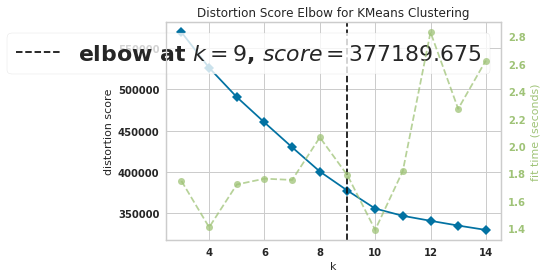

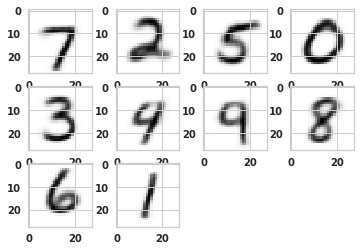

In [82]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [83]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [7, 2, 5, 0,
                                           3, -1, 9, 8,
                                           6, 1
                                          ]
manual_annotation_json["manual_confidence"] = [1, 1, 1, 1,
                                               1, 0, 0.8, 1,
                                               1, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    

    

Getting manual_annotation


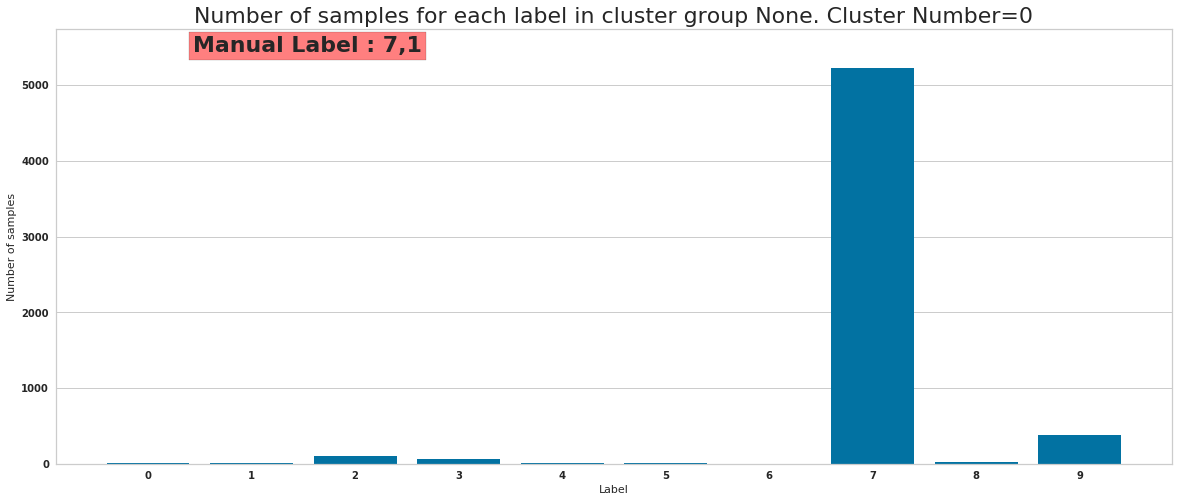

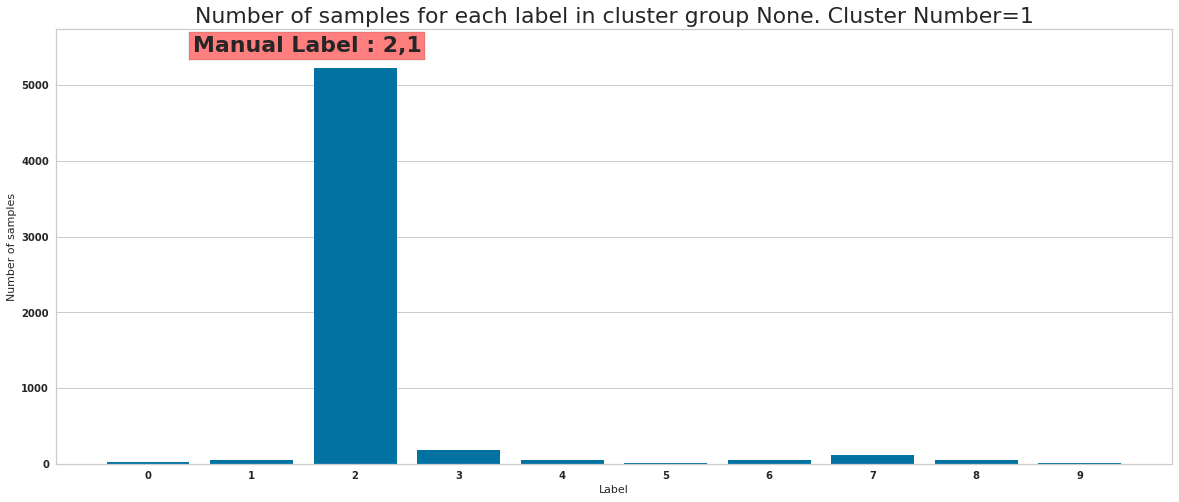

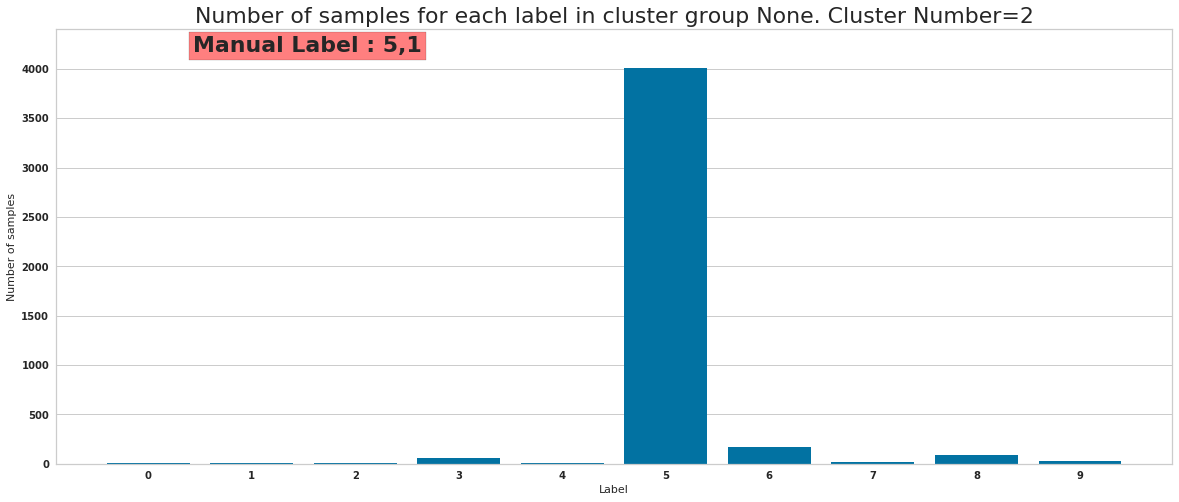

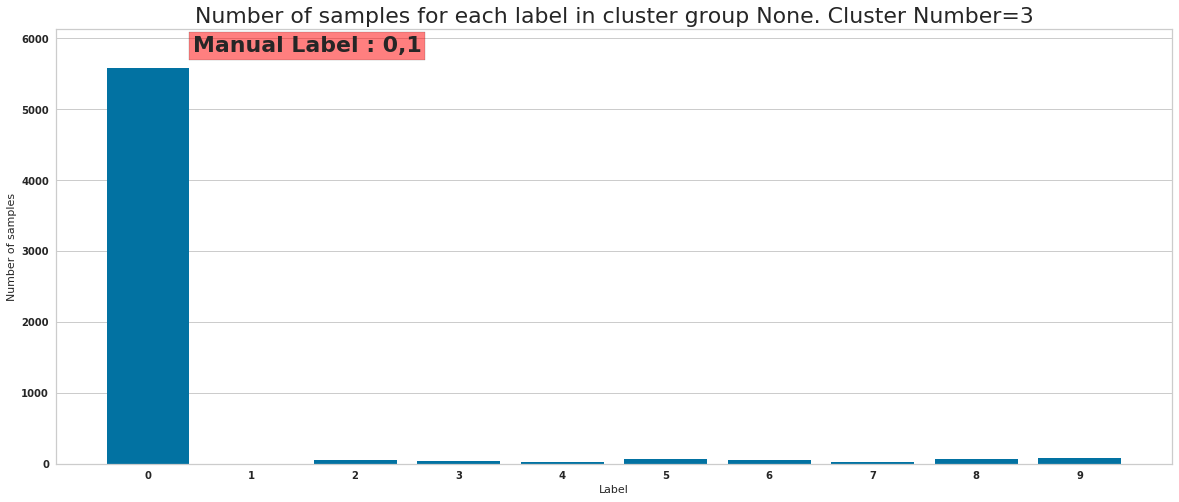

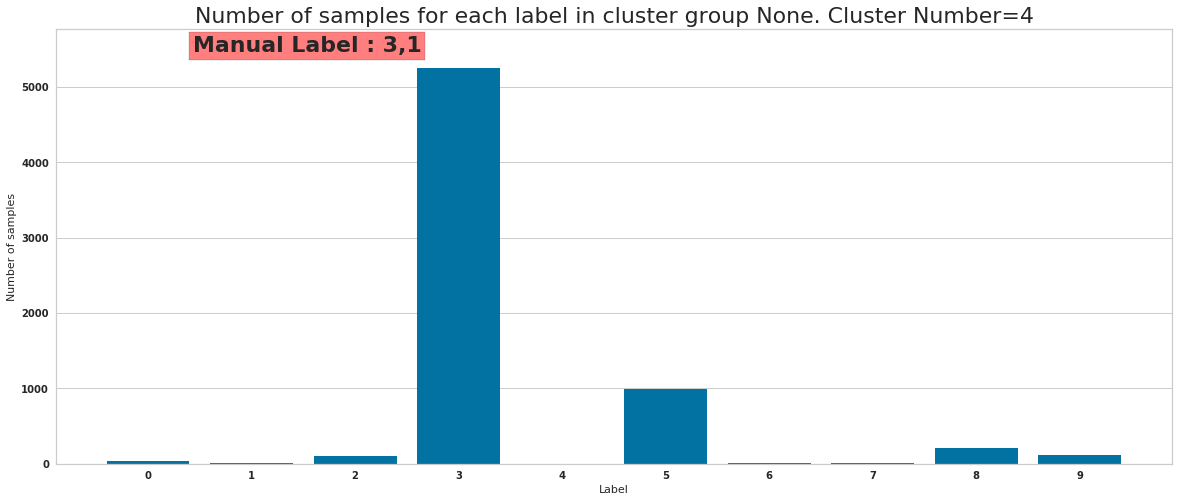

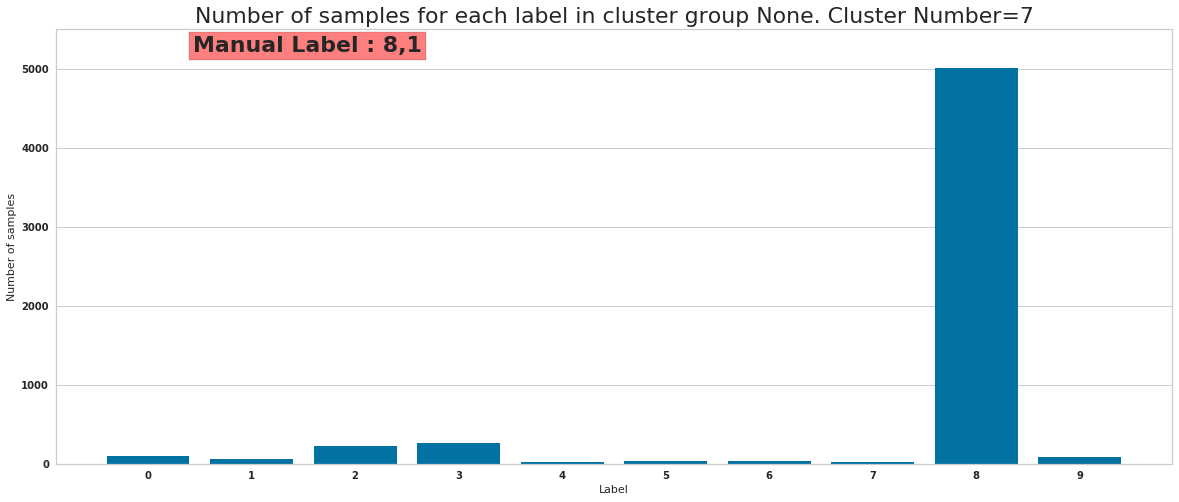

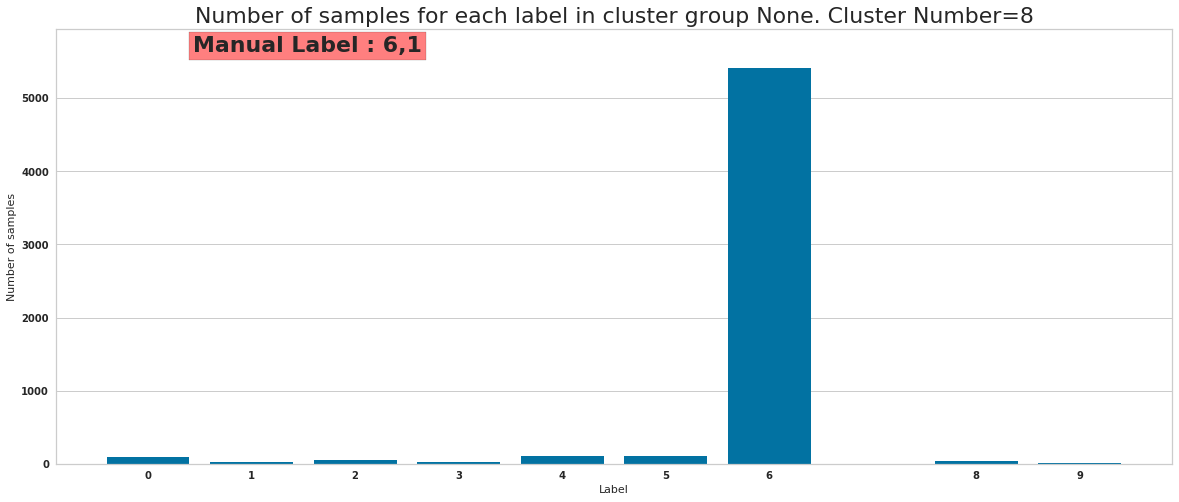

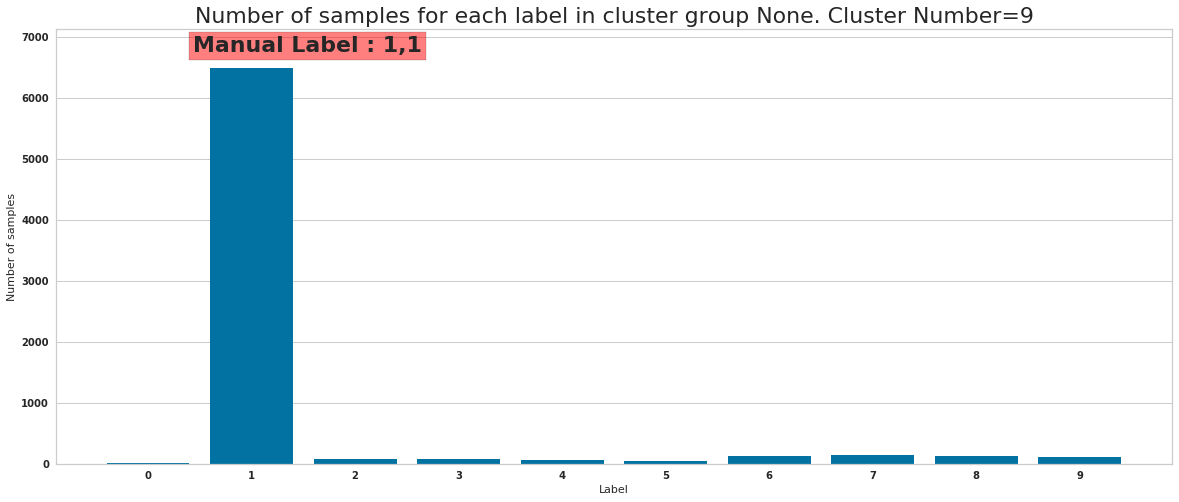

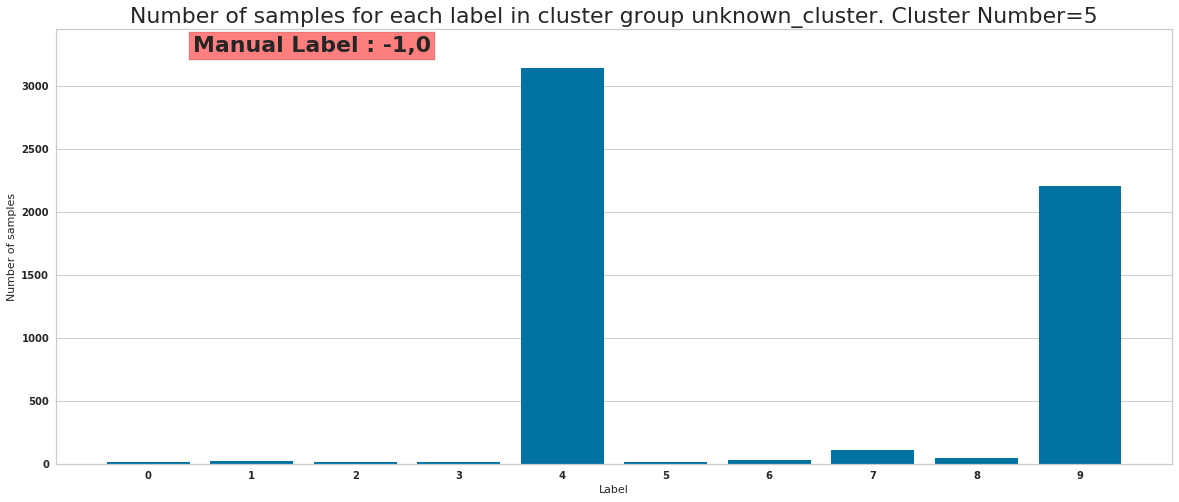

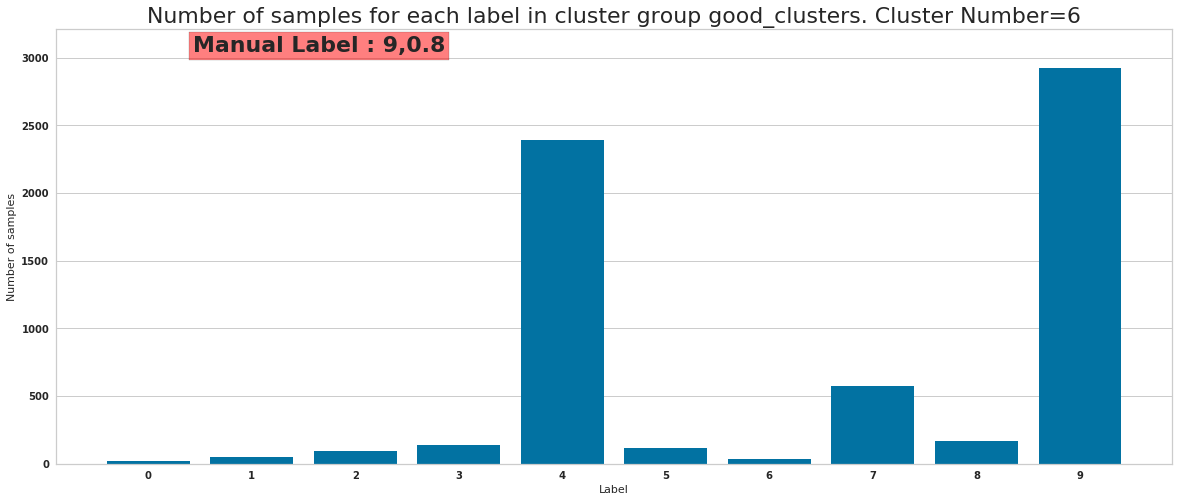

In [84]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

(5840, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(5781, 10)
(4399, 10)
(5986, 10)
(6738, 10)
(5625, 10)
(6504, 10)
(5851, 10)
(5865, 10)
(7251, 10)
5
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-3740"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-3740"
 
ckpt_name SemiSupervisedClassifierMnist.model-3740
INFO:tensorflow:Re

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


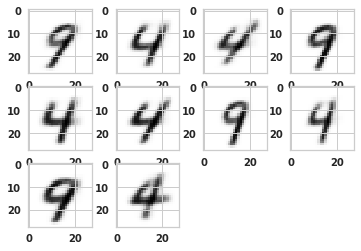

In [85]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



In [86]:
# level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [9, 4, 4, 9,
                                         4, 4, 9, 4,
                                         9, 4
                                        ]
level_2_cluster_dict["manual_confidences"] = [0.8,0.8,0.8,0.8,
                                             0.8,0.8,0.8,0.8,
                                             0.8,0.8]
level2_manual_annotations[5] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [3,-1,3,3,
# #                                         3,3,3,3,
# #                                         -1,3]
# # level_2_cluster_dict["manual_confidences"] = [0.9,0,0.9,0.9,
# #                                              0.9,0.9,0.9,0.9,
# #                                              0,0.9]
# # level2_manual_annotations[7] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0,0]
# # level2_manual_annotations[9] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0, 0]
# # level2_manual_annotations[13] = level_2_cluster_dict



In [87]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

5
10
0 (691,)
1 (548,)
2 (574,)
3 (660,)
4 (460,)
5 (552,)
6 (686,)
7 (509,)
8 (516,)
9 (429,)
Manual Label 7
(5840, 57) (5840, 33)
Num correct=5219
Cluster 0 Manual Label 7 Percentage correct 89.36643835616438
********************************
Manual Label 2
(5781, 57) (5781, 33)
Num correct=5218
Cluster 1 Manual Label 2 Percentage correct 90.26120048434527
********************************
Manual Label 5
(4399, 57) (4399, 33)
Num correct=4003
Cluster 2 Manual Label 5 Percentage correct 90.99795408047284
********************************
Manual Label 0
(5986, 57) (5986, 33)
Num correct=5577
Cluster 3 Manual Label 0 Percentage correct 93.16739057801537
********************************
Manual Label 3
(6738, 57) (6738, 33)
Num correct=5245
Cluster 4 Manual Label 3 Percentage correct 77.84208964084299
********************************
unknown
<class 'dict'>
['good_clusters']
********9*******
Manual_label 9
********4*******
Manual_label 4
********4*******
Manual_label 4
********9*******
Manual

In [88]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

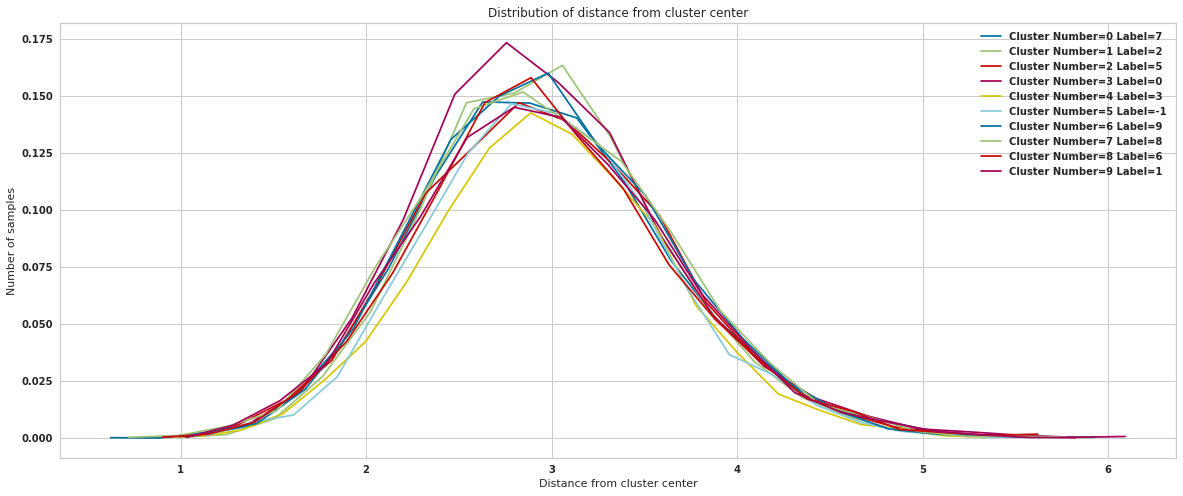

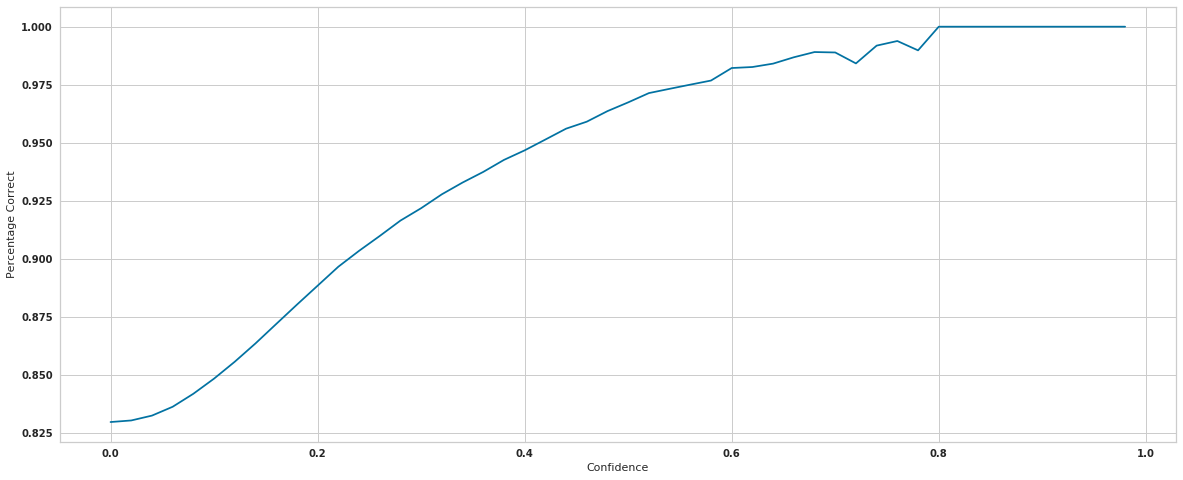

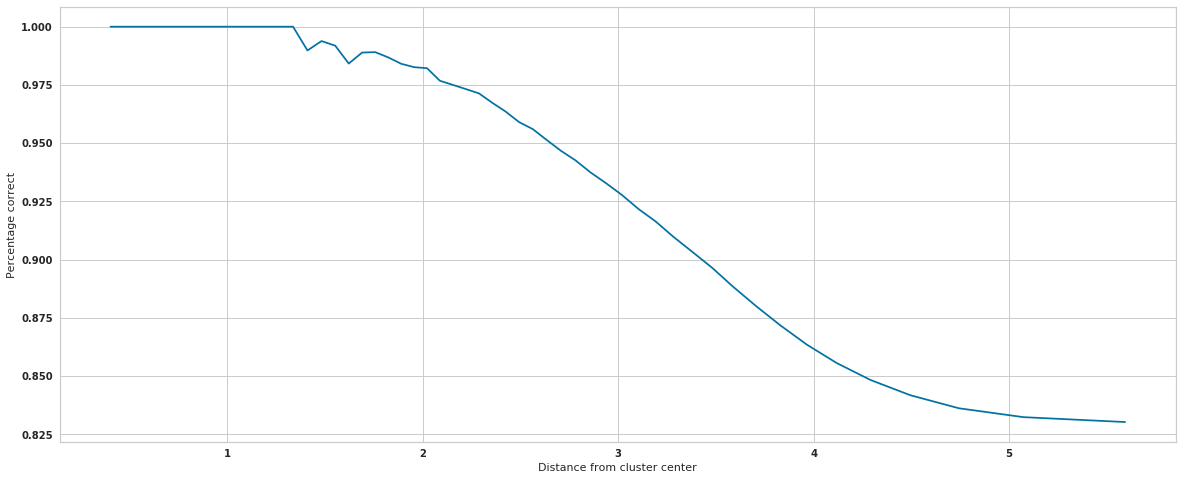

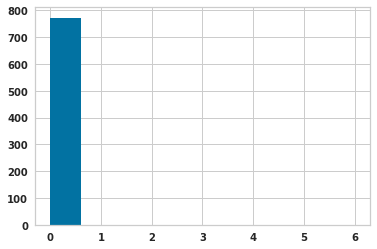

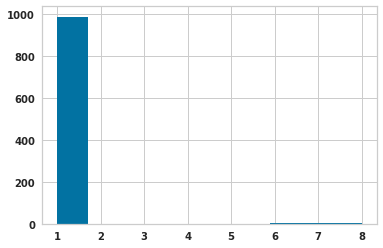

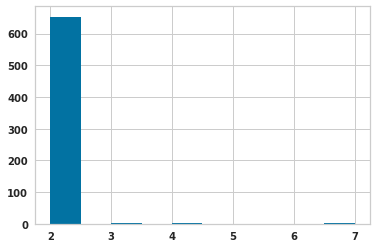

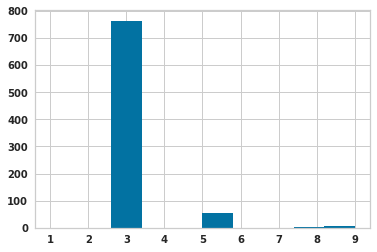

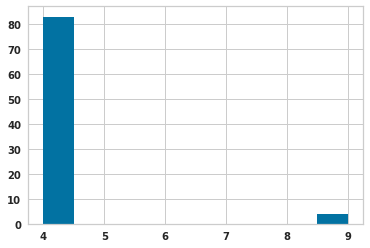

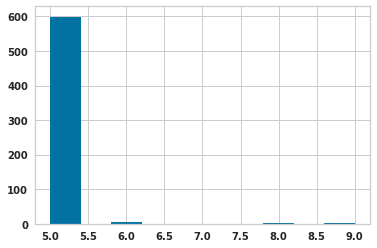

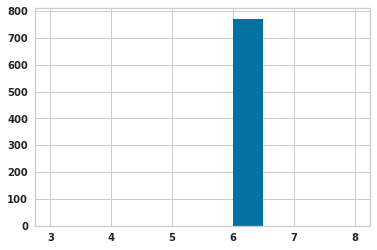

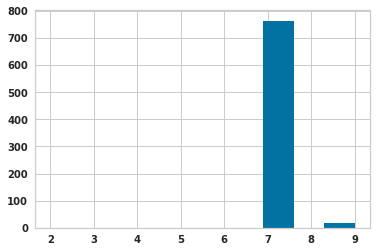

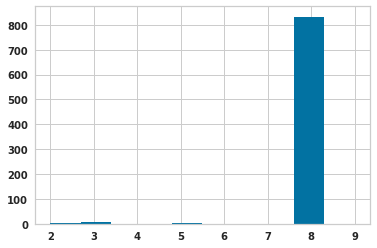

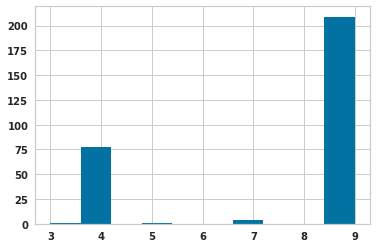

In [89]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# iteration 5

In [90]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 46, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k8'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 18640.44296649598
INFO:tensorflow:Summary name Negative Log Likeli

Epoch: 4/61, Nll_loss : 116.03243255615234 KLD:9.39434814453125  Supervised loss:0.0880088210105896
Epoch: 4/62, Nll_loss : 125.99564361572266 KLD:10.086771011352539  Supervised loss:0.09246321022510529
Epoch: 4/63, Nll_loss : 120.52699279785156 KLD:9.510750770568848  Supervised loss:0.07197773456573486
Epoch: 4/64, Nll_loss : 119.05384826660156 KLD:9.158361434936523  Supervised loss:0.08770160377025604
Epoch: 4/65, Nll_loss : 121.60769653320312 KLD:9.757333755493164  Supervised loss:0.11345124989748001
Epoch: 4/66, Nll_loss : 109.48069763183594 KLD:9.029475212097168  Supervised loss:0.08547156304121017
Epoch: 4/67, Nll_loss : 110.24800109863281 KLD:8.82116413116455  Supervised loss:0.10101635009050369
Epoch: 4/68, Nll_loss : 119.78010559082031 KLD:9.104098320007324  Supervised loss:0.0874488353729248
Epoch: 4/69, Nll_loss : 123.90458679199219 KLD:9.448867797851562  Supervised loss:0.0895434021949768
Epoch: 4/70, Nll_loss : 117.99512481689453 KLD:9.334760665893555  Supervised loss:0.09

Epoch: 4/142, Nll_loss : 120.82797241210938 KLD:9.376729965209961  Supervised loss:0.09341754019260406
Epoch: 4/143, Nll_loss : 117.69561767578125 KLD:9.178961753845215  Supervised loss:0.09377024322748184
Epoch: 4/144, Nll_loss : 113.7956314086914 KLD:9.135287284851074  Supervised loss:0.07165743410587311
Epoch: 4/145, Nll_loss : 121.68213653564453 KLD:8.834085464477539  Supervised loss:0.09691531211137772
Epoch: 4/146, Nll_loss : 111.28340911865234 KLD:9.55392074584961  Supervised loss:0.05699051916599274
Epoch: 4/147, Nll_loss : 118.17478942871094 KLD:9.77178955078125  Supervised loss:0.08069955557584763
Epoch: 4/148, Nll_loss : 121.34072875976562 KLD:9.781005859375  Supervised loss:0.10859794914722443
Epoch: 4/149, Nll_loss : 112.81061553955078 KLD:9.686620712280273  Supervised loss:0.11521699279546738
Epoch: 4/150, Nll_loss : 119.88835906982422 KLD:10.143672943115234  Supervised loss:0.08259286731481552
Epoch: 4/151, Nll_loss : 114.42588806152344 KLD:9.831430435180664  Supervised 

Epoch: 4/222, Nll_loss : 119.54918670654297 KLD:9.744401931762695  Supervised loss:0.08229365199804306
Epoch: 4/223, Nll_loss : 117.7297592163086 KLD:9.446744918823242  Supervised loss:0.05570867285132408
Epoch: 4/224, Nll_loss : 120.08901977539062 KLD:10.0005464553833  Supervised loss:0.058252837508916855
Epoch: 4/225, Nll_loss : 125.03546142578125 KLD:9.52972412109375  Supervised loss:0.11950995773077011
Epoch: 4/226, Nll_loss : 115.63789367675781 KLD:9.440727233886719  Supervised loss:0.06842292845249176
Epoch: 4/227, Nll_loss : 115.96245574951172 KLD:9.271709442138672  Supervised loss:0.16041770577430725
Epoch: 4/228, Nll_loss : 120.91835021972656 KLD:9.374188423156738  Supervised loss:0.06906937807798386
Epoch: 4/229, Nll_loss : 116.01826477050781 KLD:9.618244171142578  Supervised loss:0.08090279996395111
Epoch: 4/230, Nll_loss : 123.44964599609375 KLD:9.383102416992188  Supervised loss:0.09418158233165741
Epoch: 4/231, Nll_loss : 117.71552276611328 KLD:9.816582679748535  Supervis

Epoch: 4/303, Nll_loss : 114.98712921142578 KLD:9.71516227722168  Supervised loss:0.06321626901626587
Epoch: 4/304, Nll_loss : 116.69579315185547 KLD:9.763345718383789  Supervised loss:0.07703395187854767
Epoch: 4/305, Nll_loss : 108.8524169921875 KLD:9.537773132324219  Supervised loss:0.0894814133644104
Epoch: 4/306, Nll_loss : 121.43809509277344 KLD:9.692464828491211  Supervised loss:0.15081439912319183
Epoch: 4/307, Nll_loss : 115.17703247070312 KLD:9.504627227783203  Supervised loss:0.051551703363657
Epoch: 4/308, Nll_loss : 123.90641021728516 KLD:9.664077758789062  Supervised loss:0.08905291557312012
Epoch: 4/309, Nll_loss : 117.85504150390625 KLD:9.181909561157227  Supervised loss:0.11286167055368423
Epoch: 4/310, Nll_loss : 124.13931274414062 KLD:9.317217826843262  Supervised loss:0.08400771021842957
Epoch: 4/311, Nll_loss : 126.03034210205078 KLD:9.219598770141602  Supervised loss:0.07952938228845596
Epoch: 4/312, Nll_loss : 122.84600830078125 KLD:9.328054428100586  Supervised 

Epoch: 4/383, Nll_loss : 121.08277130126953 KLD:9.200628280639648  Supervised loss:0.09000982344150543
Epoch: 4/384, Nll_loss : 127.49292755126953 KLD:9.946073532104492  Supervised loss:0.06968802213668823
Epoch: 4/385, Nll_loss : 117.66667938232422 KLD:9.992928504943848  Supervised loss:0.09723088145256042
Epoch: 4/386, Nll_loss : 116.85614776611328 KLD:10.128616333007812  Supervised loss:0.04186781495809555
Epoch: 4/387, Nll_loss : 112.3829116821289 KLD:9.612011909484863  Supervised loss:0.09927906841039658
Epoch: 4/388, Nll_loss : 116.29185485839844 KLD:9.67753791809082  Supervised loss:0.09559787064790726
Epoch: 4/389, Nll_loss : 116.99394226074219 KLD:9.449980735778809  Supervised loss:0.10157858580350876
Epoch: 4/390, Nll_loss : 117.23703002929688 KLD:9.794151306152344  Supervised loss:0.09565522521734238
Epoch: 4/391, Nll_loss : 115.1553955078125 KLD:9.433629989624023  Supervised loss:0.07519340515136719
Epoch: 4/392, Nll_loss : 113.1383056640625 KLD:9.644126892089844  Supervise

Epoch: 4/465, Nll_loss : 124.98294067382812 KLD:9.073308944702148  Supervised loss:0.11987349390983582
Epoch: 4/466, Nll_loss : 116.16517639160156 KLD:9.027600288391113  Supervised loss:0.06856942176818848
Epoch: 4/467, Nll_loss : 111.58668518066406 KLD:9.229328155517578  Supervised loss:0.07006387412548065
Epoch: 4/468, Nll_loss : 119.28585052490234 KLD:9.371082305908203  Supervised loss:0.09857474267482758
Epoch: 4/469, Nll_loss : 112.52145385742188 KLD:9.541727066040039  Supervised loss:0.08736374229192734
Epoch: 4/470, Nll_loss : 111.79871368408203 KLD:9.848485946655273  Supervised loss:0.057668592780828476
Epoch: 4/471, Nll_loss : 114.28575134277344 KLD:9.789163589477539  Supervised loss:0.06627725064754486
Epoch: 4/472, Nll_loss : 116.01693725585938 KLD:9.845064163208008  Supervised loss:0.10225653648376465
Epoch: 4/473, Nll_loss : 113.44539642333984 KLD:9.77070426940918  Supervised loss:0.07727223634719849
Epoch: 4/474, Nll_loss : 114.09974670410156 KLD:9.387408256530762  Superv

Epoch: 4/545, Nll_loss : 121.62309265136719 KLD:9.38197135925293  Supervised loss:0.08021993190050125
Epoch: 4/546, Nll_loss : 118.58511352539062 KLD:9.185548782348633  Supervised loss:0.06053600460290909
Epoch: 4/547, Nll_loss : 121.32815551757812 KLD:9.155601501464844  Supervised loss:0.11462267488241196
Epoch: 4/548, Nll_loss : 113.75237274169922 KLD:9.184809684753418  Supervised loss:0.06913208216428757
Epoch: 4/549, Nll_loss : 111.26838684082031 KLD:9.454156875610352  Supervised loss:0.08739084750413895
Epoch: 4/550, Nll_loss : 112.39085388183594 KLD:9.691555976867676  Supervised loss:0.11094039678573608
Epoch: 4/551, Nll_loss : 118.91757202148438 KLD:9.761614799499512  Supervised loss:0.07414434105157852
Epoch: 4/552, Nll_loss : 105.8157730102539 KLD:9.501379013061523  Supervised loss:0.07658806443214417
Epoch: 4/553, Nll_loss : 118.21223449707031 KLD:9.74891185760498  Supervised loss:0.10718805342912674
Epoch: 4/554, Nll_loss : 115.57425689697266 KLD:9.699776649475098  Supervise

Epoch: 4/625, Nll_loss : 123.51844024658203 KLD:9.859895706176758  Supervised loss:0.18316973745822906
Epoch: 4/626, Nll_loss : 119.58111572265625 KLD:9.640600204467773  Supervised loss:0.07596524804830551
Epoch: 4/627, Nll_loss : 108.87783813476562 KLD:9.28458023071289  Supervised loss:0.08877581357955933
Epoch: 4/628, Nll_loss : 113.33805084228516 KLD:9.62246322631836  Supervised loss:0.11381189525127411
Epoch: 4/629, Nll_loss : 118.65087890625 KLD:9.407283782958984  Supervised loss:0.06785471737384796
Epoch: 4/630, Nll_loss : 116.67330932617188 KLD:9.486333847045898  Supervised loss:0.07703305780887604
Epoch: 4/631, Nll_loss : 112.29576873779297 KLD:9.261411666870117  Supervised loss:0.12493525445461273
Epoch: 4/632, Nll_loss : 111.22914123535156 KLD:9.243996620178223  Supervised loss:0.07636218518018723
Epoch: 4/633, Nll_loss : 112.05363464355469 KLD:9.250974655151367  Supervised loss:0.13602270185947418
Epoch: 4/634, Nll_loss : 116.93511962890625 KLD:9.288045883178711  Supervised 

Epoch: 4/705, Nll_loss : 121.96305847167969 KLD:9.124996185302734  Supervised loss:0.07268289476633072
Epoch: 4/706, Nll_loss : 111.06656646728516 KLD:9.08011531829834  Supervised loss:0.07670730352401733
Epoch: 4/707, Nll_loss : 115.90007781982422 KLD:9.069947242736816  Supervised loss:0.08849163353443146
Epoch: 4/708, Nll_loss : 110.57341003417969 KLD:8.81762981414795  Supervised loss:0.07200000435113907
Epoch: 4/709, Nll_loss : 116.22158813476562 KLD:9.60799789428711  Supervised loss:0.0628366470336914
Epoch: 4/710, Nll_loss : 115.53103637695312 KLD:9.507226943969727  Supervised loss:0.08466406166553497
Epoch: 4/711, Nll_loss : 115.93527221679688 KLD:9.472381591796875  Supervised loss:0.07833673804998398
Epoch: 4/712, Nll_loss : 116.25933837890625 KLD:9.725730895996094  Supervised loss:0.09580318629741669
Epoch: 4/713, Nll_loss : 114.48296356201172 KLD:9.566679954528809  Supervised loss:0.10714883357286453
Epoch: 4/714, Nll_loss : 112.38203430175781 KLD:9.788530349731445  Supervised

Epoch: 4/786, Nll_loss : 118.1607666015625 KLD:9.227340698242188  Supervised loss:0.09665609896183014
Epoch: 4/787, Nll_loss : 119.73721313476562 KLD:9.353189468383789  Supervised loss:0.0685414969921112
Epoch: 4/788, Nll_loss : 124.25569152832031 KLD:9.234418869018555  Supervised loss:0.09510359168052673
Epoch: 4/789, Nll_loss : 120.0333023071289 KLD:9.50340747833252  Supervised loss:0.09811285138130188
Epoch: 4/790, Nll_loss : 120.33186340332031 KLD:9.32726764678955  Supervised loss:0.09211289882659912
Epoch: 4/791, Nll_loss : 112.07728576660156 KLD:9.195535659790039  Supervised loss:0.08131092041730881
Epoch: 4/792, Nll_loss : 117.167724609375 KLD:9.493793487548828  Supervised loss:0.08319823443889618
Epoch: 4/793, Nll_loss : 112.24041748046875 KLD:8.974227905273438  Supervised loss:0.0953105092048645
Epoch: 4/794, Nll_loss : 115.92683410644531 KLD:9.711886405944824  Supervised loss:0.06392841786146164
Epoch: 4/795, Nll_loss : 114.26455688476562 KLD:9.620943069458008  Supervised los

Epoch: 4/867, Nll_loss : 112.62460327148438 KLD:9.650545120239258  Supervised loss:0.09254328906536102
Epoch: 4/868, Nll_loss : 110.36767578125 KLD:9.862258911132812  Supervised loss:0.07364456355571747
Epoch: 4/869, Nll_loss : 118.0081787109375 KLD:9.858909606933594  Supervised loss:0.05615461990237236
Epoch: 4/870, Nll_loss : 119.6636962890625 KLD:10.116158485412598  Supervised loss:0.11039303988218307
Epoch: 4/871, Nll_loss : 113.59083557128906 KLD:9.792478561401367  Supervised loss:0.05523558706045151
Epoch: 4/872, Nll_loss : 113.77354431152344 KLD:9.412256240844727  Supervised loss:0.06576166301965714
Epoch: 4/873, Nll_loss : 116.06407165527344 KLD:9.51167106628418  Supervised loss:0.08219978213310242
Epoch: 4/874, Nll_loss : 119.43760681152344 KLD:9.493636131286621  Supervised loss:0.05238116905093193
Epoch: 4/875, Nll_loss : 116.43696594238281 KLD:9.293581008911133  Supervised loss:0.0872649997472763
Epoch: 4/876, Nll_loss : 113.80609130859375 KLD:9.0956392288208  Supervised los

Running evaluation after epoch:5 and step:935 
epoch:5 step:935
Saving evaluation results to  /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/analysis/


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-4675"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-4675"
 
ckpt_name SemiSupervisedClassifierMnist.model-4675
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_

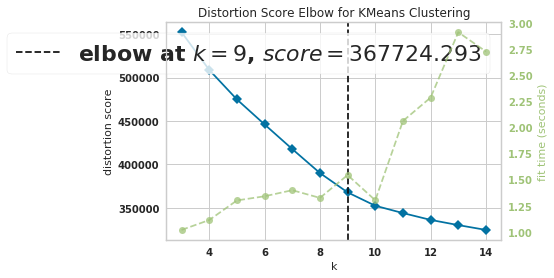

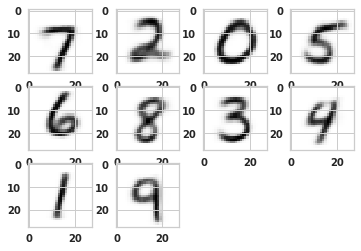

In [91]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


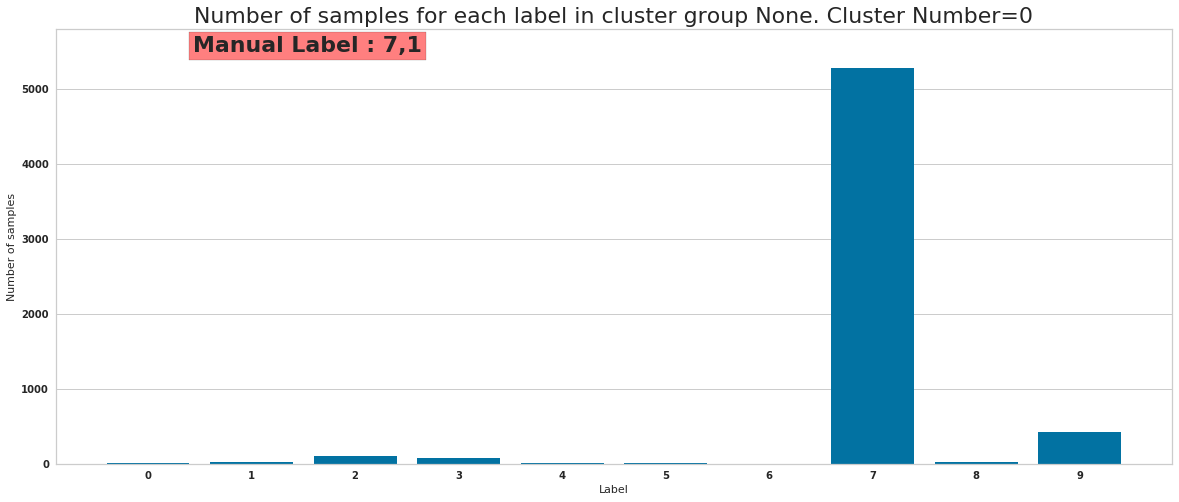

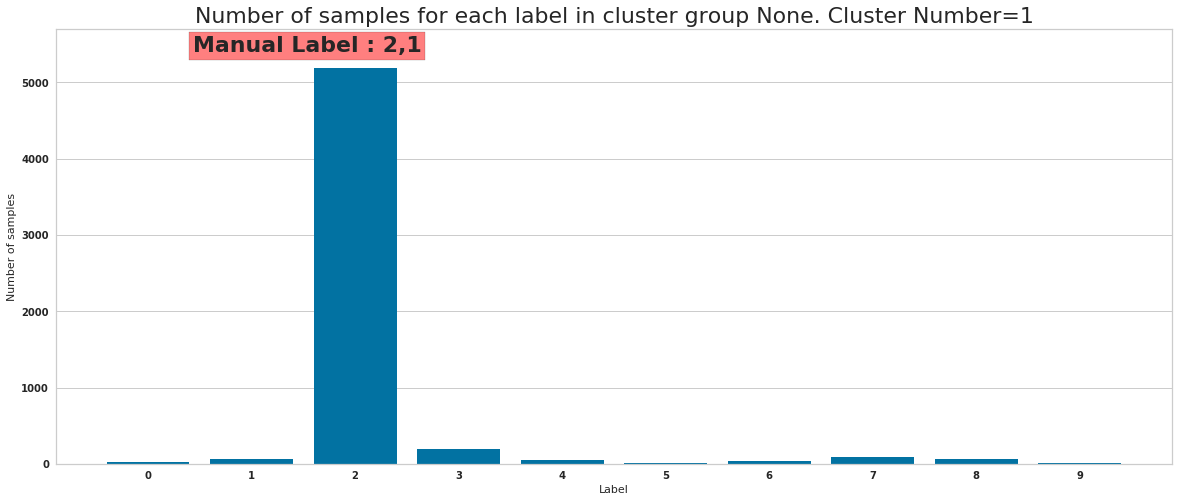

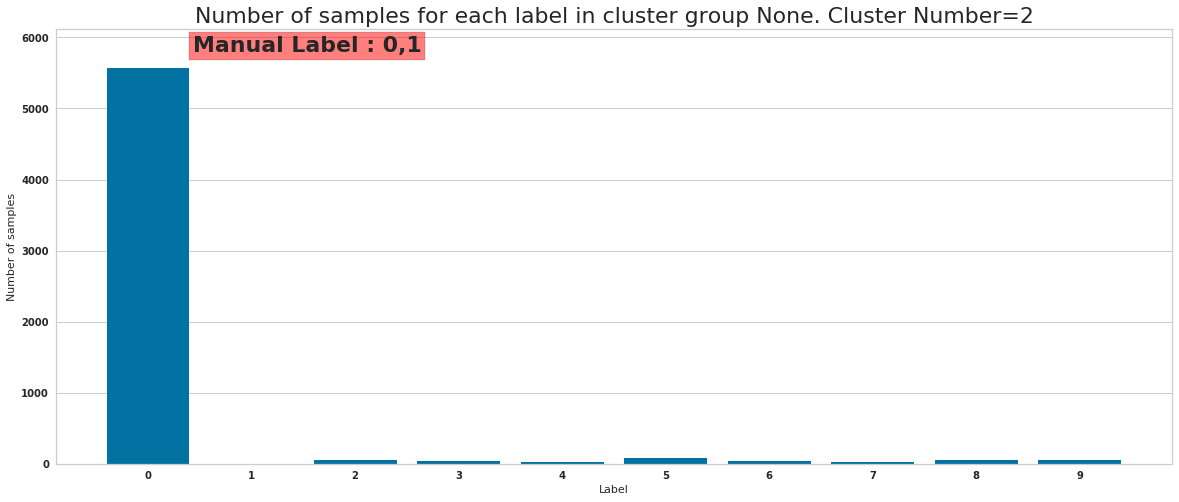

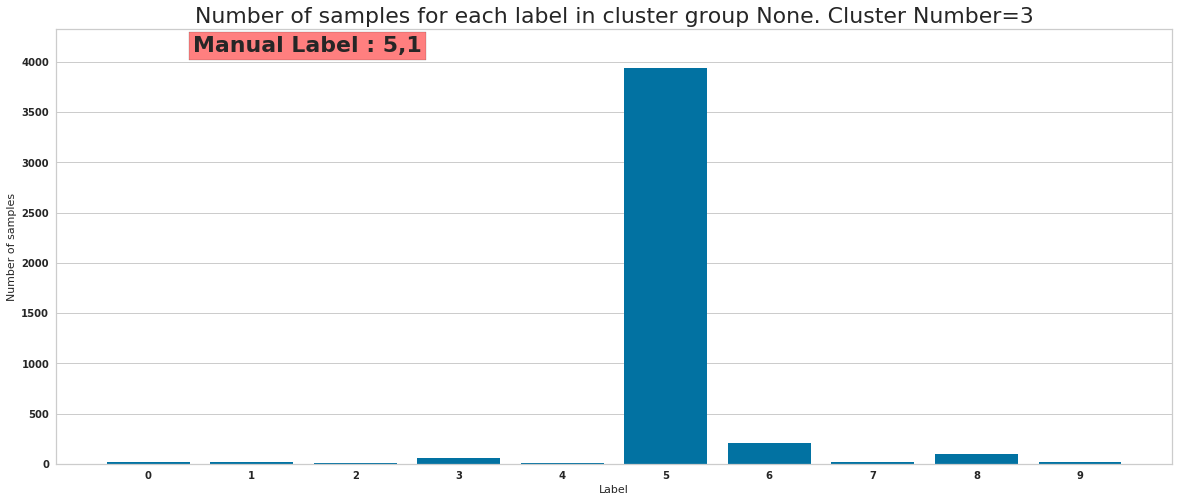

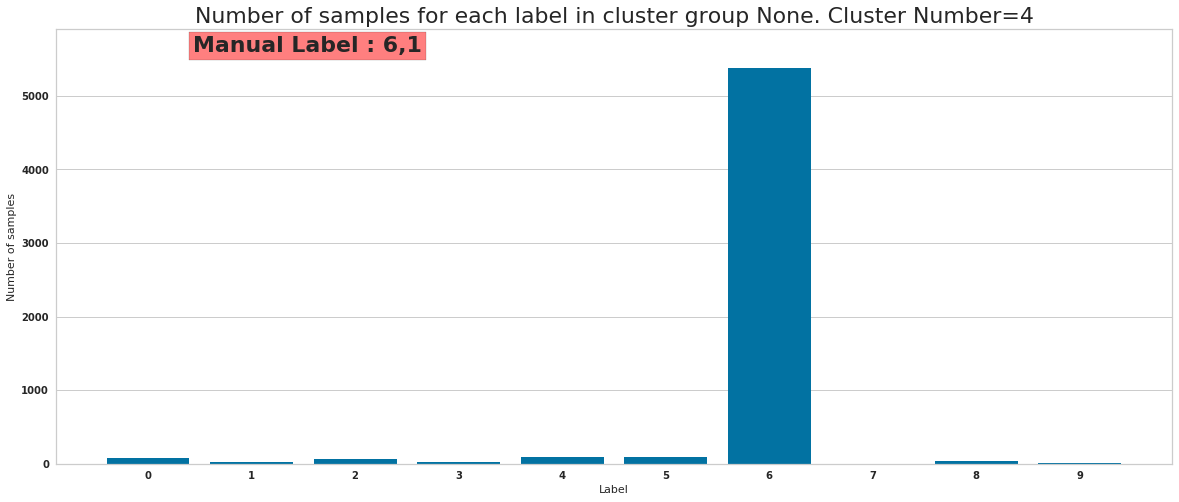

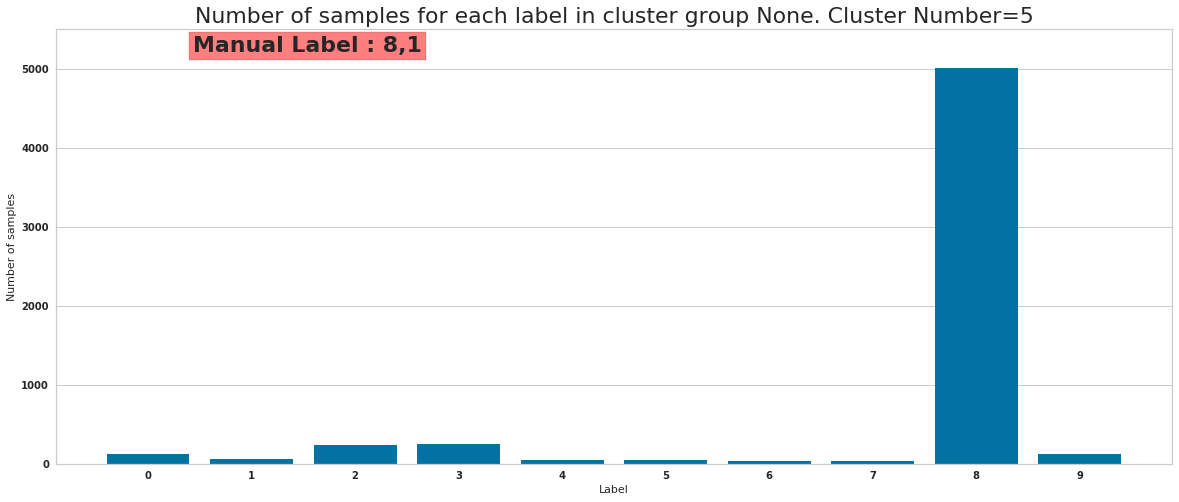

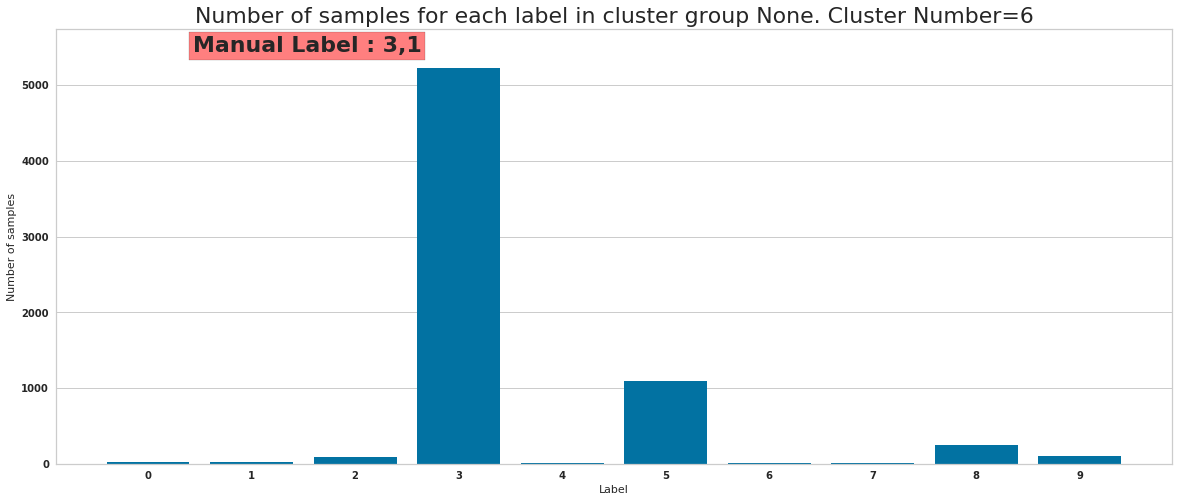

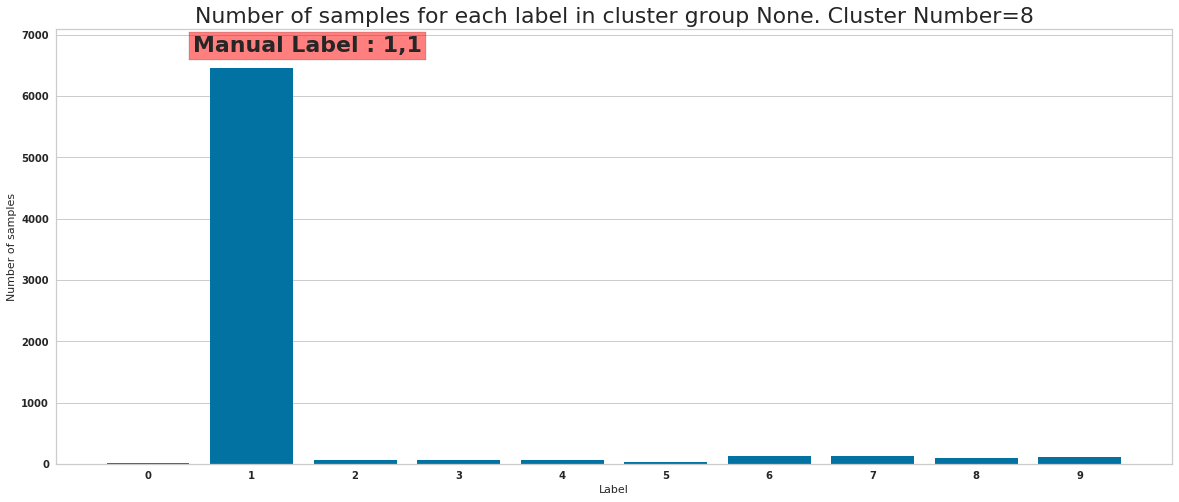

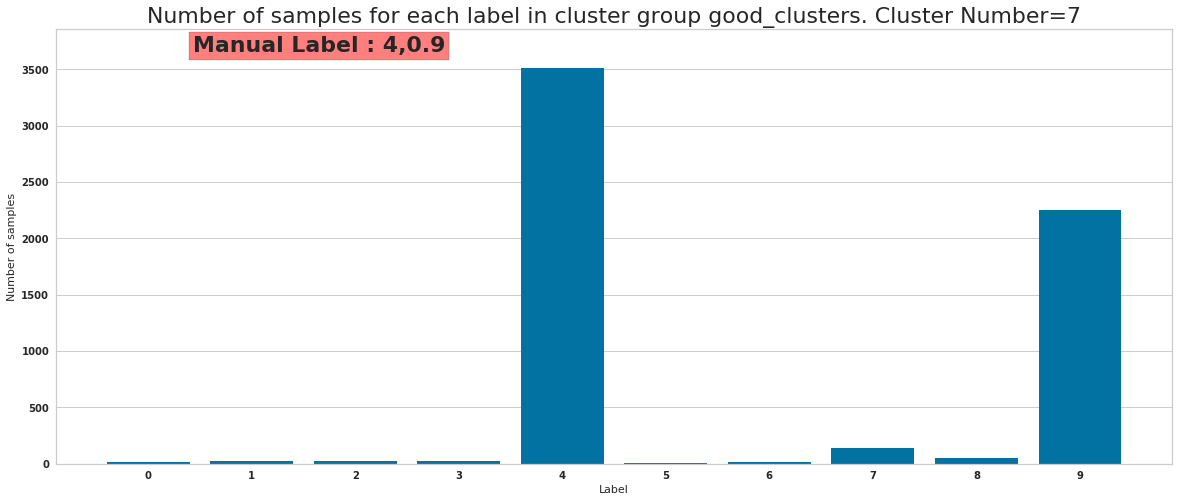

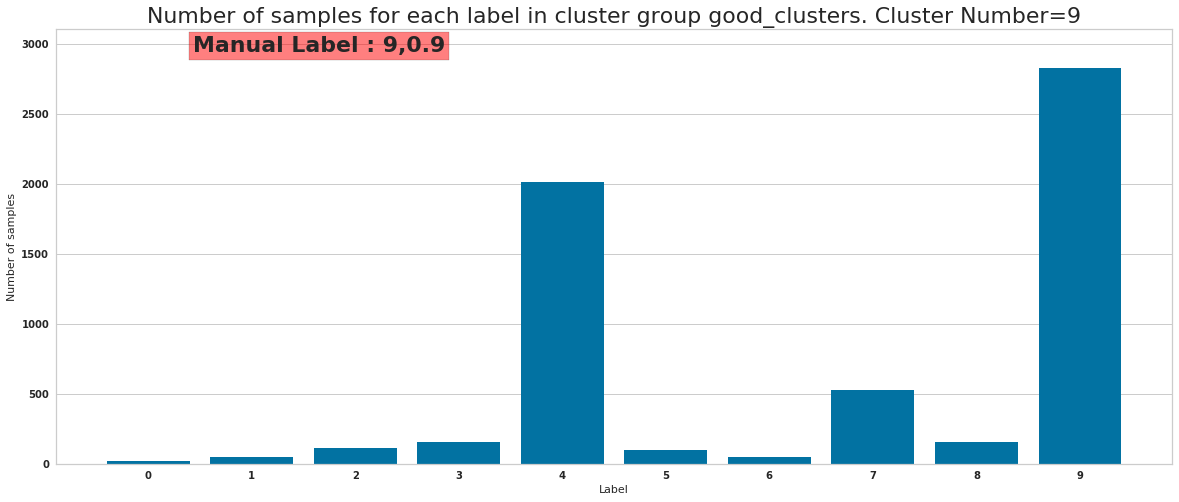

In [92]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [7, 2, 0, 5,
                                           6, 8, 3, 4,
                                           1, 9
                                          ]
manual_annotation_json["manual_confidence"] = [1, 1, 1, 1,
                                               1, 1, 1, 0.9,
                                               1, 0.9
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )



In [95]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



(5978, 10)
(5737, 10)
(5941, 10)
(4396, 10)
(5797, 10)
(5978, 10)
(6812, 10)
(6068, 10)
(7141, 10)
(5992, 10)


In [96]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[2] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [97]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 7
(5978, 47) (5978, 33)
Num correct=5273
Cluster 0 Manual Label 7 Percentage correct 88.20675811308129
********************************
Manual Label 2
(5737, 47) (5737, 33)
Num correct=5184
Cluster 1 Manual Label 2 Percentage correct 90.36081575736448
********************************
Manual Label 0
(5941, 47) (5941, 33)
Num correct=5563
Cluster 2 Manual Label 0 Percentage correct 93.63743477529036
********************************
Manual Label 5
(4396, 47) (4396, 33)
Num correct=3935
Cluster 3 Manual Label 5 Percentage correct 89.51319381255686
********************************
Manual Label 6
(5797, 47) (5797, 33)
Num correct=5369
Cluster 4 Manual Label 6 Percentage correct 92.61687079523891
********************************
Manual Label 8
(5978, 47) (5978, 33)
Num correct=5005
Cluster 5 Manual Label 8 Percentage correct 83.72365339578454
********************************
Manual Label 3
(6812, 47) (6812, 33)
Num correct=5218
Cluster 6 Manual Label 3 Percentage correct 76.60011

In [98]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

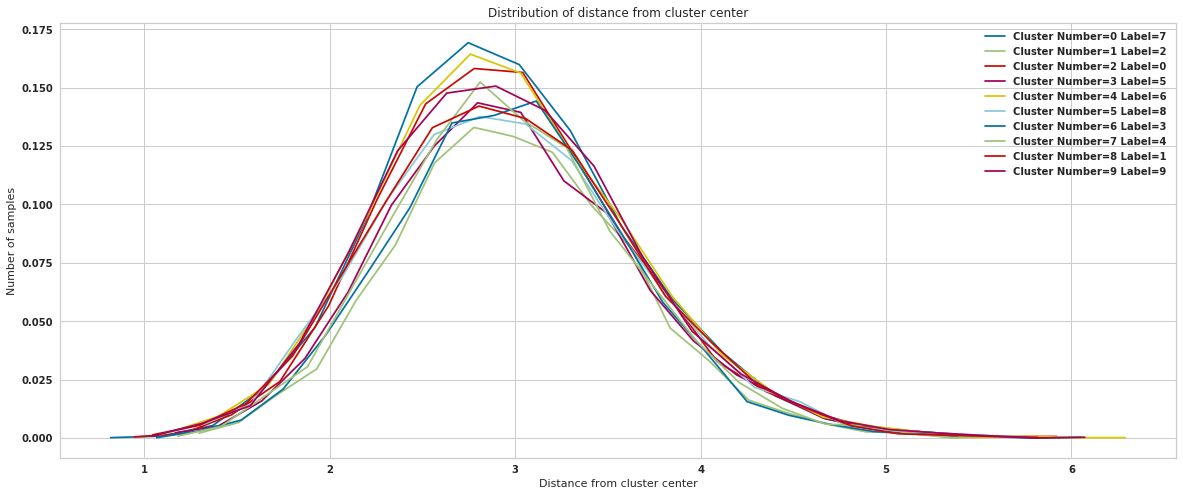

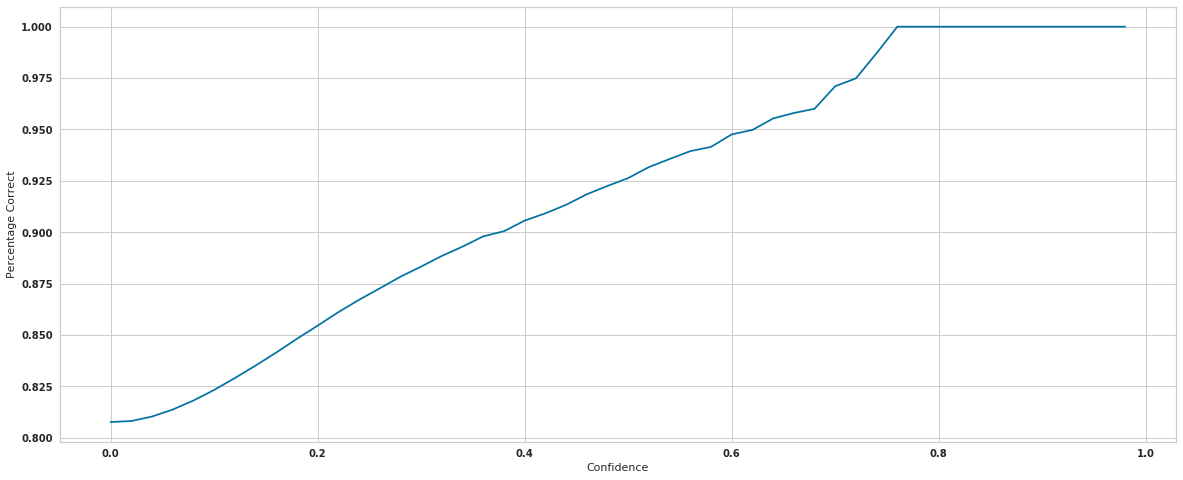

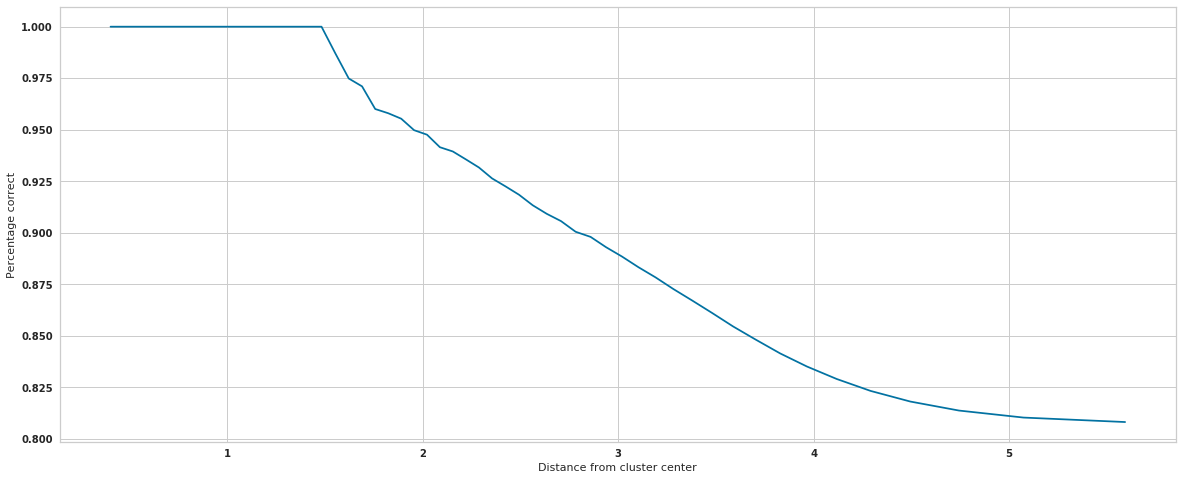

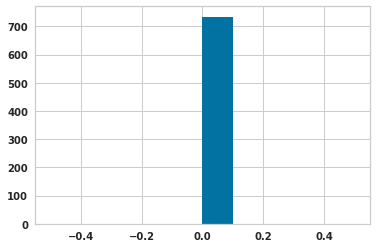

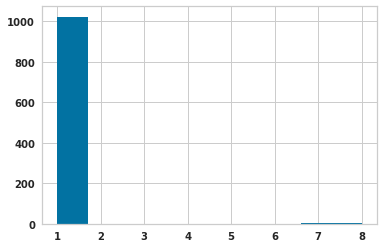

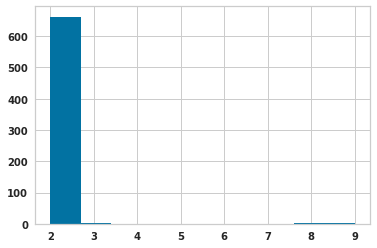

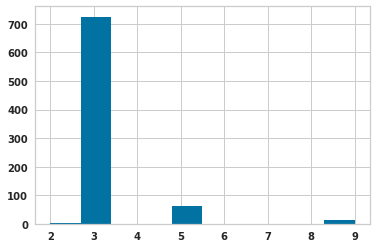

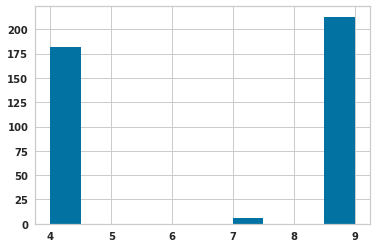

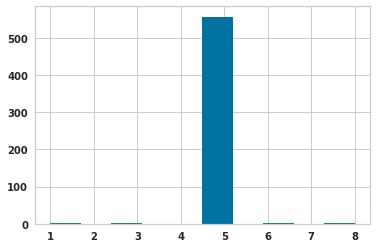

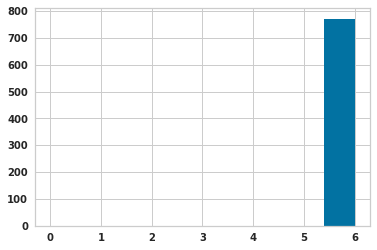

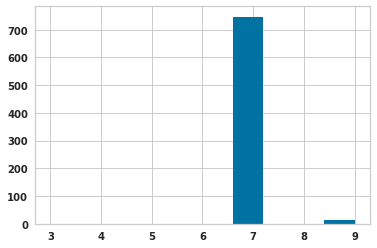

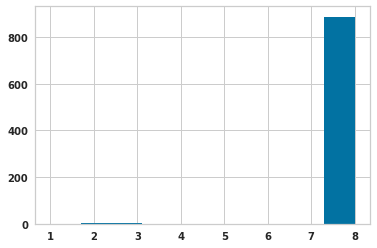

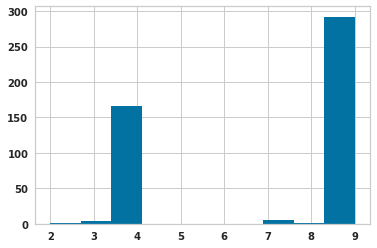

In [99]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()